In [1]:
!pip install Lifetimes

     |████████████████████████████████| 584 kB 4.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=6b0d9965a2e3c3d0e61f231dbaab9ebfe53770486362f1ccf31ab441123e0d08
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/85/f5/d2/3ef47d3a836b17620bf41647222825b065245862d12aa62885
Successfully built autograd
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity

In [3]:
transactions = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/transactions_train.csv')

In [4]:
articles = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/articles.csv')

In [5]:
clusters = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/clusters_4.csv')

In [6]:
view = pd.merge(left=transactions, right=articles, how='left', left_on='article_id', right_on='article_id')

In [7]:
view.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,505221,Inca Jumper,252,Sweater,Garment Upper body,...,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...


In [8]:
view1 = view.groupby(["product_type_name", "department_name"]).agg({'price': 'mean'}).reset_index()

In [9]:
view1.head(5)

,product_type_name,department_name,price
0,Accessories set,Baby Toys/Acc,0.021262
1,Accessories set,Boys Small Acc & Bags,0.009729
2,Accessories set,Kids Girl Big Acc,0.022017
3,Alice band,Girls Small Acc/Bags,0.008016
4,Alice band,Hair Accessories,0.010388


In [10]:
# Baby toys in H&M US Website --> 20+ USD

In [11]:
df = transactions.copy()

In [12]:
# Assumption scale by 1000
df['price'] = df['price'] * 1000

In [13]:
df.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e+01,1.704028e+00
std,1.334480e+08,1.918113e+01,4.564786e-01
min,1.087750e+08,1.694915e-02,1.000000e+00
25%,6.328030e+08,1.581356e+01,1.000000e+00
50%,7.145820e+08,2.540678e+01,2.000000e+00
75%,7.865240e+08,3.388136e+01,2.000000e+00
max,9.562170e+08,5.915254e+02,2.000000e+00


In [14]:
# Filter by customers avil in segments
clusters.head(5)

,customer_id,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,Champions
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,Unprofitable


In [15]:
df = df[df['customer_id'].isin(clusters['customer_id'])].reset_index(drop=True)

In [16]:
df.drop(["sales_channel_id"], axis = 1, inplace=True)

In [17]:
data_grp = df.groupby(["t_dat", "customer_id"]).agg({'article_id':'count', 'price': 'sum'}).reset_index()

In [18]:
data_grp.describe()

,article_id,price
count,54018.000000,54018.000000
mean,2.850217,77.415860
std,2.546998,81.905230
min,1.000000,0.847458
25%,1.000000,32.169492
50%,2.000000,50.830508
75%,4.000000,94.847458
max,42.000000,4558.966102


CLV

4.1 Definitions
* Recency: the number of time periods between a customer’s first and last (latest) transactions
* Frequency: the number of time periods, after the initial purchase, when the customer buys again
* Monetary Value: the average value of the customer’s transactions (revenues or profit per transaction)

Additionally,
* Customer age T: the number of time periods since the customer’s first purchase

In [19]:
data_grp['t_dat'] = pd.to_datetime(data_grp['t_dat'])

In [20]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = data_grp["t_dat"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = data_grp, 
        customer_id_col = "customer_id", 
        datetime_col = "t_dat",
        monetary_value_col = "price", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2020-09-22 00:00:00
end of calibration period: 2020-01-26 00:00:00
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,7,336,395,56,2,72,240
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,2,162,493,32,4,140,240
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,3,362,471,49,2,128,240
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,0,0,72,0,1,42,240
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,0,0,449,0,0,0,240
...,...,...,...,...,...,...,...
058541084e0d4cab8a70b3e6c1749ff59bdef783fb667f72c6b26ae0441c620f,1,1,243,64,0,0,240
05854b82c895afd025f959f3bece77106ef93b1d24c6c991c596ac5fd94f1b3f,2,342,492,148,0,0,240
058551aae22c37412da14b7982ac1327ec5e85ddf6413ee96747e45729bfc475,2,161,177,59,1,68,240


5.1 BG/NBD Concept
In non-contractual business settings, the purchase behavior of customers does not follow a deterministic trend. Both demand levels and churn rates are random variables. A distributional model like BG/NBD describes the random processes that influence the customer behavior, individually and in aggregate.
The method relies on four distributional assumptions to model the uncertainties:
* The number of orders a customer will place in a time period follows a Poisson distribution with transaction rate lambda. This Poisson count distribution is equivalent to the assumption that the time between transactions follows an exponential distribution with the same transaction rate lambda.
* The demand varies independently between customers: heterogeneity in lambda. The variation in lambda is a random variable that follows a Gamma distribution with shape parameter r and scale alpha.
* After any purchase, a customer may become inactive with probability p and turns away from the business. The churn risk follows a Geometric distribution.
* The churn risk varies independently between customers: heterogeneity in p. The variation of the churn or dropout probability p is a random variable that follows a Beta distribution.

In [21]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -1.299096
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


<lifetimes.BetaGeoFitter: fitted with 10556 subjects, a: 1.18, alpha: 83.53, b: 16.27, r: 0.75>

<Figure size 864x864 with 0 Axes>

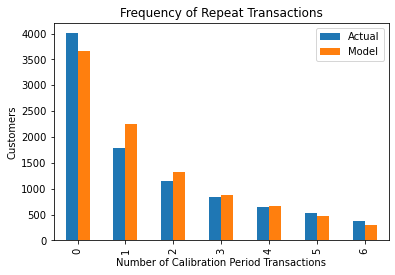

In [22]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

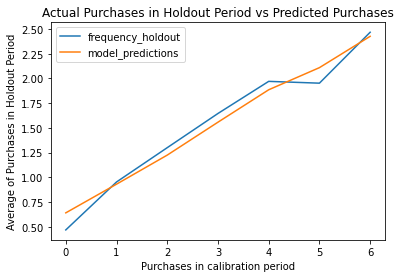

In [23]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

In [24]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = data_grp, 
    customer_id_col = "customer_id", 
    datetime_col = "t_dat", 
    monetary_value_col = "price", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9,618,635,60
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6,726,733,104
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5,670,711,80
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,1,249,312,42
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,0,0,689,0
...,...,...,...,...
058551aae22c37412da14b7982ac1327ec5e85ddf6413ee96747e45729bfc475,3,276,417,62
0585761bf583cc8468a107690940cfc34e685cb75c6b0ca992ba865d912ee8a3,7,594,642,178
0585981d85cc02082b3f591342a90fab8144c398319ffa45ee72d6e6a598247e,1,587,641,110


In [25]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -2.732061
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.667,0.013,0.642,0.691
alpha,81.707,2.007,77.772,85.641
a,0.597,0.093,0.415,0.779
b,8.455,1.647,5.227,11.684


38


<Figure size 864x864 with 0 Axes>

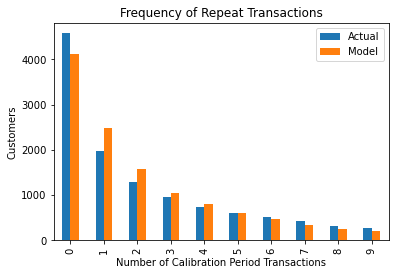

In [26]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)


# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

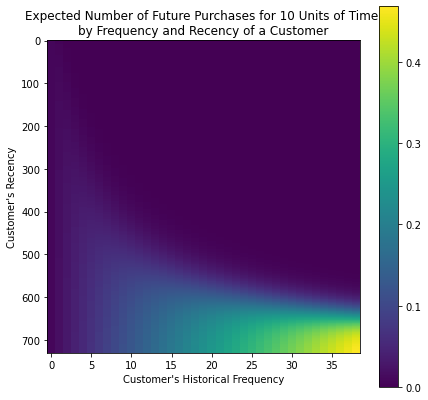

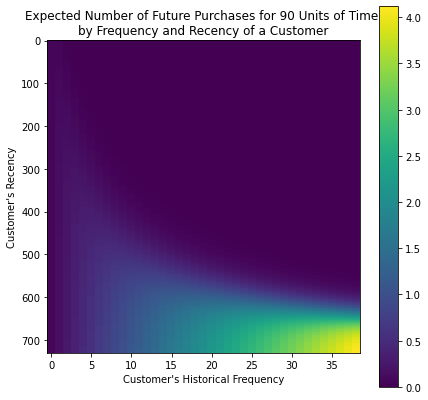

In [27]:

# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);
            
            
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [28]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    
                    
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
customer_id,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9.0,618.0,635.0,59.9,0.1,0.4,0.8,1.1
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6.0,726.0,733.0,103.9,0.1,0.2,0.5,0.7
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5.0,670.0,711.0,80.4,0.1,0.2,0.4,0.6
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,1.0,249.0,312.0,42.3,0.0,0.1,0.2,0.3
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,0.0,0.0,689.0,0.0,0.0,0.0,0.1,0.1
...,...,...,...,...,...,...,...,...
058551aae22c37412da14b7982ac1327ec5e85ddf6413ee96747e45729bfc475,3.0,276.0,417.0,62.1,0.1,0.2,0.4,0.5
0585761bf583cc8468a107690940cfc34e685cb75c6b0ca992ba865d912ee8a3,7.0,594.0,642.0,178.4,0.1,0.3,0.6,0.9
0585981d85cc02082b3f591342a90fab8144c398319ffa45ee72d6e6a598247e,1.0,587.0,641.0,110.1,0.0,0.1,0.1,0.2


In [29]:

# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
customer_id,,,,,,,,
04d03f4289c5ab3ec0572d179988c7ca5ae8012ea35972db7c22210abc532748,10.0,16.0,18.0,101.9,1.0,2.9,5.6,8.1
0574f1efcf6c15c006d5c325190a2d8c435917b2c5f0c73bcebfa423e359d101,10.0,81.0,82.0,48.9,0.6,1.8,3.5,5.2
023ced97d0c6a7aab27dd4d3b6a3258246c72258bc33950ecb9e802bd507f334,8.0,51.0,55.0,68.0,0.6,1.7,3.4,4.9
038cadb73ef70964291fd5781d67050b6c19a02000cd256e058d9de2a55532bc,23.0,336.0,339.0,62.7,0.5,1.6,3.2,4.7
026a8ae78b4352cfddf38a03c072c72f11149bf65dfdd50bc474d6c5b7c46db8,18.0,249.0,254.0,49.4,0.5,1.6,3.1,4.6
0471be61e88d51ee4ba69b2f0c442fba753834f0355eb651fdf8e43680f0db0d,21.0,314.0,325.0,80.2,0.5,1.5,3.0,4.4
0088ac2be49fe6c164930781e72f1330aaa1dd85e67e468947b22dd4bb111bc4,9.0,94.0,98.0,68.9,0.5,1.5,2.9,4.3
011962907f91442ba85ee8c16a5e404398ceb3588b6f592322a4bf858cd92265,19.0,295.0,296.0,32.5,0.5,1.5,3.0,4.4
007ea745333169a47e761ef291dee7839954fa37652781e8df4a63f8e885fe7f,9.0,93.0,98.0,35.0,0.5,1.5,2.9,4.3


CLV

In [30]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
count,"8,350.00","8,350.00","8,350.00","8,350.00","8,350.00","8,350.00","8,350.00","8,350.00"
mean,4.92,357.87,541.14,80.52,0.07,0.22,0.44,0.65
std,4.39,223.62,186.35,65.40,0.07,0.19,0.38,0.57
min,1.00,1.00,6.00,2.69,0.00,0.00,0.00,0.00
25%,2.00,152.00,440.00,42.36,0.03,0.08,0.16,0.23
50%,3.00,371.00,607.00,63.51,0.06,0.17,0.33,0.49
75%,7.00,562.00,695.00,97.12,0.10,0.31,0.62,0.92
max,38.00,730.00,733.00,"1,891.06",1.01,2.92,5.59,8.05


In [31]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: -0.130


In [32]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.412,0.122,3.172,3.651
q,4.185,0.089,4.011,4.359
v,74.669,3.783,67.254,82.083


In [33]:

# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.15


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
customer_id,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9.000,618.000,635.000,59.874,0.129,0.384,0.763,1.136,61.763,59.874,1.889
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6.000,726.000,733.000,103.910,0.078,0.233,0.464,0.692,100.686,103.910,-3.223
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5.000,670.000,711.000,80.386,0.067,0.200,0.399,0.595,80.321,80.386,-0.065
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,1.000,249.000,312.000,42.339,0.039,0.115,0.229,0.342,60.510,42.339,18.172
0000b2f1829e23b24feec422ef13df3ccedaedc85368e6664d04ca30b2f8daff,10.000,677.000,701.000,83.895,0.130,0.388,0.770,1.147,83.560,83.895,-0.335


In [34]:

# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"8,350.000",175.036,160.555,0.004,61.864,133.599,245.811,"2,429.575"
frequency,"8,350.000",4.921,4.391,1.000,2.000,3.000,7.000,38.000
recency,"8,350.000",357.865,223.617,1.000,152.000,371.000,562.000,730.000
T,"8,350.000",541.137,186.355,6.000,440.000,607.000,695.000,733.000
monetary_value,"8,350.000",80.523,65.402,2.695,42.356,63.511,97.119,"1,891.059"
predict_purch_10,"8,350.000",0.074,0.065,0.000,0.026,0.056,0.104,1.008
predict_purch_30,"8,350.000",0.221,0.194,0.000,0.079,0.167,0.311,2.925
predict_purch_60,"8,350.000",0.438,0.383,0.000,0.157,0.331,0.617,5.591
predict_purch_90,"8,350.000",0.652,0.568,0.000,0.234,0.494,0.916,8.052
exp_avg_rev,"8,350.000",79.542,44.270,19.513,52.622,67.514,92.339,"1,314.661"


In [35]:
df_rftv.head(5)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
customer_id,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,256.848,9.000,618.000,635.000,59.874,0.129,0.384,0.763,1.136,61.763,59.874,1.889
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,258.278,6.000,726.000,733.000,103.910,0.078,0.233,0.464,0.692,100.686,103.910,-3.223
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,177.433,5.000,670.000,711.000,80.386,0.067,0.200,0.399,0.595,80.321,80.386,-0.065
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,76.587,1.000,249.000,312.000,42.339,0.039,0.115,0.229,0.342,60.510,42.339,18.172
0000b2f1829e23b24feec422ef13df3ccedaedc85368e6664d04ca30b2f8daff,351.733,10.000,677.000,701.000,83.895,0.130,0.388,0.770,1.147,83.560,83.895,-0.335


In [36]:
final_df = df_rftv.merge(clusters, left_on='customer_id', right_on='customer_id')

In [37]:
final_df.head(5)

,customer_id,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,256.848,9.000,618.000,635.000,59.874,0.129,0.384,0.763,1.136,61.763,59.874,1.889,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,258.278,6.000,726.000,733.000,103.910,0.078,0.233,0.464,0.692,100.686,103.910,-3.223,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,177.433,5.000,670.000,711.000,80.386,0.067,0.200,0.399,0.595,80.321,80.386,-0.065,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,76.587,1.000,249.000,312.000,42.339,0.039,0.115,0.229,0.342,60.510,42.339,18.172,Champions
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,351.733,10.000,677.000,701.000,83.895,0.130,0.388,0.770,1.147,83.560,83.895,-0.335,Champions


In [38]:
import seaborn as sns

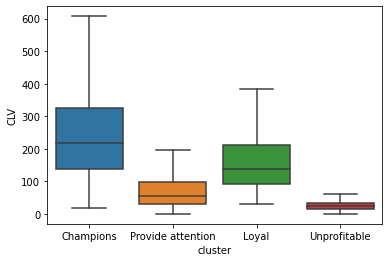

In [39]:
ax = sns.boxplot(x="cluster", y="CLV", data=final_df, showfliers=False)

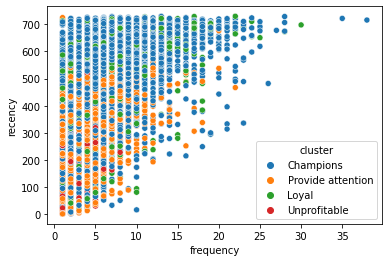

In [40]:
sns.scatterplot(data=final_df, x="frequency", y="recency", hue="cluster")

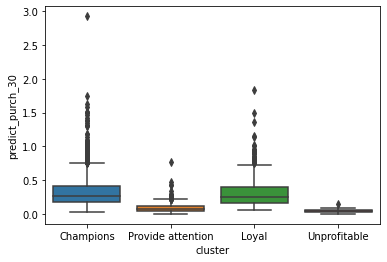

In [41]:
# Boxplot Purchase in the next 30 days 
sns.boxplot(x="cluster", y="predict_purch_30", data=final_df)

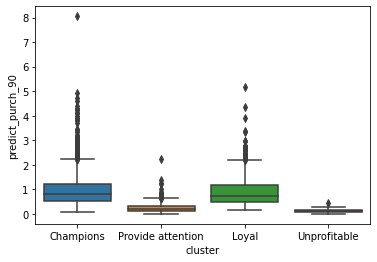

In [42]:
# Boxplot Purchase in the next 90 days 
sns.boxplot(x="cluster", y="predict_purch_90", data=final_df)

In [43]:
champions = final_df[final_df['cluster'] == 'Champions']
attention = final_df[final_df['cluster'] == 'Provide attention']
loyal = final_df[final_df['cluster'] == 'Loyal']
unprofitable = final_df[final_df['cluster'] == 'Unprofitable']

In [44]:
champions.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,"4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000"
mean,254.493,6.214,453.431,516.826,83.835,0.104,0.311,0.617,0.918,81.725,83.835,-2.110
std,172.826,4.827,208.854,204.148,58.910,0.065,0.194,0.382,0.565,41.204,58.910,20.527
min,18.236,1.000,1.000,6.000,6.763,0.008,0.023,0.046,0.068,28.171,6.763,-377.700
25%,138.211,2.000,311.000,370.000,48.548,0.058,0.174,0.345,0.514,54.958,48.548,-3.098
50%,219.087,5.000,520.000,586.000,67.501,0.090,0.268,0.532,0.791,69.710,67.501,1.353
75%,326.305,9.000,624.000,692.000,100.415,0.136,0.407,0.806,1.199,95.647,100.415,4.267
max,"2,429.575",38.000,730.000,733.000,862.203,1.008,2.925,5.591,8.052,484.503,862.203,35.350


In [45]:
attention.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,"2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000"
mean,75.665,3.139,227.876,588.766,88.109,0.027,0.081,0.162,0.241,85.232,88.109,-2.877
std,71.249,2.679,162.278,134.709,78.789,0.019,0.057,0.113,0.168,51.645,78.789,29.461
min,0.004,1.000,1.000,24.000,3.373,0.000,0.000,0.000,0.000,19.513,3.373,-576.399
25%,31.615,1.000,77.000,508.000,43.197,0.013,0.039,0.078,0.116,56.128,43.197,-6.378
50%,56.503,2.000,217.000,638.000,67.763,0.023,0.070,0.140,0.208,71.649,67.763,2.537
75%,97.184,4.000,367.000,699.000,105.631,0.037,0.111,0.221,0.330,98.113,105.631,10.089
max,"1,152.682",22.000,725.000,733.000,"1,891.059",0.256,0.765,1.516,2.256,"1,314.661","1,891.059",36.986


In [46]:
loyal.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000
mean,158.881,5.496,405.167,469.784,46.205,0.103,0.306,0.607,0.902,53.692,46.205,7.487
std,92.442,4.839,220.946,219.960,31.143,0.069,0.205,0.405,0.598,21.723,31.143,12.722
min,29.166,1.000,1.000,6.000,2.864,0.019,0.057,0.113,0.169,21.587,2.864,-126.323
25%,91.051,2.000,219.000,276.750,28.154,0.055,0.164,0.327,0.487,39.887,28.154,2.591
50%,138.245,4.000,455.500,518.500,40.165,0.083,0.249,0.494,0.734,49.454,40.165,5.437
75%,211.521,8.000,596.500,669.000,55.180,0.133,0.398,0.788,1.171,62.056,55.180,12.126
max,892.275,30.000,730.000,733.000,341.593,0.622,1.826,3.546,5.175,215.270,341.593,37.232


In [47]:
unprofitable.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000
mean,27.332,1.997,115.199,615.994,52.283,0.013,0.038,0.076,0.113,62.535,52.283,10.252
std,19.641,1.647,104.404,100.384,42.841,0.007,0.020,0.041,0.061,24.837,42.841,19.437
min,0.018,1.000,1.000,360.000,2.695,0.000,0.000,0.000,0.000,25.174,2.695,-125.030
25%,15.217,1.000,28.000,559.000,25.390,0.008,0.023,0.046,0.069,46.495,25.390,3.842
50%,24.729,1.000,84.000,647.000,40.627,0.013,0.038,0.076,0.114,56.110,40.627,12.416
75%,34.808,2.000,190.000,698.000,66.758,0.017,0.052,0.104,0.155,71.888,66.758,22.263
max,131.476,10.000,529.000,733.000,338.915,0.048,0.144,0.287,0.428,213.885,338.915,37.314


In [48]:
champions.boxplot

<bound method boxplot_frame of                                             customer_id     CLV  frequency  \
0     00000dbacae5abe5e23885899a1fa44253a17956c6d1c3... 256.848      9.000   
1     000058a12d5b43e67d225668fa1f8d618c13dc232df0ca... 258.278      6.000   
2     00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f... 177.433      5.000   
3     0000945f66de1a11d9447609b8b41b1bc987ba185a5496...  76.587      1.000   
4     0000b2f1829e23b24feec422ef13df3ccedaedc85368e6... 351.733     10.000   
...                                                 ...     ...        ...   
8342  0584f4fe53227034c3d36ed4966f927cf2f093411343c5... 179.805     13.000   
8345  058551aae22c37412da14b7982ac1327ec5e85ddf6413e... 132.492      3.000   
8346  0585761bf583cc8468a107690940cfc34e685cb75c6b0c... 536.372      7.000   
8348  0585b160249bbded354f06a87b8a7df1105025e876bf22...  87.440      2.000   
8349  0585cfb04aa3ba76f1f6d8139e28d0ea84e238f5799684... 199.959      3.000   

      recency       T  monetary_

## ML Champions

In [49]:
champ_cluster = clusters[clusters['cluster'] == 'Champions']

In [50]:
champ_df = transactions.copy()

In [51]:
new_champ_df = champ_df[champ_df['customer_id'].isin(champ_cluster['customer_id'])].reset_index(drop=True)[['customer_id','article_id']]

Package `turicreate` only applicable for mac

In [53]:
!pip install turicreate 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 KB 5.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 4.3 MB/s eta 0:00:00


  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13699 sha256=f15439633551571761e0d3d69777c5e1d94e11a1f5050c7c0f72f6afb604180b
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/48/6d/77/9517cb933af254f51a446f1a5ec9c2be3e45f17384940bce68
  Created wheel for resampy: filename=resampy-0.2.1-py3-none-any.whl size=320846 sha256=cd7411343a2a81fa766cce76e6d8ee1330761e3bb98eb19380cd3d9261d6b8da
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/2b/a9/15/89e0e4544c36f50e4e8d54d546f2331c461f505d3b55d3f358
  Created wheel for attr: filename=attr-0.3.1-py3-none-any.whl size=2457 sha256=20ed118eafd9284ca7f66182ce28ccea40b8eca9943468e84213fa5b43d5cf1d
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/47/53/81/061bfd275ab8eb923cfe874f1f6cbe1e607092df09d606c982
Successfully built prettytable resampy attr
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.6.2
    Uninstalling google-auth-2.6.2:
      Suc

In [55]:
import pandas as pd
import numpy as np
import time
import turicreate as tc
from sklearn.model_selection import train_test_split

In [56]:
data = new_champ_df.groupby(['customer_id', 'article_id']).agg({'article_id':'count'}).rename(columns={'article_id': 'count'}).reset_index()

In [63]:
data.head(2)

,customer_id,article_id,count
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023,1
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,2


In [57]:
def create_data_dummy(data):
    data_dummy = data.copy()
    data_dummy['purchase_dummy'] = 1
    return data_dummy
data_dummy = create_data_dummy(data)

In [58]:
def normalize_data(data):
    df_matrix = pd.pivot_table(data, values='count', index='customer_id', columns='article_id')
    df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
    d = df_matrix_norm.reset_index()
    d.index.names = ['scaled_purchase_freq']
    return pd.melt(d, id_vars=['customer_id'], value_name='scaled_purchase_freq').dropna()

In [59]:
data_norm = normalize_data(data)

In [60]:
def split_data(data):
    '''
    Splits dataset into training and test set.
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [61]:
train_data, test_data = split_data(data)
train_data_dummy, test_data_dummy = split_data(data_dummy)
train_data_norm, test_data_norm = split_data(data_norm)

In [64]:
# constant variables to define field names include:
user_id = 'customer_id'
item_id = 'article_id'
users_to_recommend = list(data[user_id])
n_rec = 10 # number of items to recommend
n_display = 30 # to display the first few rows in an output dataset

In [65]:
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
            model = tc.item_similarity_recommender.create(train_data, 
                                                        user_id=user_id, 
                                                        item_id=item_id, 
                                                        target=target, 
                                                        similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

In [68]:
name = 'popularity'
target = 'count'
popularity_model = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 62745 observations with 4987 users and 25631 items.

Data prepared in: 0.106806s

62745 observations to process; with 25631 unique items.

recommendations finished on 1000/78432 queries. users per second: 23223.9

recommendations finished on 2000/78432 queries. users per second: 23254.2

recommendations finished on 3000/78432 queries. users per second: 20434.6

recommendations finished on 4000/78432 queries. users per second: 20098.5

recommendations finished on 5000/78432 queries. users per second: 19499.1

recommendations finished on 6000/78432 queries. users per second: 19305.3

recommendations finished on 7000/78432 queries. users per second: 19201.1

recommendations finished on 8000/78432 queries. users per second: 19509.5

recommendations finished on 9000/78432 queries. users per second: 19286.2

recommendations finished on 10000/78432 queries. users per second: 18561.4

recommendations finished on 11000/78432 queries. users per second: 18157.5

recommendations finished on 12000/78432 queries. users per second: 18130.4

recommendations finished on 13000/78432 queries. users per second: 18089.7

recommendations finished on 14000/78432 queries. users per second: 18233

recommendations finished on 15000/78432 queries. users per second: 18226.7

recommendations finished on 16000/78432 queries. users per second: 17992.8

recommendations finished on 17000/78432 queries. users per second: 17850.5

recommendations finished on 18000/78432 queries. users per second: 17919.9

recommendations finished on 19000/78432 queries. users per second: 17963.1

recommendations finished on 20000/78432 queries. users per second: 18030.3

recommendations finished on 21000/78432 queries. users per second: 18119.8

recommendations finished on 22000/78432 queries. users per second: 18193.4

recommendations finished on 23000/78432 queries. users per second: 18271.5

recommendations finished on 24000/78432 queries. users per second: 18346.9

recommendations finished on 25000/78432 queries. users per second: 18395.2

recommendations finished on 26000/78432 queries. users per second: 18449.8

recommendations finished on 27000/78432 queries. users per second: 18463.9

recommendations finished on 28000/78432 queries. users per second: 18528.3

recommendations finished on 29000/78432 queries. users per second: 18589.8

recommendations finished on 30000/78432 queries. users per second: 18653

recommendations finished on 31000/78432 queries. users per second: 18534.7

recommendations finished on 32000/78432 queries. users per second: 18563.7

recommendations finished on 33000/78432 queries. users per second: 18666.4

recommendations finished on 34000/78432 queries. users per second: 18740.2

recommendations finished on 35000/78432 queries. users per second: 18788.1

recommendations finished on 36000/78432 queries. users per second: 18842.9

recommendations finished on 37000/78432 queries. users per second: 18885.6

recommendations finished on 38000/78432 queries. users per second: 18918

recommendations finished on 39000/78432 queries. users per second: 18950.9

recommendations finished on 40000/78432 queries. users per second: 18970.4

recommendations finished on 41000/78432 queries. users per second: 19020.3

recommendations finished on 42000/78432 queries. users per second: 19056.3

recommendations finished on 43000/78432 queries. users per second: 19089.3

recommendations finished on 44000/78432 queries. users per second: 19128.4

recommendations finished on 45000/78432 queries. users per second: 19153.6

recommendations finished on 46000/78432 queries. users per second: 19185.1

recommendations finished on 47000/78432 queries. users per second: 19224.6

recommendations finished on 48000/78432 queries. users per second: 19247.5

recommendations finished on 49000/78432 queries. users per second: 19302.2

recommendations finished on 50000/78432 queries. users per second: 19355.2

recommendations finished on 51000/78432 queries. users per second: 19338.9

recommendations finished on 52000/78432 queries. users per second: 19332.8

recommendations finished on 53000/78432 queries. users per second: 19317.3

recommendations finished on 54000/78432 queries. users per second: 19294.7

recommendations finished on 55000/78432 queries. users per second: 19255.1

recommendations finished on 56000/78432 queries. users per second: 19268.9

recommendations finished on 57000/78432 queries. users per second: 19309.6

recommendations finished on 58000/78432 queries. users per second: 19321

recommendations finished on 59000/78432 queries. users per second: 19363.9

recommendations finished on 60000/78432 queries. users per second: 19384.2

recommendations finished on 61000/78432 queries. users per second: 19395.8

recommendations finished on 62000/78432 queries. users per second: 19410.5

recommendations finished on 63000/78432 queries. users per second: 19429.3

recommendations finished on 64000/78432 queries. users per second: 19465.6

recommendations finished on 65000/78432 queries. users per second: 19505.5

recommendations finished on 66000/78432 queries. users per second: 19532.7

recommendations finished on 67000/78432 queries. users per second: 19562

recommendations finished on 68000/78432 queries. users per second: 19590.7

recommendations finished on 69000/78432 queries. users per second: 19632.6

recommendations finished on 70000/78432 queries. users per second: 19664.1

recommendations finished on 71000/78432 queries. users per second: 19676.4

recommendations finished on 72000/78432 queries. users per second: 19704.3

recommendations finished on 73000/78432 queries. users per second: 19733.7

recommendations finished on 74000/78432 queries. users per second: 19762

recommendations finished on 75000/78432 queries. users per second: 19757.8

recommendations finished on 76000/78432 queries. users per second: 19709.5

recommendations finished on 77000/78432 queries. users per second: 19731.9

recommendations finished on 78000/78432 queries. users per second: 19730.6

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 921571001  |  7.0  |  1   |
| 00000dbacae5abe5e23885899a... | 779852009  |  6.0  |  2   |
| 00000dbacae5abe5e23885899a... | 571052001  |  5.0  |  3   |
| 00000dbacae5abe5e23885899a... | 800155001  |  5.0  |  4   |
| 00000dbacae5abe5e23885899a... | 545258017  |  5.0  |  5   |
| 00000dbacae5abe5e23885899a... | 341242012  |  5.0  |  6   |
| 00000dbacae5abe5e23885899a... | 695742002  |  5.0  |  7   |
| 00000dbacae5abe5e23885899a... | 692001001  |  5.0  |  8   |
| 00000dbacae5abe5e23885899a... | 782367001  |  5.0  |  9   |
| 00000dbacae5abe5e23885899a... | 725663003  |  5.0  |  10  |
| 00000dbacae5abe5e23885899a... | 921571001  |  7.0  |  1   |
| 00000dbacae5abe5e23885899a... | 779852009  |  6.0  |  2   |
| 00000dbacae5abe5e23885899a... | 571052001  |  5.0  |  3   |
| 00000d

In [69]:
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 62745 observations with 4984 users and 25588 items.

Data prepared in: 0.118736s

62745 observations to process; with 25588 unique items.

recommendations finished on 1000/78432 queries. users per second: 20465

recommendations finished on 2000/78432 queries. users per second: 19404.7

recommendations finished on 3000/78432 queries. users per second: 18336.3

recommendations finished on 4000/78432 queries. users per second: 17887

recommendations finished on 5000/78432 queries. users per second: 17589.5

recommendations finished on 6000/78432 queries. users per second: 17496.5

recommendations finished on 7000/78432 queries. users per second: 17517.7

recommendations finished on 8000/78432 queries. users per second: 17579.2

recommendations finished on 9000/78432 queries. users per second: 17835.2

recommendations finished on 10000/78432 queries. users per second: 18124.5

recommendations finished on 11000/78432 queries. users per second: 18380.9

recommendations finished on 12000/78432 queries. users per second: 18581.8

recommendations finished on 13000/78432 queries. users per second: 18708.9

recommendations finished on 14000/78432 queries. users per second: 18849.1

recommendations finished on 15000/78432 queries. users per second: 18898.3

recommendations finished on 16000/78432 queries. users per second: 18713.6

recommendations finished on 17000/78432 queries. users per second: 18353

recommendations finished on 18000/78432 queries. users per second: 18429.4

recommendations finished on 19000/78432 queries. users per second: 18489.4

recommendations finished on 20000/78432 queries. users per second: 18533.3

recommendations finished on 21000/78432 queries. users per second: 18499.5

recommendations finished on 22000/78432 queries. users per second: 18527.2

recommendations finished on 23000/78432 queries. users per second: 18634.6

recommendations finished on 24000/78432 queries. users per second: 18728.4

recommendations finished on 25000/78432 queries. users per second: 18822

recommendations finished on 26000/78432 queries. users per second: 18939

recommendations finished on 27000/78432 queries. users per second: 18981.4

recommendations finished on 28000/78432 queries. users per second: 19049.1

recommendations finished on 29000/78432 queries. users per second: 19089.1

recommendations finished on 30000/78432 queries. users per second: 19124.8

recommendations finished on 31000/78432 queries. users per second: 19149.7

recommendations finished on 32000/78432 queries. users per second: 19193.9

recommendations finished on 33000/78432 queries. users per second: 19196.8

recommendations finished on 34000/78432 queries. users per second: 19258.8

recommendations finished on 35000/78432 queries. users per second: 19318.4

recommendations finished on 36000/78432 queries. users per second: 19369.9

recommendations finished on 37000/78432 queries. users per second: 19413.9

recommendations finished on 38000/78432 queries. users per second: 19461.9

recommendations finished on 39000/78432 queries. users per second: 19504.2

recommendations finished on 40000/78432 queries. users per second: 19537.8

recommendations finished on 41000/78432 queries. users per second: 19534.6

recommendations finished on 42000/78432 queries. users per second: 19530.7

recommendations finished on 43000/78432 queries. users per second: 19549.4

recommendations finished on 44000/78432 queries. users per second: 19581.1

recommendations finished on 45000/78432 queries. users per second: 19601.9

recommendations finished on 46000/78432 queries. users per second: 19569.7

recommendations finished on 47000/78432 queries. users per second: 19584.8

recommendations finished on 48000/78432 queries. users per second: 19607.7

recommendations finished on 49000/78432 queries. users per second: 19626.2

recommendations finished on 50000/78432 queries. users per second: 19634.7

recommendations finished on 51000/78432 queries. users per second: 19598.7

recommendations finished on 52000/78432 queries. users per second: 19609.7

recommendations finished on 53000/78432 queries. users per second: 19620.9

recommendations finished on 54000/78432 queries. users per second: 19658.4

recommendations finished on 55000/78432 queries. users per second: 19675.8

recommendations finished on 56000/78432 queries. users per second: 19690.3

recommendations finished on 57000/78432 queries. users per second: 19697.9

recommendations finished on 58000/78432 queries. users per second: 19697.8

recommendations finished on 59000/78432 queries. users per second: 19706.6

recommendations finished on 60000/78432 queries. users per second: 19719

recommendations finished on 61000/78432 queries. users per second: 19745.3

recommendations finished on 62000/78432 queries. users per second: 19768.5

recommendations finished on 63000/78432 queries. users per second: 19772.8

recommendations finished on 64000/78432 queries. users per second: 19779.7

recommendations finished on 65000/78432 queries. users per second: 19773.5

recommendations finished on 66000/78432 queries. users per second: 19777.3

recommendations finished on 67000/78432 queries. users per second: 19785.7

recommendations finished on 68000/78432 queries. users per second: 19801.6

recommendations finished on 69000/78432 queries. users per second: 19787.9

recommendations finished on 70000/78432 queries. users per second: 19791.6

recommendations finished on 71000/78432 queries. users per second: 19772.8

recommendations finished on 72000/78432 queries. users per second: 19778.4

recommendations finished on 73000/78432 queries. users per second: 19788

recommendations finished on 74000/78432 queries. users per second: 19809

recommendations finished on 75000/78432 queries. users per second: 19835.4

recommendations finished on 76000/78432 queries. users per second: 19812.3

recommendations finished on 77000/78432 queries. users per second: 19833.3

recommendations finished on 78000/78432 queries. users per second: 19823.3

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 600932001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 872813002  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 631536023  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 759465001  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 663282006  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 640021012  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 832732002  |  1.0  |  7   |
| 00000dbacae5abe5e23885899a... | 708432006  |  1.0  |  8   |
| 00000dbacae5abe5e23885899a... | 809411002  |  1.0  |  9   |
| 00000dbacae5abe5e23885899a... | 786978008  |  1.0  |  10  |
| 00000dbacae5abe5e23885899a... | 600932001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 872813002  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 631536023  |  1.0  |  3   |
| 00000d

In [70]:
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 22990 observations with 4565 users and 4267 items.

Data prepared in: 0.044217s

22990 observations to process; with 4267 unique items.

recommendations finished on 1000/78432 queries. users per second: 119517

recommendations finished on 2000/78432 queries. users per second: 125881

recommendations finished on 3000/78432 queries. users per second: 129971

recommendations finished on 4000/78432 queries. users per second: 127405

recommendations finished on 5000/78432 queries. users per second: 121723

recommendations finished on 6000/78432 queries. users per second: 105647

recommendations finished on 7000/78432 queries. users per second: 107344

recommendations finished on 8000/78432 queries. users per second: 107878

recommendations finished on 9000/78432 queries. users per second: 109998

recommendations finished on 10000/78432 queries. users per second: 110396

recommendations finished on 11000/78432 queries. users per second: 111910

recommendations finished on 12000/78432 queries. users per second: 112158

recommendations finished on 13000/78432 queries. users per second: 104750

recommendations finished on 14000/78432 queries. users per second: 98125.8

recommendations finished on 15000/78432 queries. users per second: 98414.2

recommendations finished on 16000/78432 queries. users per second: 99923.2

recommendations finished on 17000/78432 queries. users per second: 101398

recommendations finished on 18000/78432 queries. users per second: 102776

recommendations finished on 19000/78432 queries. users per second: 104024

recommendations finished on 20000/78432 queries. users per second: 104342

recommendations finished on 21000/78432 queries. users per second: 103658

recommendations finished on 22000/78432 queries. users per second: 103915

recommendations finished on 23000/78432 queries. users per second: 104040

recommendations finished on 24000/78432 queries. users per second: 103410

recommendations finished on 25000/78432 queries. users per second: 103300

recommendations finished on 26000/78432 queries. users per second: 103137

recommendations finished on 27000/78432 queries. users per second: 101184

recommendations finished on 28000/78432 queries. users per second: 100668

recommendations finished on 29000/78432 queries. users per second: 99456.1

recommendations finished on 30000/78432 queries. users per second: 98237

recommendations finished on 31000/78432 queries. users per second: 99062.7

recommendations finished on 32000/78432 queries. users per second: 99108.9

recommendations finished on 33000/78432 queries. users per second: 99618.7

recommendations finished on 34000/78432 queries. users per second: 100320

recommendations finished on 35000/78432 queries. users per second: 99797.6

recommendations finished on 36000/78432 queries. users per second: 99174.4

recommendations finished on 37000/78432 queries. users per second: 98470

recommendations finished on 38000/78432 queries. users per second: 98373.2

recommendations finished on 39000/78432 queries. users per second: 97363.7

recommendations finished on 40000/78432 queries. users per second: 97185.5

recommendations finished on 41000/78432 queries. users per second: 97547.3

recommendations finished on 42000/78432 queries. users per second: 98088.4

recommendations finished on 43000/78432 queries. users per second: 97690.2

recommendations finished on 44000/78432 queries. users per second: 97546.5

recommendations finished on 45000/78432 queries. users per second: 97433

recommendations finished on 46000/78432 queries. users per second: 97136.8

recommendations finished on 47000/78432 queries. users per second: 97166.3

recommendations finished on 48000/78432 queries. users per second: 97420

recommendations finished on 49000/78432 queries. users per second: 97135.3

recommendations finished on 50000/78432 queries. users per second: 96715.9

recommendations finished on 51000/78432 queries. users per second: 96820.1

recommendations finished on 52000/78432 queries. users per second: 96573.7

recommendations finished on 53000/78432 queries. users per second: 96097

recommendations finished on 54000/78432 queries. users per second: 96264.1

recommendations finished on 55000/78432 queries. users per second: 96498.2

recommendations finished on 56000/78432 queries. users per second: 96719.6

recommendations finished on 57000/78432 queries. users per second: 96648.3

recommendations finished on 58000/78432 queries. users per second: 96645.6

recommendations finished on 59000/78432 queries. users per second: 97034.8

recommendations finished on 60000/78432 queries. users per second: 96963.1

recommendations finished on 61000/78432 queries. users per second: 97205.9

recommendations finished on 62000/78432 queries. users per second: 97292.6

recommendations finished on 63000/78432 queries. users per second: 97563.1

recommendations finished on 64000/78432 queries. users per second: 97534.2

recommendations finished on 65000/78432 queries. users per second: 97681.8

recommendations finished on 66000/78432 queries. users per second: 97739.3

recommendations finished on 67000/78432 queries. users per second: 97891.1

recommendations finished on 68000/78432 queries. users per second: 97812.9

recommendations finished on 69000/78432 queries. users per second: 97896.1

recommendations finished on 70000/78432 queries. users per second: 98215.3

recommendations finished on 71000/78432 queries. users per second: 98246.1

recommendations finished on 72000/78432 queries. users per second: 98113.4

recommendations finished on 73000/78432 queries. users per second: 98243.1

recommendations finished on 74000/78432 queries. users per second: 98390.6

recommendations finished on 75000/78432 queries. users per second: 98578.2

recommendations finished on 76000/78432 queries. users per second: 98644.2

recommendations finished on 77000/78432 queries. users per second: 98909

recommendations finished on 78000/78432 queries. users per second: 98853.4

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 859399001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 869691001  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 780204001  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 110065011  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 636587004  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 622444003  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 846782002  |  1.0  |  7   |
| 00000dbacae5abe5e23885899a... | 823025001  |  1.0  |  8   |
| 00000dbacae5abe5e23885899a... | 884972002  |  1.0  |  9   |
| 00000dbacae5abe5e23885899a... | 906293001  |  1.0  |  10  |
| 00000dbacae5abe5e23885899a... | 859399001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 869691001  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 780204001  |  1.0  |  3   |
| 00000d

In [72]:
name = 'cosine'
target = 'count'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 62745 observations with 4987 users and 25631 items.

Data prepared in: 0.113387s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.254ms                        | 20         |

| 3.932ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.41s                               | 0                | 4               |

| 4.67s                               | 100              | 25631           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 5.69568s

recommendations finished on 1000/78432 queries. users per second: 16622.6

recommendations finished on 2000/78432 queries. users per second: 16138.8

recommendations finished on 3000/78432 queries. users per second: 15989.4

recommendations finished on 4000/78432 queries. users per second: 15940.4

recommendations finished on 5000/78432 queries. users per second: 15370.4

recommendations finished on 6000/78432 queries. users per second: 15240.8

recommendations finished on 7000/78432 queries. users per second: 14571.9

recommendations finished on 8000/78432 queries. users per second: 14518.6

recommendations finished on 9000/78432 queries. users per second: 14482

recommendations finished on 10000/78432 queries. users per second: 14534.6

recommendations finished on 11000/78432 queries. users per second: 14551.3

recommendations finished on 12000/78432 queries. users per second: 14567.6

recommendations finished on 13000/78432 queries. users per second: 14575.4

recommendations finished on 14000/78432 queries. users per second: 14619.4

recommendations finished on 15000/78432 queries. users per second: 14718.2

recommendations finished on 16000/78432 queries. users per second: 14763.8

recommendations finished on 17000/78432 queries. users per second: 14844

recommendations finished on 18000/78432 queries. users per second: 14899.8

recommendations finished on 19000/78432 queries. users per second: 14892.4

recommendations finished on 20000/78432 queries. users per second: 14948.8

recommendations finished on 21000/78432 queries. users per second: 15001.4

recommendations finished on 22000/78432 queries. users per second: 15064

recommendations finished on 23000/78432 queries. users per second: 15044.5

recommendations finished on 24000/78432 queries. users per second: 15067.6

recommendations finished on 25000/78432 queries. users per second: 15087.6

recommendations finished on 26000/78432 queries. users per second: 15025.9

recommendations finished on 27000/78432 queries. users per second: 15023.1

recommendations finished on 28000/78432 queries. users per second: 15067.4

recommendations finished on 29000/78432 queries. users per second: 15118

recommendations finished on 30000/78432 queries. users per second: 15122.4

recommendations finished on 31000/78432 queries. users per second: 15137.5

recommendations finished on 32000/78432 queries. users per second: 15105.8

recommendations finished on 33000/78432 queries. users per second: 15128

recommendations finished on 34000/78432 queries. users per second: 15103.7

recommendations finished on 35000/78432 queries. users per second: 15131

recommendations finished on 36000/78432 queries. users per second: 15131.7

recommendations finished on 37000/78432 queries. users per second: 15115.2

recommendations finished on 38000/78432 queries. users per second: 15037.5

recommendations finished on 39000/78432 queries. users per second: 15018

recommendations finished on 40000/78432 queries. users per second: 15051.5

recommendations finished on 41000/78432 queries. users per second: 15042.4

recommendations finished on 42000/78432 queries. users per second: 15072.8

recommendations finished on 43000/78432 queries. users per second: 15109.1

recommendations finished on 44000/78432 queries. users per second: 15135.5

recommendations finished on 45000/78432 queries. users per second: 15167

recommendations finished on 46000/78432 queries. users per second: 15210.7

recommendations finished on 47000/78432 queries. users per second: 15213.5

recommendations finished on 48000/78432 queries. users per second: 15242.4

recommendations finished on 49000/78432 queries. users per second: 15282.5

recommendations finished on 50000/78432 queries. users per second: 15321.3

recommendations finished on 51000/78432 queries. users per second: 15358.3

recommendations finished on 52000/78432 queries. users per second: 15397.7

recommendations finished on 53000/78432 queries. users per second: 15416.2

recommendations finished on 54000/78432 queries. users per second: 15434.4

recommendations finished on 55000/78432 queries. users per second: 15458.6

recommendations finished on 56000/78432 queries. users per second: 15439.3

recommendations finished on 57000/78432 queries. users per second: 15458.5

recommendations finished on 58000/78432 queries. users per second: 15486.9

recommendations finished on 59000/78432 queries. users per second: 15512.2

recommendations finished on 60000/78432 queries. users per second: 15547

recommendations finished on 61000/78432 queries. users per second: 15584.5

recommendations finished on 62000/78432 queries. users per second: 15618.2

recommendations finished on 63000/78432 queries. users per second: 15621.9

recommendations finished on 64000/78432 queries. users per second: 15622.9

recommendations finished on 65000/78432 queries. users per second: 15631.3

recommendations finished on 66000/78432 queries. users per second: 15640.8

recommendations finished on 67000/78432 queries. users per second: 15666.9

recommendations finished on 68000/78432 queries. users per second: 15681.5

recommendations finished on 69000/78432 queries. users per second: 15703.6

recommendations finished on 70000/78432 queries. users per second: 15721

recommendations finished on 71000/78432 queries. users per second: 15689.4

recommendations finished on 72000/78432 queries. users per second: 15696.7

recommendations finished on 73000/78432 queries. users per second: 15686.1

recommendations finished on 74000/78432 queries. users per second: 15675

recommendations finished on 75000/78432 queries. users per second: 15696.3

recommendations finished on 76000/78432 queries. users per second: 15713.6

recommendations finished on 77000/78432 queries. users per second: 15720.6

recommendations finished on 78000/78432 queries. users per second: 15733.5

+-------------------------------+------------+---------------------+------+
|          customer_id          | article_id |        score        | rank |
+-------------------------------+------------+---------------------+------+
| 00000dbacae5abe5e23885899a... | 595200001  | 0.06393395802553963 |  1   |
| 00000dbacae5abe5e23885899a... | 458543009  | 0.06393395802553963 |  2   |
| 00000dbacae5abe5e23885899a... | 802707001  | 0.05261336354648366 |  3   |
| 00000dbacae5abe5e23885899a... | 693746001  | 0.05261336354648366 |  4   |
| 00000dbacae5abe5e23885899a... | 702800001  | 0.05261336354648366 |  5   |
| 00000dbacae5abe5e23885899a... | 666006001  | 0.05261336354648366 |  6   |
| 00000dbacae5abe5e23885899a... | 698255005  | 0.05261336354648366 |  7   |
| 00000dbacae5abe5e23885899a... | 325087045  | 0.05261336354648366 |  8   |
| 00000dbacae5abe5e23885899a... | 747198003  | 0.05260831117630005 |  9   |
| 00000dbacae5abe5e23885899a... | 607310005  | 0.04705882423064288 |  10  |
| 00000dbaca

In [73]:
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 62745 observations with 4984 users and 25588 items.

Data prepared in: 0.098062s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 922us                          | 20         |

| 1.903ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.18s                               | 0                | 13              |

| 3.60s                               | 100              | 25588           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 3.62304s

recommendations finished on 1000/78432 queries. users per second: 18718.2

recommendations finished on 2000/78432 queries. users per second: 18298.8

recommendations finished on 3000/78432 queries. users per second: 17315.3

recommendations finished on 4000/78432 queries. users per second: 17266.5

recommendations finished on 5000/78432 queries. users per second: 17204.7

recommendations finished on 6000/78432 queries. users per second: 17209.8

recommendations finished on 7000/78432 queries. users per second: 17146.6

recommendations finished on 8000/78432 queries. users per second: 17220.4

recommendations finished on 9000/78432 queries. users per second: 17161.8

recommendations finished on 10000/78432 queries. users per second: 17192.2

recommendations finished on 11000/78432 queries. users per second: 17122.3

recommendations finished on 12000/78432 queries. users per second: 17112.7

recommendations finished on 13000/78432 queries. users per second: 17076

recommendations finished on 14000/78432 queries. users per second: 17055.7

recommendations finished on 15000/78432 queries. users per second: 17036.7

recommendations finished on 16000/78432 queries. users per second: 17004.2

recommendations finished on 17000/78432 queries. users per second: 17002

recommendations finished on 18000/78432 queries. users per second: 17041.1

recommendations finished on 19000/78432 queries. users per second: 16537.4

recommendations finished on 20000/78432 queries. users per second: 16593.3

recommendations finished on 21000/78432 queries. users per second: 16645.4

recommendations finished on 22000/78432 queries. users per second: 16721.1

recommendations finished on 23000/78432 queries. users per second: 16774.5

recommendations finished on 24000/78432 queries. users per second: 16782.8

recommendations finished on 25000/78432 queries. users per second: 16780.7

recommendations finished on 26000/78432 queries. users per second: 16816.1

recommendations finished on 27000/78432 queries. users per second: 16798.6

recommendations finished on 28000/78432 queries. users per second: 16768.9

recommendations finished on 29000/78432 queries. users per second: 16787.4

recommendations finished on 30000/78432 queries. users per second: 16802.3

recommendations finished on 31000/78432 queries. users per second: 16816.4

recommendations finished on 32000/78432 queries. users per second: 16721

recommendations finished on 33000/78432 queries. users per second: 16736.2

recommendations finished on 34000/78432 queries. users per second: 16765.1

recommendations finished on 35000/78432 queries. users per second: 16788.2

recommendations finished on 36000/78432 queries. users per second: 16822.8

recommendations finished on 37000/78432 queries. users per second: 16864.1

recommendations finished on 38000/78432 queries. users per second: 16888.4

recommendations finished on 39000/78432 queries. users per second: 16914.8

recommendations finished on 40000/78432 queries. users per second: 16928.6

recommendations finished on 41000/78432 queries. users per second: 16948.8

recommendations finished on 42000/78432 queries. users per second: 16968.6

recommendations finished on 43000/78432 queries. users per second: 16985.9

recommendations finished on 44000/78432 queries. users per second: 17006.4

recommendations finished on 45000/78432 queries. users per second: 17014.5

recommendations finished on 46000/78432 queries. users per second: 17028.5

recommendations finished on 47000/78432 queries. users per second: 17046.1

recommendations finished on 48000/78432 queries. users per second: 17028.4

recommendations finished on 49000/78432 queries. users per second: 17021.7

recommendations finished on 50000/78432 queries. users per second: 17014.5

recommendations finished on 51000/78432 queries. users per second: 16908.1

recommendations finished on 52000/78432 queries. users per second: 16858.3

recommendations finished on 53000/78432 queries. users per second: 16790

recommendations finished on 54000/78432 queries. users per second: 16739.4

recommendations finished on 55000/78432 queries. users per second: 16711.6

recommendations finished on 56000/78432 queries. users per second: 16683.1

recommendations finished on 57000/78432 queries. users per second: 16638.1

recommendations finished on 58000/78432 queries. users per second: 16614.2

recommendations finished on 59000/78432 queries. users per second: 16601.1

recommendations finished on 60000/78432 queries. users per second: 16593.2

recommendations finished on 61000/78432 queries. users per second: 16574.9

recommendations finished on 62000/78432 queries. users per second: 16558.3

recommendations finished on 63000/78432 queries. users per second: 16545.8

recommendations finished on 64000/78432 queries. users per second: 16528

recommendations finished on 65000/78432 queries. users per second: 16509.9

recommendations finished on 66000/78432 queries. users per second: 16507.1

recommendations finished on 67000/78432 queries. users per second: 16496.4

recommendations finished on 68000/78432 queries. users per second: 16466.8

recommendations finished on 69000/78432 queries. users per second: 16449.6

recommendations finished on 70000/78432 queries. users per second: 16473.2

recommendations finished on 71000/78432 queries. users per second: 16499.9

recommendations finished on 72000/78432 queries. users per second: 16525.5

recommendations finished on 73000/78432 queries. users per second: 16552

recommendations finished on 74000/78432 queries. users per second: 16577.9

recommendations finished on 75000/78432 queries. users per second: 16600.1

recommendations finished on 76000/78432 queries. users per second: 16604.4

recommendations finished on 77000/78432 queries. users per second: 16627

recommendations finished on 78000/78432 queries. users per second: 16634.2

+-------------------------------+------------+----------------------+------+
|          customer_id          | article_id |        score         | rank |
+-------------------------------+------------+----------------------+------+
| 00000dbacae5abe5e23885899a... | 595200001  | 0.05856327925409589  |  1   |
| 00000dbacae5abe5e23885899a... | 853089002  | 0.05050762636320932  |  2   |
| 00000dbacae5abe5e23885899a... | 577513001  | 0.05050762636320932  |  3   |
| 00000dbacae5abe5e23885899a... | 795149001  | 0.05050762636320932  |  4   |
| 00000dbacae5abe5e23885899a... | 577513006  | 0.04474758676120213  |  5   |
| 00000dbacae5abe5e23885899a... | 743483002  | 0.04141049299921308  |  6   |
| 00000dbacae5abe5e23885899a... | 790976006  | 0.04141049299921308  |  7   |
| 00000dbacae5abe5e23885899a... | 802554001  | 0.04141049299921308  |  8   |
| 00000dbacae5abe5e23885899a... | 747198003  | 0.037943627153124125 |  9   |
| 00000dbacae5abe5e23885899a... | 618538001  | 0.03571428571428571  |  10  |

In [74]:
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 22990 observations with 4565 users and 4267 items.

Data prepared in: 0.056498s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.026ms                        | 21.75      |

| 1.767ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 47.617ms                            | 0                | 0               |

| 100.691ms                           | 100              | 4267            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.104644s

recommendations finished on 1000/78432 queries. users per second: 99314.7

recommendations finished on 2000/78432 queries. users per second: 104085

recommendations finished on 3000/78432 queries. users per second: 93840.9

recommendations finished on 4000/78432 queries. users per second: 87239.1

recommendations finished on 5000/78432 queries. users per second: 83703

recommendations finished on 6000/78432 queries. users per second: 76844.3

recommendations finished on 7000/78432 queries. users per second: 76140.8

recommendations finished on 8000/78432 queries. users per second: 75473.1

recommendations finished on 9000/78432 queries. users per second: 76703.5

recommendations finished on 10000/78432 queries. users per second: 77821

recommendations finished on 11000/78432 queries. users per second: 77588.3

recommendations finished on 12000/78432 queries. users per second: 78487.3

recommendations finished on 13000/78432 queries. users per second: 78433.7

recommendations finished on 14000/78432 queries. users per second: 77849.6

recommendations finished on 15000/78432 queries. users per second: 76678.1

recommendations finished on 16000/78432 queries. users per second: 77001.6

recommendations finished on 17000/78432 queries. users per second: 77039.9

recommendations finished on 18000/78432 queries. users per second: 75992.3

recommendations finished on 19000/78432 queries. users per second: 76821.1

recommendations finished on 20000/78432 queries. users per second: 77855.2

recommendations finished on 21000/78432 queries. users per second: 77802.8

recommendations finished on 22000/78432 queries. users per second: 78611

recommendations finished on 23000/78432 queries. users per second: 78990.6

recommendations finished on 24000/78432 queries. users per second: 79244

recommendations finished on 25000/78432 queries. users per second: 79101.9

recommendations finished on 26000/78432 queries. users per second: 79322.2

recommendations finished on 27000/78432 queries. users per second: 78993.8

recommendations finished on 28000/78432 queries. users per second: 77479.1

recommendations finished on 29000/78432 queries. users per second: 77636.4

recommendations finished on 30000/78432 queries. users per second: 77704.3

recommendations finished on 31000/78432 queries. users per second: 77579.3

recommendations finished on 32000/78432 queries. users per second: 77673.7

recommendations finished on 33000/78432 queries. users per second: 77715.4

recommendations finished on 34000/78432 queries. users per second: 77755.9

recommendations finished on 35000/78432 queries. users per second: 77716

recommendations finished on 36000/78432 queries. users per second: 77710

recommendations finished on 37000/78432 queries. users per second: 78246.4

recommendations finished on 38000/78432 queries. users per second: 78248.9

recommendations finished on 39000/78432 queries. users per second: 78450.9

recommendations finished on 40000/78432 queries. users per second: 78479.8

recommendations finished on 41000/78432 queries. users per second: 78598.9

recommendations finished on 42000/78432 queries. users per second: 78823.7

recommendations finished on 43000/78432 queries. users per second: 79129.4

recommendations finished on 44000/78432 queries. users per second: 79141.5

recommendations finished on 45000/78432 queries. users per second: 79019.6

recommendations finished on 46000/78432 queries. users per second: 79390.6

recommendations finished on 47000/78432 queries. users per second: 79399

recommendations finished on 48000/78432 queries. users per second: 79431.1

recommendations finished on 49000/78432 queries. users per second: 79681.3

recommendations finished on 50000/78432 queries. users per second: 79799.3

recommendations finished on 51000/78432 queries. users per second: 79676.2

recommendations finished on 52000/78432 queries. users per second: 79782.6

recommendations finished on 53000/78432 queries. users per second: 79754.1

recommendations finished on 54000/78432 queries. users per second: 79783.6

recommendations finished on 55000/78432 queries. users per second: 79719.2

recommendations finished on 56000/78432 queries. users per second: 79847

recommendations finished on 57000/78432 queries. users per second: 80045.7

recommendations finished on 58000/78432 queries. users per second: 80124.3

recommendations finished on 59000/78432 queries. users per second: 80271.1

recommendations finished on 60000/78432 queries. users per second: 80387.9

recommendations finished on 61000/78432 queries. users per second: 80229.1

recommendations finished on 62000/78432 queries. users per second: 80265.2

recommendations finished on 63000/78432 queries. users per second: 79902.4

recommendations finished on 64000/78432 queries. users per second: 79534.3

recommendations finished on 65000/78432 queries. users per second: 79702.2

recommendations finished on 66000/78432 queries. users per second: 79914.3

recommendations finished on 67000/78432 queries. users per second: 79905.8

recommendations finished on 68000/78432 queries. users per second: 80113.7

recommendations finished on 69000/78432 queries. users per second: 80208.9

recommendations finished on 70000/78432 queries. users per second: 79980.1

recommendations finished on 71000/78432 queries. users per second: 79992.4

recommendations finished on 72000/78432 queries. users per second: 80126

recommendations finished on 73000/78432 queries. users per second: 80243.3

recommendations finished on 74000/78432 queries. users per second: 80141.7

recommendations finished on 75000/78432 queries. users per second: 79863.2

recommendations finished on 76000/78432 queries. users per second: 79695.8

recommendations finished on 77000/78432 queries. users per second: 79555.6

recommendations finished on 78000/78432 queries. users per second: 79358.7

+-------------------------------+------------+----------------------+------+
|          customer_id          | article_id |        score         | rank |
+-------------------------------+------------+----------------------+------+
| 00000dbacae5abe5e23885899a... | 678697001  | 0.07071068286895751  |  1   |
| 00000dbacae5abe5e23885899a... | 591334039  | 0.07071068286895751  |  2   |
| 00000dbacae5abe5e23885899a... | 714803003  | 0.07071068286895751  |  3   |
| 00000dbacae5abe5e23885899a... | 741985001  | 0.07071068286895751  |  4   |
| 00000dbacae5abe5e23885899a... | 873678003  | 0.07071068286895751  |  5   |
| 00000dbacae5abe5e23885899a... | 220094001  | 0.07071068286895751  |  6   |
| 00000dbacae5abe5e23885899a... | 767225002  |         0.05         |  7   |
| 00000dbacae5abe5e23885899a... | 842606003  |         0.05         |  8   |
| 00000dbacae5abe5e23885899a... | 735840002  |         0.05         |  9   |
| 00000dbacae5abe5e23885899a... | 610776002  | 0.022360682487487793 |  10  |

In [75]:
name = 'pearson'
target = 'count'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 62745 observations with 4987 users and 25631 items.

Data prepared in: 0.116058s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.136ms                        | 20         |

| 2.946ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.36s                               | 0                | 4               |

| 3.34s                               | 100              | 25631           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 3.36239s

recommendations finished on 1000/78432 queries. users per second: 17620.8

recommendations finished on 2000/78432 queries. users per second: 17522.8

recommendations finished on 3000/78432 queries. users per second: 17559.9

recommendations finished on 4000/78432 queries. users per second: 17405.8

recommendations finished on 5000/78432 queries. users per second: 17150.8

recommendations finished on 6000/78432 queries. users per second: 16944.7

recommendations finished on 7000/78432 queries. users per second: 16624.3

recommendations finished on 8000/78432 queries. users per second: 16579.2

recommendations finished on 9000/78432 queries. users per second: 16634.8

recommendations finished on 10000/78432 queries. users per second: 16711.1

recommendations finished on 11000/78432 queries. users per second: 16760

recommendations finished on 12000/78432 queries. users per second: 16809.7

recommendations finished on 13000/78432 queries. users per second: 16818.4

recommendations finished on 14000/78432 queries. users per second: 16827.4

recommendations finished on 15000/78432 queries. users per second: 16818.9

recommendations finished on 16000/78432 queries. users per second: 16800

recommendations finished on 17000/78432 queries. users per second: 16821.5

recommendations finished on 18000/78432 queries. users per second: 16798.9

recommendations finished on 19000/78432 queries. users per second: 16804.9

recommendations finished on 20000/78432 queries. users per second: 16813.2

recommendations finished on 21000/78432 queries. users per second: 16867.2

recommendations finished on 22000/78432 queries. users per second: 16904.4

recommendations finished on 23000/78432 queries. users per second: 16887.8

recommendations finished on 24000/78432 queries. users per second: 16889

recommendations finished on 25000/78432 queries. users per second: 16900.5

recommendations finished on 26000/78432 queries. users per second: 16886.2

recommendations finished on 27000/78432 queries. users per second: 16859.5

recommendations finished on 28000/78432 queries. users per second: 16870.3

recommendations finished on 29000/78432 queries. users per second: 16870.6

recommendations finished on 30000/78432 queries. users per second: 16831.5

recommendations finished on 31000/78432 queries. users per second: 16781.4

recommendations finished on 32000/78432 queries. users per second: 16762.7

recommendations finished on 33000/78432 queries. users per second: 16755.8

recommendations finished on 34000/78432 queries. users per second: 16767.5

recommendations finished on 35000/78432 queries. users per second: 16690.5

recommendations finished on 36000/78432 queries. users per second: 16706.1

recommendations finished on 37000/78432 queries. users per second: 16716.7

recommendations finished on 38000/78432 queries. users per second: 16720.3

recommendations finished on 39000/78432 queries. users per second: 16660

recommendations finished on 40000/78432 queries. users per second: 16651.3

recommendations finished on 41000/78432 queries. users per second: 16648.4

recommendations finished on 42000/78432 queries. users per second: 16670.7

recommendations finished on 43000/78432 queries. users per second: 16673.7

recommendations finished on 44000/78432 queries. users per second: 16667.4

recommendations finished on 45000/78432 queries. users per second: 16660.8

recommendations finished on 46000/78432 queries. users per second: 16680.7

recommendations finished on 47000/78432 queries. users per second: 16676

recommendations finished on 48000/78432 queries. users per second: 16675.4

recommendations finished on 49000/78432 queries. users per second: 16683.9

recommendations finished on 50000/78432 queries. users per second: 16699.3

recommendations finished on 51000/78432 queries. users per second: 16705.6

recommendations finished on 52000/78432 queries. users per second: 16683.1

recommendations finished on 53000/78432 queries. users per second: 16657.5

recommendations finished on 54000/78432 queries. users per second: 16658.2

recommendations finished on 55000/78432 queries. users per second: 16658.9

recommendations finished on 56000/78432 queries. users per second: 16642.4

recommendations finished on 57000/78432 queries. users per second: 16621

recommendations finished on 58000/78432 queries. users per second: 16615.3

recommendations finished on 59000/78432 queries. users per second: 16605.7

recommendations finished on 60000/78432 queries. users per second: 16617.1

recommendations finished on 61000/78432 queries. users per second: 16638.2

recommendations finished on 62000/78432 queries. users per second: 16650.8

recommendations finished on 63000/78432 queries. users per second: 16657.6

recommendations finished on 64000/78432 queries. users per second: 16660.5

recommendations finished on 65000/78432 queries. users per second: 16666.6

recommendations finished on 66000/78432 queries. users per second: 16657.9

recommendations finished on 67000/78432 queries. users per second: 16661.8

recommendations finished on 68000/78432 queries. users per second: 16667.7

recommendations finished on 69000/78432 queries. users per second: 16683.6

recommendations finished on 70000/78432 queries. users per second: 16700.6

recommendations finished on 71000/78432 queries. users per second: 16717.7

recommendations finished on 72000/78432 queries. users per second: 16732.3

recommendations finished on 73000/78432 queries. users per second: 16747

recommendations finished on 74000/78432 queries. users per second: 16762.4

recommendations finished on 75000/78432 queries. users per second: 16766.7

recommendations finished on 76000/78432 queries. users per second: 16784.3

recommendations finished on 77000/78432 queries. users per second: 16753.5

recommendations finished on 78000/78432 queries. users per second: 16701.1

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 921571001  |  7.0  |  1   |
| 00000dbacae5abe5e23885899a... | 779852009  |  6.0  |  2   |
| 00000dbacae5abe5e23885899a... | 571052001  |  5.0  |  3   |
| 00000dbacae5abe5e23885899a... | 545258017  |  5.0  |  4   |
| 00000dbacae5abe5e23885899a... | 782367001  |  5.0  |  5   |
| 00000dbacae5abe5e23885899a... | 725663003  |  5.0  |  6   |
| 00000dbacae5abe5e23885899a... | 800155001  |  5.0  |  7   |
| 00000dbacae5abe5e23885899a... | 341242012  |  5.0  |  8   |
| 00000dbacae5abe5e23885899a... | 692001001  |  5.0  |  9   |
| 00000dbacae5abe5e23885899a... | 695742002  |  5.0  |  10  |
| 00000dbacae5abe5e23885899a... | 921571001  |  7.0  |  1   |
| 00000dbacae5abe5e23885899a... | 779852009  |  6.0  |  2   |
| 00000dbacae5abe5e23885899a... | 571052001  |  5.0  |  3   |
| 00000d

In [76]:
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 62745 observations with 4984 users and 25588 items.

Data prepared in: 0.085526s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.026ms                        | 20         |

| 2.367ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.03s                               | 0                | 12              |

| 2.71s                               | 100              | 25588           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.72908s

recommendations finished on 1000/78432 queries. users per second: 13827.1

recommendations finished on 2000/78432 queries. users per second: 13460.9

recommendations finished on 3000/78432 queries. users per second: 13288.9

recommendations finished on 4000/78432 queries. users per second: 13201.9

recommendations finished on 5000/78432 queries. users per second: 13161.6

recommendations finished on 6000/78432 queries. users per second: 13088.8

recommendations finished on 7000/78432 queries. users per second: 13058.1

recommendations finished on 8000/78432 queries. users per second: 13070.7

recommendations finished on 9000/78432 queries. users per second: 13054

recommendations finished on 10000/78432 queries. users per second: 13031.1

recommendations finished on 11000/78432 queries. users per second: 13082

recommendations finished on 12000/78432 queries. users per second: 12990.6

recommendations finished on 13000/78432 queries. users per second: 12843.9

recommendations finished on 14000/78432 queries. users per second: 12796.8

recommendations finished on 15000/78432 queries. users per second: 12596.3

recommendations finished on 16000/78432 queries. users per second: 12443.5

recommendations finished on 17000/78432 queries. users per second: 12418.4

recommendations finished on 18000/78432 queries. users per second: 12384.8

recommendations finished on 19000/78432 queries. users per second: 12313.4

recommendations finished on 20000/78432 queries. users per second: 12307.8

recommendations finished on 21000/78432 queries. users per second: 12253.8

recommendations finished on 22000/78432 queries. users per second: 12244.2

recommendations finished on 23000/78432 queries. users per second: 12248.3

recommendations finished on 24000/78432 queries. users per second: 12281.9

recommendations finished on 25000/78432 queries. users per second: 12246.4

recommendations finished on 26000/78432 queries. users per second: 12250.8

recommendations finished on 27000/78432 queries. users per second: 12264.5

recommendations finished on 28000/78432 queries. users per second: 12290.8

recommendations finished on 29000/78432 queries. users per second: 12246

recommendations finished on 30000/78432 queries. users per second: 12202.2

recommendations finished on 31000/78432 queries. users per second: 12185.9

recommendations finished on 32000/78432 queries. users per second: 12147.6

recommendations finished on 33000/78432 queries. users per second: 12168.7

recommendations finished on 34000/78432 queries. users per second: 12200.6

recommendations finished on 35000/78432 queries. users per second: 12229.2

recommendations finished on 36000/78432 queries. users per second: 12254.8

recommendations finished on 37000/78432 queries. users per second: 12273.8

recommendations finished on 38000/78432 queries. users per second: 12261.7

recommendations finished on 39000/78432 queries. users per second: 12270.6

recommendations finished on 40000/78432 queries. users per second: 12288.3

recommendations finished on 41000/78432 queries. users per second: 12272.4

recommendations finished on 42000/78432 queries. users per second: 12251.9

recommendations finished on 43000/78432 queries. users per second: 12220.3

recommendations finished on 44000/78432 queries. users per second: 12210.9

recommendations finished on 45000/78432 queries. users per second: 12153

recommendations finished on 46000/78432 queries. users per second: 12150.5

recommendations finished on 47000/78432 queries. users per second: 12137.4

recommendations finished on 48000/78432 queries. users per second: 12112.3

recommendations finished on 49000/78432 queries. users per second: 12096.1

recommendations finished on 50000/78432 queries. users per second: 12080.9

recommendations finished on 51000/78432 queries. users per second: 12078.5

recommendations finished on 52000/78432 queries. users per second: 12066.9

recommendations finished on 53000/78432 queries. users per second: 12022.9

recommendations finished on 54000/78432 queries. users per second: 11998.3

recommendations finished on 55000/78432 queries. users per second: 11982.1

recommendations finished on 56000/78432 queries. users per second: 11957.1

recommendations finished on 57000/78432 queries. users per second: 11936

recommendations finished on 58000/78432 queries. users per second: 11929.2

recommendations finished on 59000/78432 queries. users per second: 11921.7

recommendations finished on 60000/78432 queries. users per second: 11916.1

recommendations finished on 61000/78432 queries. users per second: 11917.8

recommendations finished on 62000/78432 queries. users per second: 11915.5

recommendations finished on 63000/78432 queries. users per second: 11897.9

recommendations finished on 64000/78432 queries. users per second: 11874.1

recommendations finished on 65000/78432 queries. users per second: 11862

recommendations finished on 66000/78432 queries. users per second: 11863.5

recommendations finished on 67000/78432 queries. users per second: 11866.4

recommendations finished on 68000/78432 queries. users per second: 11861.9

recommendations finished on 69000/78432 queries. users per second: 11844.8

recommendations finished on 70000/78432 queries. users per second: 11836.5

recommendations finished on 71000/78432 queries. users per second: 11839.8

recommendations finished on 72000/78432 queries. users per second: 11841.4

recommendations finished on 73000/78432 queries. users per second: 11836.1

recommendations finished on 74000/78432 queries. users per second: 11828.4

recommendations finished on 75000/78432 queries. users per second: 11821.7

recommendations finished on 76000/78432 queries. users per second: 11805.5

recommendations finished on 77000/78432 queries. users per second: 11800.1

recommendations finished on 78000/78432 queries. users per second: 11803.6

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 600932001  |  0.0  |  1   |
| 00000dbacae5abe5e23885899a... | 872813002  |  0.0  |  2   |
| 00000dbacae5abe5e23885899a... | 631536023  |  0.0  |  3   |
| 00000dbacae5abe5e23885899a... | 759465001  |  0.0  |  4   |
| 00000dbacae5abe5e23885899a... | 663282006  |  0.0  |  5   |
| 00000dbacae5abe5e23885899a... | 640021012  |  0.0  |  6   |
| 00000dbacae5abe5e23885899a... | 832732002  |  0.0  |  7   |
| 00000dbacae5abe5e23885899a... | 708432006  |  0.0  |  8   |
| 00000dbacae5abe5e23885899a... | 809411002  |  0.0  |  9   |
| 00000dbacae5abe5e23885899a... | 786978008  |  0.0  |  10  |
| 00000dbacae5abe5e23885899a... | 600932001  |  0.0  |  1   |
| 00000dbacae5abe5e23885899a... | 872813002  |  0.0  |  2   |
| 00000dbacae5abe5e23885899a... | 631536023  |  0.0  |  3   |
| 00000d

In [77]:
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 22990 observations with 4565 users and 4267 items.

Data prepared in: 0.061161s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.184ms                        | 21.75      |

| 3.069ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 58.108ms                            | 0                | 0               |

| 151.649ms                           | 100              | 4267            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.159986s

recommendations finished on 1000/78432 queries. users per second: 83640

recommendations finished on 2000/78432 queries. users per second: 75665.9

recommendations finished on 3000/78432 queries. users per second: 74497.1

recommendations finished on 4000/78432 queries. users per second: 68682.5

recommendations finished on 5000/78432 queries. users per second: 66175.2

recommendations finished on 6000/78432 queries. users per second: 63345.9

recommendations finished on 7000/78432 queries. users per second: 62578.8

recommendations finished on 8000/78432 queries. users per second: 62886.2

recommendations finished on 9000/78432 queries. users per second: 64948.2

recommendations finished on 10000/78432 queries. users per second: 66503.5

recommendations finished on 11000/78432 queries. users per second: 66526.4

recommendations finished on 12000/78432 queries. users per second: 66355.2

recommendations finished on 13000/78432 queries. users per second: 65531.8

recommendations finished on 14000/78432 queries. users per second: 65262.6

recommendations finished on 15000/78432 queries. users per second: 64728.3

recommendations finished on 16000/78432 queries. users per second: 64650.6

recommendations finished on 17000/78432 queries. users per second: 65529.5

recommendations finished on 18000/78432 queries. users per second: 66155.3

recommendations finished on 19000/78432 queries. users per second: 66912.7

recommendations finished on 20000/78432 queries. users per second: 66897.5

recommendations finished on 21000/78432 queries. users per second: 66873.4

recommendations finished on 22000/78432 queries. users per second: 66917.5

recommendations finished on 23000/78432 queries. users per second: 66894.1

recommendations finished on 24000/78432 queries. users per second: 67193.2

recommendations finished on 25000/78432 queries. users per second: 67031.5

recommendations finished on 26000/78432 queries. users per second: 66266.2

recommendations finished on 27000/78432 queries. users per second: 66338.6

recommendations finished on 28000/78432 queries. users per second: 66310

recommendations finished on 29000/78432 queries. users per second: 66576.7

recommendations finished on 30000/78432 queries. users per second: 66488

recommendations finished on 31000/78432 queries. users per second: 66309.7

recommendations finished on 32000/78432 queries. users per second: 66362.9

recommendations finished on 33000/78432 queries. users per second: 66208.3

recommendations finished on 34000/78432 queries. users per second: 66773.1

recommendations finished on 35000/78432 queries. users per second: 65946.3

recommendations finished on 36000/78432 queries. users per second: 66054

recommendations finished on 37000/78432 queries. users per second: 66497.6

recommendations finished on 38000/78432 queries. users per second: 66571

recommendations finished on 39000/78432 queries. users per second: 66699.4

recommendations finished on 40000/78432 queries. users per second: 66790

recommendations finished on 41000/78432 queries. users per second: 66958.7

recommendations finished on 42000/78432 queries. users per second: 67219.8

recommendations finished on 43000/78432 queries. users per second: 67468.4

recommendations finished on 44000/78432 queries. users per second: 67738.7

recommendations finished on 45000/78432 queries. users per second: 67883.1

recommendations finished on 46000/78432 queries. users per second: 67047.5

recommendations finished on 47000/78432 queries. users per second: 66955.8

recommendations finished on 48000/78432 queries. users per second: 66753.4

recommendations finished on 49000/78432 queries. users per second: 66748.9

recommendations finished on 50000/78432 queries. users per second: 66654

recommendations finished on 51000/78432 queries. users per second: 66538.5

recommendations finished on 52000/78432 queries. users per second: 66241.4

recommendations finished on 53000/78432 queries. users per second: 66022

recommendations finished on 54000/78432 queries. users per second: 65588.6

recommendations finished on 55000/78432 queries. users per second: 65234.7

recommendations finished on 56000/78432 queries. users per second: 64974.6

recommendations finished on 57000/78432 queries. users per second: 64841.8

recommendations finished on 58000/78432 queries. users per second: 64981

recommendations finished on 59000/78432 queries. users per second: 65289.7

recommendations finished on 60000/78432 queries. users per second: 65600.1

recommendations finished on 61000/78432 queries. users per second: 65856.7

recommendations finished on 62000/78432 queries. users per second: 66169.9

recommendations finished on 63000/78432 queries. users per second: 66399.7

recommendations finished on 64000/78432 queries. users per second: 66630.4

recommendations finished on 65000/78432 queries. users per second: 66848.9

recommendations finished on 66000/78432 queries. users per second: 66845.6

recommendations finished on 67000/78432 queries. users per second: 67068.3

recommendations finished on 68000/78432 queries. users per second: 67087.1

recommendations finished on 69000/78432 queries. users per second: 67261.8

recommendations finished on 70000/78432 queries. users per second: 67570

recommendations finished on 71000/78432 queries. users per second: 67668.7

recommendations finished on 72000/78432 queries. users per second: 67819.7

recommendations finished on 73000/78432 queries. users per second: 67943.9

recommendations finished on 74000/78432 queries. users per second: 68193.7

recommendations finished on 75000/78432 queries. users per second: 68359.9

recommendations finished on 76000/78432 queries. users per second: 68537.9

recommendations finished on 77000/78432 queries. users per second: 68650.5

recommendations finished on 78000/78432 queries. users per second: 68345.5

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 859399001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 869691001  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 780204001  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 110065011  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 636587004  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 622444003  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 846782002  |  1.0  |  7   |
| 00000dbacae5abe5e23885899a... | 823025001  |  1.0  |  8   |
| 00000dbacae5abe5e23885899a... | 884972002  |  1.0  |  9   |
| 00000dbacae5abe5e23885899a... | 906293001  |  1.0  |  10  |
| 00000dbacae5abe5e23885899a... | 859399001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 869691001  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 780204001  |  1.0  |  3   |
| 00000d

In [78]:
models_w_counts = [popularity_model, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]
names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

In [79]:
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/4259 queries. users per second: 18861.2

recommendations finished on 2000/4259 queries. users per second: 15547.9

recommendations finished on 3000/4259 queries. users per second: 15441.6

recommendations finished on 4000/4259 queries. users per second: 15705.6


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    |          0.0           |          0.0           |
|   5    |          0.0           |          0.0           |
|   6    |          0.0           |          0.0           |
|   7    | 3.354241438298729e-05  | 0.00011739845034045554 |
|   8    | 2.9349612585113884e-05 | 0.00011739845034045554 |
|   9    | 2.6088544520101214e-05 | 0.00011739845034045554 |
|   10   | 2.3479690068091106e-05 | 0.00011739845034045554 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4502647003664836

Per User RMSE (best)
+---------------

recommendations finished on 1000/4259 queries. users per second: 9471.22

recommendations finished on 2000/4259 queries. users per second: 10139.7

recommendations finished on 3000/4259 queries. users per second: 11195

recommendations finished on 4000/4259 queries. users per second: 12130


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.007748297722470065 | 0.0035714285714285704 |
|   2    |  0.004461141112937313 |  0.003794959964248525 |
|   3    |  0.003835016044454888 |  0.004523762090092213 |
|   4    |  0.003463254285043438 |  0.005372944214221509 |
|   5    | 0.0031932378492603862 |  0.005899932813527551 |
|   6    |  0.003091492525631993 |  0.006905646204777454 |
|   7    |  0.002817562808170931 |  0.007314863660249904 |
|   8    |  0.002758863583000703 |  0.008066213742428816 |
|   9    | 0.0026871200855704204 |  0.009158019330595051 |
|   10   |  0.002629725287626197 |  0.009845452478699722 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.1844385660407584

Per User RMSE (best)
+-------------------------------+------+----

recommendations finished on 1000/4259 queries. users per second: 14233.3

recommendations finished on 2000/4259 queries. users per second: 12848.5

recommendations finished on 3000/4259 queries. users per second: 13177.9

recommendations finished on 4000/4259 queries. users per second: 13180.3


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    |          0.0           |          0.0           |
|   5    |          0.0           |          0.0           |
|   6    | 3.913281678015181e-05  | 0.00011739845034045554 |
|   7    | 3.354241438298729e-05  | 0.00011739845034045554 |
|   8    | 2.9349612585113884e-05 | 0.00011739845034045554 |
|   9    | 2.6088544520101286e-05 | 0.00011739845034045554 |
|   10   | 2.3479690068091086e-05 | 0.00011739845034045554 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6772750221238035

Per User RMSE (best)
+---------------

recommendations finished on 1000/4226 queries. users per second: 20139.4

recommendations finished on 2000/4226 queries. users per second: 19462.6

recommendations finished on 3000/4226 queries. users per second: 19328.2

recommendations finished on 4000/4226 queries. users per second: 19332.6


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    | 5.9157595835305265e-05 | 0.00011831519167061053 |
|   5    | 0.0001893043066729768  | 0.00046762670993622283 |
|   6    |  0.000236630383341221  | 0.0005277233152292312  |
|   7    | 0.00037184774525049003 |  0.001119299273582285  |
|   8    | 0.00035494557501183156 | 0.0011981760680293582  |
|   9    | 0.0003155071777882947  | 0.0011981760680293589  |
|   10   | 0.00028395646000946534 | 0.0011981760680293578  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+------------------------------

recommendations finished on 1000/4226 queries. users per second: 14987.1

recommendations finished on 2000/4226 queries. users per second: 14962.9

recommendations finished on 3000/4226 queries. users per second: 14453

recommendations finished on 4000/4226 queries. users per second: 14486.7


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.011594888783719837 | 0.00598393167015978  |
|   2    |  0.006980596308566019 | 0.006751571901832194 |
|   3    |  0.004811484461271489 | 0.006929044689338109 |
|   4    |  0.00408187411263606  | 0.007433856173799385 |
|   5    | 0.0036914339801230453 | 0.008175579744439181 |
|   6    |  0.003391702161224164 | 0.008977291573126888 |
|   7    | 0.0032452166858224583 | 0.009730564960096433 |
|   8    |  0.002928300993847611 | 0.009827846339914502 |
|   9    | 0.0029184413945417213 | 0.010964892892247363 |
|   10   |  0.002815901561760526 | 0.011732251421082479 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9974441774437156

Per User RMSE (best)
+-------------------------------+--------------------+----

recommendations finished on 1000/4226 queries. users per second: 8219.83

recommendations finished on 2000/4226 queries. users per second: 7940.51

recommendations finished on 3000/4226 queries. users per second: 8588.65

recommendations finished on 4000/4226 queries. users per second: 9252.17


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    | 5.9157595835305265e-05 | 0.00011831519167061053 |
|   5    | 0.00018930430667297673 | 0.0004676267099362225  |
|   6    | 0.00023663038334122106 | 0.0005277233152292311  |
|   7    | 0.00037184774525048976 | 0.0011192992735822836  |
|   8    | 0.0003549455750118319  |  0.001198176068029358  |
|   9    | 0.00031550717778829475 | 0.0011981760680293567  |
|   10   | 0.0002839564600094653  | 0.0011981760680293573  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------------------------

recommendations finished on 1000/3003 queries. users per second: 68385.4

recommendations finished on 2000/3003 queries. users per second: 73022

recommendations finished on 3000/3003 queries. users per second: 58767.1


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 0.00033300033300033284 | 0.00019425019425019425 |
|   3    | 0.00044400044400044405 | 0.0004273504273504275  |
|   4    | 0.00041625041625041625 | 0.0007603507603507609  |
|   5    | 0.00033300033300033273 | 0.0007603507603507608  |
|   6    | 0.0003330003330003328  | 0.0010933510933510936  |
|   7    | 0.00028542885685742844 | 0.0010933510933510944  |
|   8    | 0.00029137529137529143 | 0.0012043512043512057  |
|   9    | 0.00033300033300033273 |  0.001603951603951604  |
|   10   |  0.000333000333000333  | 0.0017149517149517147  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4991272676291381

Per User RMSE (best)
+---------------

recommendations finished on 1000/3003 queries. users per second: 78277.9

recommendations finished on 2000/3003 queries. users per second: 79754.4

recommendations finished on 3000/3003 queries. users per second: 64807.4


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.004995004995004998 | 0.0027306027306027293 |
|   2    |  0.003663003663003663 |  0.004073704073704078 |
|   3    |  0.002886002886002885 |  0.00465645465645466  |
|   4    |  0.002580752580752582 |  0.00571095571095571  |
|   5    |  0.002464202464202465 |  0.006931956931956932 |
|   6    |  0.002442002442002444 |  0.008069708069708074 |
|   7    |  0.002473716759431048 |  0.009443334443334433 |
|   8    |  0.002622377622377624 |  0.01120268620268619  |
|   9    | 0.0025530025530025474 |  0.012601287601287607 |
|   10   |  0.002497502497502495 |  0.013511488511488515 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4431203144083287

Per User RMSE (best)
+-------------------------------+------+----

recommendations finished on 1000/3003 queries. users per second: 60672.2

recommendations finished on 2000/3003 queries. users per second: 61633.3

recommendations finished on 3000/3003 queries. users per second: 49009.2


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.00033300033300033305 | 8.325008325008326e-05 |
|   2    | 0.00033300033300033305 | 0.0004162504162504163 |
|   3    |  0.000333000333000333  | 0.0005827505827505823 |
|   4    | 0.00033300033300033305 |  0.000915750915750917 |
|   5    | 0.0002664002664002668  | 0.0009157509157509162 |
|   6    | 0.00027750027750027755 | 0.0012487512487512494 |
|   7    | 0.00033300033300033316 |  0.001692751692751693 |
|   8    | 0.0003330003330003334  | 0.0018037518037518048 |
|   9    | 0.00029600029600029614 | 0.0018037518037518044 |
|   10   | 0.0002997002997002999  |  0.001914751914751915 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5008636526594525

Per User RMSE (best)
+-----------------------------

#### BASE ON EVAL CHOOSE BEST MODEL

In [84]:
def create_output(model, users_to_recommend, n_rec, print_csv=True):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id] \
        .transform(lambda x: '|'.join(x.astype(str)))
    df_output = df_rec[['customer_id', 'recommendedProducts']].drop_duplicates() \
        .sort_values('customer_id').set_index('customer_id')
    if print_csv:
        df_output.to_csv('option1_recommendation.csv')
        print("An output file can be found in 'output' folder with name 'option1_recommendation.csv'")
    return df_output

In [85]:
df_output = create_output(pear_norm, users_to_recommend, n_rec, print_csv=True)
print(df_output.shape)
df_output.head()

recommendations finished on 1000/78432 queries. users per second: 98174

recommendations finished on 2000/78432 queries. users per second: 101569

recommendations finished on 3000/78432 queries. users per second: 103555

recommendations finished on 4000/78432 queries. users per second: 102249

recommendations finished on 5000/78432 queries. users per second: 101356

recommendations finished on 6000/78432 queries. users per second: 89548.2

recommendations finished on 7000/78432 queries. users per second: 87599.6

recommendations finished on 8000/78432 queries. users per second: 87559.9

recommendations finished on 9000/78432 queries. users per second: 88054

recommendations finished on 10000/78432 queries. users per second: 88677.6

recommendations finished on 11000/78432 queries. users per second: 88812.1

recommendations finished on 12000/78432 queries. users per second: 81009.9

recommendations finished on 13000/78432 queries. users per second: 78770.7

recommendations finished on 14000/78432 queries. users per second: 79015.7

recommendations finished on 15000/78432 queries. users per second: 78324.9

recommendations finished on 16000/78432 queries. users per second: 78541.5

recommendations finished on 17000/78432 queries. users per second: 78674.2

recommendations finished on 18000/78432 queries. users per second: 78318.8

recommendations finished on 19000/78432 queries. users per second: 78891.2

recommendations finished on 20000/78432 queries. users per second: 78223.1

recommendations finished on 21000/78432 queries. users per second: 77927.3

recommendations finished on 22000/78432 queries. users per second: 77255.9

recommendations finished on 23000/78432 queries. users per second: 76346

recommendations finished on 24000/78432 queries. users per second: 74743.3

recommendations finished on 25000/78432 queries. users per second: 74081.8

recommendations finished on 26000/78432 queries. users per second: 73261.5

recommendations finished on 27000/78432 queries. users per second: 73621

recommendations finished on 28000/78432 queries. users per second: 74078

recommendations finished on 29000/78432 queries. users per second: 74749.8

recommendations finished on 30000/78432 queries. users per second: 74439.7

recommendations finished on 31000/78432 queries. users per second: 73943.3

recommendations finished on 32000/78432 queries. users per second: 74309.9

recommendations finished on 33000/78432 queries. users per second: 74048

recommendations finished on 34000/78432 queries. users per second: 74191.1

recommendations finished on 35000/78432 queries. users per second: 74147.2

recommendations finished on 36000/78432 queries. users per second: 74062.9

recommendations finished on 37000/78432 queries. users per second: 73978.1

recommendations finished on 38000/78432 queries. users per second: 73877.9

recommendations finished on 39000/78432 queries. users per second: 73734.7

recommendations finished on 40000/78432 queries. users per second: 73819.7

recommendations finished on 41000/78432 queries. users per second: 73708.5

recommendations finished on 42000/78432 queries. users per second: 73493.3

recommendations finished on 43000/78432 queries. users per second: 73488.1

recommendations finished on 44000/78432 queries. users per second: 73354.7

recommendations finished on 45000/78432 queries. users per second: 73325.4

recommendations finished on 46000/78432 queries. users per second: 73668.2

recommendations finished on 47000/78432 queries. users per second: 73769.3

recommendations finished on 48000/78432 queries. users per second: 73936.8

recommendations finished on 49000/78432 queries. users per second: 73879.2

recommendations finished on 50000/78432 queries. users per second: 73664.3

recommendations finished on 51000/78432 queries. users per second: 73565

recommendations finished on 52000/78432 queries. users per second: 73391.9

recommendations finished on 53000/78432 queries. users per second: 72846.7

recommendations finished on 54000/78432 queries. users per second: 72894.4

recommendations finished on 55000/78432 queries. users per second: 72970.3

recommendations finished on 56000/78432 queries. users per second: 73036.6

recommendations finished on 57000/78432 queries. users per second: 73103.1

recommendations finished on 58000/78432 queries. users per second: 73264.2

recommendations finished on 59000/78432 queries. users per second: 73405.5

recommendations finished on 60000/78432 queries. users per second: 73464.8

recommendations finished on 61000/78432 queries. users per second: 73375

recommendations finished on 62000/78432 queries. users per second: 73431.9

recommendations finished on 63000/78432 queries. users per second: 73652.9

recommendations finished on 64000/78432 queries. users per second: 73565

recommendations finished on 65000/78432 queries. users per second: 73689.2

recommendations finished on 66000/78432 queries. users per second: 73745.7

recommendations finished on 67000/78432 queries. users per second: 73870.6

recommendations finished on 68000/78432 queries. users per second: 73525.8

recommendations finished on 69000/78432 queries. users per second: 72470.8

recommendations finished on 70000/78432 queries. users per second: 72162.3

recommendations finished on 71000/78432 queries. users per second: 71965.3

recommendations finished on 72000/78432 queries. users per second: 71718.4

recommendations finished on 73000/78432 queries. users per second: 71281.1

recommendations finished on 74000/78432 queries. users per second: 70597.5

recommendations finished on 75000/78432 queries. users per second: 70401.8

recommendations finished on 76000/78432 queries. users per second: 70474.5

recommendations finished on 77000/78432 queries. users per second: 70673.1

recommendations finished on 78000/78432 queries. users per second: 70821

An output file can be found in 'output' folder with name 'option1_recommendation.csv'
(5005, 1)


,recommendedProducts
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,859399001|869691001|780204001|110065011|636587...
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,859399001|869691001|780204001|110065011|636587...
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,859399001|869691001|780204001|110065011|636587...
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,859399001|869691001|780204001|110065011|636587...
0000b2f1829e23b24feec422ef13df3ccedaedc85368e6664d04ca30b2f8daff,859399001|869691001|780204001|110065011|636587...


In [86]:
def customer_recomendation(customer_id):
    if customer_id not in df_output.index:
        print('Customer not found.')
        return customer_id
    return df_output.loc[customer_id]

## ML Across All Segments

In [90]:
ml_df = transactions.copy()

In [91]:
new_cluster_df = ml_df[ml_df['customer_id'].isin(clusters['customer_id'])].reset_index(drop=True)[['customer_id','article_id']]

In [92]:
data = new_cluster_df.groupby(['customer_id', 'article_id']).agg({'article_id':'count'}).rename(columns={'article_id': 'count'}).reset_index()

In [93]:
data_dummy = create_data_dummy(data)
data_norm = normalize_data(data)

In [94]:
train_data, test_data = split_data(data)
train_data_dummy, test_data_dummy = split_data(data_dummy)
train_data_norm, test_data_norm = split_data(data_norm)

In [95]:
user_id = 'customer_id'
item_id = 'article_id'
users_to_recommend = list(data[user_id])
n_rec = 6 # number of items to recommend
n_display = 30 # to display the first few rows in an output dataset

#### Popularity

In [96]:
name = 'popularity'
target = 'count'
popularity_model = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 109953 observations with 12606 users and 35445 items.

Data prepared in: 0.228643s

109953 observations to process; with 35445 unique items.

recommendations finished on 1000/137442 queries. users per second: 15828.3

recommendations finished on 2000/137442 queries. users per second: 14779.3

recommendations finished on 3000/137442 queries. users per second: 14248

recommendations finished on 4000/137442 queries. users per second: 13713.8

recommendations finished on 5000/137442 queries. users per second: 13692.6

recommendations finished on 6000/137442 queries. users per second: 13670.3

recommendations finished on 7000/137442 queries. users per second: 13677.2

recommendations finished on 8000/137442 queries. users per second: 13207.4

recommendations finished on 9000/137442 queries. users per second: 12772.9

recommendations finished on 10000/137442 queries. users per second: 12760.7

recommendations finished on 11000/137442 queries. users per second: 12747.1

recommendations finished on 12000/137442 queries. users per second: 12420.5

recommendations finished on 13000/137442 queries. users per second: 12155.1

recommendations finished on 14000/137442 queries. users per second: 10994.7

recommendations finished on 15000/137442 queries. users per second: 10604.5

recommendations finished on 16000/137442 queries. users per second: 10415.4

recommendations finished on 17000/137442 queries. users per second: 10290.5

recommendations finished on 18000/137442 queries. users per second: 10338.9

recommendations finished on 19000/137442 queries. users per second: 10329.2

recommendations finished on 20000/137442 queries. users per second: 10357.6

recommendations finished on 21000/137442 queries. users per second: 10374.8

recommendations finished on 22000/137442 queries. users per second: 10437.6

recommendations finished on 23000/137442 queries. users per second: 10520.4

recommendations finished on 24000/137442 queries. users per second: 10600.4

recommendations finished on 25000/137442 queries. users per second: 10640.6

recommendations finished on 26000/137442 queries. users per second: 10677.9

recommendations finished on 27000/137442 queries. users per second: 10713.9

recommendations finished on 28000/137442 queries. users per second: 10785.6

recommendations finished on 29000/137442 queries. users per second: 10863

recommendations finished on 30000/137442 queries. users per second: 10934.7

recommendations finished on 31000/137442 queries. users per second: 11004.7

recommendations finished on 32000/137442 queries. users per second: 11071.9

recommendations finished on 33000/137442 queries. users per second: 11116.9

recommendations finished on 34000/137442 queries. users per second: 11154.7

recommendations finished on 35000/137442 queries. users per second: 11194.1

recommendations finished on 36000/137442 queries. users per second: 11243.3

recommendations finished on 37000/137442 queries. users per second: 11291.6

recommendations finished on 38000/137442 queries. users per second: 11300.9

recommendations finished on 39000/137442 queries. users per second: 11323.2

recommendations finished on 40000/137442 queries. users per second: 11317.7

recommendations finished on 41000/137442 queries. users per second: 11333.5

recommendations finished on 42000/137442 queries. users per second: 11372.7

recommendations finished on 43000/137442 queries. users per second: 11418.5

recommendations finished on 44000/137442 queries. users per second: 11457.2

recommendations finished on 45000/137442 queries. users per second: 11504.1

recommendations finished on 46000/137442 queries. users per second: 11552.6

recommendations finished on 47000/137442 queries. users per second: 11602.7

recommendations finished on 48000/137442 queries. users per second: 11657.2

recommendations finished on 49000/137442 queries. users per second: 11707

recommendations finished on 50000/137442 queries. users per second: 11750.5

recommendations finished on 51000/137442 queries. users per second: 11797.3

recommendations finished on 52000/137442 queries. users per second: 11813.5

recommendations finished on 53000/137442 queries. users per second: 11871.6

recommendations finished on 54000/137442 queries. users per second: 11927

recommendations finished on 55000/137442 queries. users per second: 11983.3

recommendations finished on 56000/137442 queries. users per second: 12034

recommendations finished on 57000/137442 queries. users per second: 12081.3

recommendations finished on 58000/137442 queries. users per second: 12131.7

recommendations finished on 59000/137442 queries. users per second: 12182.5

recommendations finished on 60000/137442 queries. users per second: 12231.5

recommendations finished on 61000/137442 queries. users per second: 12259.4

recommendations finished on 62000/137442 queries. users per second: 12290.5

recommendations finished on 63000/137442 queries. users per second: 12329.9

recommendations finished on 64000/137442 queries. users per second: 12355.1

recommendations finished on 65000/137442 queries. users per second: 12387.6

recommendations finished on 66000/137442 queries. users per second: 12424.9

recommendations finished on 67000/137442 queries. users per second: 12449.2

recommendations finished on 68000/137442 queries. users per second: 12466

recommendations finished on 69000/137442 queries. users per second: 12485.4

recommendations finished on 70000/137442 queries. users per second: 12496.2

recommendations finished on 71000/137442 queries. users per second: 12522.1

recommendations finished on 72000/137442 queries. users per second: 12545.1

recommendations finished on 73000/137442 queries. users per second: 12580.1

recommendations finished on 74000/137442 queries. users per second: 12614.6

recommendations finished on 75000/137442 queries. users per second: 12650.5

recommendations finished on 76000/137442 queries. users per second: 12680.1

recommendations finished on 77000/137442 queries. users per second: 12704.1

recommendations finished on 78000/137442 queries. users per second: 12717.8

recommendations finished on 79000/137442 queries. users per second: 12739.2

recommendations finished on 80000/137442 queries. users per second: 12773.2

recommendations finished on 81000/137442 queries. users per second: 12804.9

recommendations finished on 82000/137442 queries. users per second: 12833.8

recommendations finished on 83000/137442 queries. users per second: 12860.4

recommendations finished on 84000/137442 queries. users per second: 12880.5

recommendations finished on 85000/137442 queries. users per second: 12899.8

recommendations finished on 86000/137442 queries. users per second: 12924.6

recommendations finished on 87000/137442 queries. users per second: 12945.3

recommendations finished on 88000/137442 queries. users per second: 12958.3

recommendations finished on 89000/137442 queries. users per second: 12974.3

recommendations finished on 90000/137442 queries. users per second: 12993.8

recommendations finished on 91000/137442 queries. users per second: 13014.6

recommendations finished on 92000/137442 queries. users per second: 13039.2

recommendations finished on 93000/137442 queries. users per second: 13056.9

recommendations finished on 94000/137442 queries. users per second: 13077.2

recommendations finished on 95000/137442 queries. users per second: 13100.1

recommendations finished on 96000/137442 queries. users per second: 13121.8

recommendations finished on 97000/137442 queries. users per second: 13142

recommendations finished on 98000/137442 queries. users per second: 13165.5

recommendations finished on 99000/137442 queries. users per second: 13137.8

recommendations finished on 100000/137442 queries. users per second: 13151.8

recommendations finished on 101000/137442 queries. users per second: 13170.9

recommendations finished on 102000/137442 queries. users per second: 13188.8

recommendations finished on 103000/137442 queries. users per second: 13208.5

recommendations finished on 104000/137442 queries. users per second: 13230.6

recommendations finished on 105000/137442 queries. users per second: 13251.7

recommendations finished on 106000/137442 queries. users per second: 13262.7

recommendations finished on 107000/137442 queries. users per second: 13277.4

recommendations finished on 108000/137442 queries. users per second: 13293.2

recommendations finished on 109000/137442 queries. users per second: 13311.1

recommendations finished on 110000/137442 queries. users per second: 13330.8

recommendations finished on 111000/137442 queries. users per second: 13352.8

recommendations finished on 112000/137442 queries. users per second: 13373.1

recommendations finished on 113000/137442 queries. users per second: 13393.7

recommendations finished on 114000/137442 queries. users per second: 13413

recommendations finished on 115000/137442 queries. users per second: 13426

recommendations finished on 116000/137442 queries. users per second: 13437.5

recommendations finished on 117000/137442 queries. users per second: 13448.1

recommendations finished on 118000/137442 queries. users per second: 13465.4

recommendations finished on 119000/137442 queries. users per second: 13475.7

recommendations finished on 120000/137442 queries. users per second: 13482.5

recommendations finished on 121000/137442 queries. users per second: 13493.9

recommendations finished on 122000/137442 queries. users per second: 13504.1

recommendations finished on 123000/137442 queries. users per second: 13515

recommendations finished on 124000/137442 queries. users per second: 13525.1

recommendations finished on 125000/137442 queries. users per second: 13537.9

recommendations finished on 126000/137442 queries. users per second: 13552.5

recommendations finished on 127000/137442 queries. users per second: 13566.8

recommendations finished on 128000/137442 queries. users per second: 13580.6

recommendations finished on 129000/137442 queries. users per second: 13594.7

recommendations finished on 130000/137442 queries. users per second: 13608.6

recommendations finished on 131000/137442 queries. users per second: 13620.7

recommendations finished on 132000/137442 queries. users per second: 13629.6

recommendations finished on 133000/137442 queries. users per second: 13640.6

recommendations finished on 134000/137442 queries. users per second: 13649.6

recommendations finished on 135000/137442 queries. users per second: 13659.8

recommendations finished on 136000/137442 queries. users per second: 13668.2

recommendations finished on 137000/137442 queries. users per second: 13675.1

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 687369003  |  9.0  |  1   |
| 00000dbacae5abe5e23885899a... | 687369002  |  7.0  |  2   |
| 00000dbacae5abe5e23885899a... | 743768003  |  7.0  |  3   |
| 00000dbacae5abe5e23885899a... | 530953014  |  5.0  |  4   |
| 00000dbacae5abe5e23885899a... | 545258017  |  5.0  |  5   |
| 00000dbacae5abe5e23885899a... | 628813006  |  5.0  |  6   |
| 00000dbacae5abe5e23885899a... | 687369003  |  9.0  |  1   |
| 00000dbacae5abe5e23885899a... | 687369002  |  7.0  |  2   |
| 00000dbacae5abe5e23885899a... | 743768003  |  7.0  |  3   |
| 00000dbacae5abe5e23885899a... | 530953014  |  5.0  |  4   |
| 00000dbacae5abe5e23885899a... | 545258017  |  5.0  |  5   |
| 00000dbacae5abe5e23885899a... | 628813006  |  5.0  |  6   |
| 00000dbacae5abe5e23885899a... | 687369003  |  9.0  |  1   |
| 00000d

In [97]:
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 109953 observations with 12555 users and 35387 items.

Data prepared in: 0.165424s

109953 observations to process; with 35387 unique items.

recommendations finished on 1000/137442 queries. users per second: 16035.1

recommendations finished on 2000/137442 queries. users per second: 14429.2

recommendations finished on 3000/137442 queries. users per second: 13719.2

recommendations finished on 4000/137442 queries. users per second: 13191

recommendations finished on 5000/137442 queries. users per second: 12890.9

recommendations finished on 6000/137442 queries. users per second: 13006.7

recommendations finished on 7000/137442 queries. users per second: 13152.1

recommendations finished on 8000/137442 queries. users per second: 13251

recommendations finished on 9000/137442 queries. users per second: 13355.2

recommendations finished on 10000/137442 queries. users per second: 13395.3

recommendations finished on 11000/137442 queries. users per second: 13442.1

recommendations finished on 12000/137442 queries. users per second: 13448.7

recommendations finished on 13000/137442 queries. users per second: 13481.6

recommendations finished on 14000/137442 queries. users per second: 13370.8

recommendations finished on 15000/137442 queries. users per second: 13322

recommendations finished on 16000/137442 queries. users per second: 13361.2

recommendations finished on 17000/137442 queries. users per second: 13407.4

recommendations finished on 18000/137442 queries. users per second: 13486.1

recommendations finished on 19000/137442 queries. users per second: 13538.6

recommendations finished on 20000/137442 queries. users per second: 13628.3

recommendations finished on 21000/137442 queries. users per second: 13613.2

recommendations finished on 22000/137442 queries. users per second: 13580.9

recommendations finished on 23000/137442 queries. users per second: 13608.9

recommendations finished on 24000/137442 queries. users per second: 13645

recommendations finished on 25000/137442 queries. users per second: 13713.9

recommendations finished on 26000/137442 queries. users per second: 13775.8

recommendations finished on 27000/137442 queries. users per second: 13802.3

recommendations finished on 28000/137442 queries. users per second: 13861.5

recommendations finished on 29000/137442 queries. users per second: 13917.6

recommendations finished on 30000/137442 queries. users per second: 13966.6

recommendations finished on 31000/137442 queries. users per second: 14011.1

recommendations finished on 32000/137442 queries. users per second: 13955.5

recommendations finished on 33000/137442 queries. users per second: 13907.2

recommendations finished on 34000/137442 queries. users per second: 13851.7

recommendations finished on 35000/137442 queries. users per second: 13823.2

recommendations finished on 36000/137442 queries. users per second: 13853.8

recommendations finished on 37000/137442 queries. users per second: 13882.4

recommendations finished on 38000/137442 queries. users per second: 13873.7

recommendations finished on 39000/137442 queries. users per second: 13872.6

recommendations finished on 40000/137442 queries. users per second: 13869.1

recommendations finished on 41000/137442 queries. users per second: 13871.8

recommendations finished on 42000/137442 queries. users per second: 13866.3

recommendations finished on 43000/137442 queries. users per second: 13870.4

recommendations finished on 44000/137442 queries. users per second: 13875.3

recommendations finished on 45000/137442 queries. users per second: 13885.5

recommendations finished on 46000/137442 queries. users per second: 13901.7

recommendations finished on 47000/137442 queries. users per second: 13917.4

recommendations finished on 48000/137442 queries. users per second: 13909.4

recommendations finished on 49000/137442 queries. users per second: 13907.7

recommendations finished on 50000/137442 queries. users per second: 13883.9

recommendations finished on 51000/137442 queries. users per second: 13883

recommendations finished on 52000/137442 queries. users per second: 13891.5

recommendations finished on 53000/137442 queries. users per second: 13903.5

recommendations finished on 54000/137442 queries. users per second: 13929.6

recommendations finished on 55000/137442 queries. users per second: 13949.9

recommendations finished on 56000/137442 queries. users per second: 13976.8

recommendations finished on 57000/137442 queries. users per second: 14002.1

recommendations finished on 58000/137442 queries. users per second: 14040

recommendations finished on 59000/137442 queries. users per second: 14063

recommendations finished on 60000/137442 queries. users per second: 14092.7

recommendations finished on 61000/137442 queries. users per second: 14116.5

recommendations finished on 62000/137442 queries. users per second: 14128.5

recommendations finished on 63000/137442 queries. users per second: 14141.8

recommendations finished on 64000/137442 queries. users per second: 14132.8

recommendations finished on 65000/137442 queries. users per second: 14139.5

recommendations finished on 66000/137442 queries. users per second: 14134.9

recommendations finished on 67000/137442 queries. users per second: 14153.9

recommendations finished on 68000/137442 queries. users per second: 14156.6

recommendations finished on 69000/137442 queries. users per second: 14165.6

recommendations finished on 70000/137442 queries. users per second: 14174.2

recommendations finished on 71000/137442 queries. users per second: 14196.2

recommendations finished on 72000/137442 queries. users per second: 14220.2

recommendations finished on 73000/137442 queries. users per second: 14239

recommendations finished on 74000/137442 queries. users per second: 14248.2

recommendations finished on 75000/137442 queries. users per second: 14252.2

recommendations finished on 76000/137442 queries. users per second: 14269.3

recommendations finished on 77000/137442 queries. users per second: 14279.8

recommendations finished on 78000/137442 queries. users per second: 14290.7

recommendations finished on 79000/137442 queries. users per second: 14312.3

recommendations finished on 80000/137442 queries. users per second: 14334.9

recommendations finished on 81000/137442 queries. users per second: 14350.1

recommendations finished on 82000/137442 queries. users per second: 14355.4

recommendations finished on 83000/137442 queries. users per second: 14347

recommendations finished on 84000/137442 queries. users per second: 14342.4

recommendations finished on 85000/137442 queries. users per second: 14334.9

recommendations finished on 86000/137442 queries. users per second: 14331.5

recommendations finished on 87000/137442 queries. users per second: 14260.1

recommendations finished on 88000/137442 queries. users per second: 14266

recommendations finished on 89000/137442 queries. users per second: 14277.1

recommendations finished on 90000/137442 queries. users per second: 14277.7

recommendations finished on 91000/137442 queries. users per second: 14279.4

recommendations finished on 92000/137442 queries. users per second: 14281.8

recommendations finished on 93000/137442 queries. users per second: 14291.2

recommendations finished on 94000/137442 queries. users per second: 14307.1

recommendations finished on 95000/137442 queries. users per second: 14309.6

recommendations finished on 96000/137442 queries. users per second: 14311.3

recommendations finished on 97000/137442 queries. users per second: 14308.9

recommendations finished on 98000/137442 queries. users per second: 14316.9

recommendations finished on 99000/137442 queries. users per second: 14321.8

recommendations finished on 100000/137442 queries. users per second: 14323.4

recommendations finished on 101000/137442 queries. users per second: 14328

recommendations finished on 102000/137442 queries. users per second: 14324

recommendations finished on 103000/137442 queries. users per second: 14323.9

recommendations finished on 104000/137442 queries. users per second: 14323.3

recommendations finished on 105000/137442 queries. users per second: 14325.3

recommendations finished on 106000/137442 queries. users per second: 14332.6

recommendations finished on 107000/137442 queries. users per second: 14330.4

recommendations finished on 108000/137442 queries. users per second: 14335.4

recommendations finished on 109000/137442 queries. users per second: 14333.9

recommendations finished on 110000/137442 queries. users per second: 14333.5

recommendations finished on 111000/137442 queries. users per second: 14333.2

recommendations finished on 112000/137442 queries. users per second: 14332.2

recommendations finished on 113000/137442 queries. users per second: 14329.9

recommendations finished on 114000/137442 queries. users per second: 14329.8

recommendations finished on 115000/137442 queries. users per second: 14330.9

recommendations finished on 116000/137442 queries. users per second: 14330

recommendations finished on 117000/137442 queries. users per second: 14326

recommendations finished on 118000/137442 queries. users per second: 14318.6

recommendations finished on 119000/137442 queries. users per second: 14308.2

recommendations finished on 120000/137442 queries. users per second: 14307.9

recommendations finished on 121000/137442 queries. users per second: 14311.5

recommendations finished on 122000/137442 queries. users per second: 14313.8

recommendations finished on 123000/137442 queries. users per second: 14308.2

recommendations finished on 124000/137442 queries. users per second: 14298.3

recommendations finished on 125000/137442 queries. users per second: 14288.2

recommendations finished on 126000/137442 queries. users per second: 14277.9

recommendations finished on 127000/137442 queries. users per second: 14262.5

recommendations finished on 128000/137442 queries. users per second: 14258.4

recommendations finished on 129000/137442 queries. users per second: 14253.1

recommendations finished on 130000/137442 queries. users per second: 14249.6

recommendations finished on 131000/137442 queries. users per second: 14237.7

recommendations finished on 132000/137442 queries. users per second: 14226.5

recommendations finished on 133000/137442 queries. users per second: 14208.8

recommendations finished on 134000/137442 queries. users per second: 14179.5

recommendations finished on 135000/137442 queries. users per second: 14155.2

recommendations finished on 136000/137442 queries. users per second: 14140.4

recommendations finished on 137000/137442 queries. users per second: 14129.2

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 759462001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 619234005  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 624486069  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 736783004  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 758808001  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 806225002  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 759462001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 619234005  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 624486069  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 736783004  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 758808001  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 806225002  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 759462001  |  1.0  |  1   |
| 00000d

In [98]:
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 48920 observations with 10569 users and 7155 items.

Data prepared in: 0.0851s

48920 observations to process; with 7155 unique items.

recommendations finished on 1000/137442 queries. users per second: 76563.8

recommendations finished on 2000/137442 queries. users per second: 81459.8

recommendations finished on 3000/137442 queries. users per second: 82824.9

recommendations finished on 4000/137442 queries. users per second: 81880

recommendations finished on 5000/137442 queries. users per second: 78504

recommendations finished on 6000/137442 queries. users per second: 72799.6

recommendations finished on 7000/137442 queries. users per second: 69625.4

recommendations finished on 8000/137442 queries. users per second: 67888.7

recommendations finished on 9000/137442 queries. users per second: 68173

recommendations finished on 10000/137442 queries. users per second: 64416.4

recommendations finished on 11000/137442 queries. users per second: 64171

recommendations finished on 12000/137442 queries. users per second: 63209.8

recommendations finished on 13000/137442 queries. users per second: 61373.4

recommendations finished on 14000/137442 queries. users per second: 61473.1

recommendations finished on 15000/137442 queries. users per second: 61344.9

recommendations finished on 16000/137442 queries. users per second: 60746.2

recommendations finished on 17000/137442 queries. users per second: 59656.9

recommendations finished on 18000/137442 queries. users per second: 59704.7

recommendations finished on 19000/137442 queries. users per second: 58856.9

recommendations finished on 20000/137442 queries. users per second: 58137

recommendations finished on 21000/137442 queries. users per second: 57231.9

recommendations finished on 22000/137442 queries. users per second: 56955.1

recommendations finished on 23000/137442 queries. users per second: 57041

recommendations finished on 24000/137442 queries. users per second: 57290.9

recommendations finished on 25000/137442 queries. users per second: 57899.3

recommendations finished on 26000/137442 queries. users per second: 58346.1

recommendations finished on 27000/137442 queries. users per second: 58000.9

recommendations finished on 28000/137442 queries. users per second: 57392.3

recommendations finished on 29000/137442 queries. users per second: 57331.3

recommendations finished on 30000/137442 queries. users per second: 57498.1

recommendations finished on 31000/137442 queries. users per second: 57548.5

recommendations finished on 32000/137442 queries. users per second: 57953.7

recommendations finished on 33000/137442 queries. users per second: 58102.9

recommendations finished on 34000/137442 queries. users per second: 58210.8

recommendations finished on 35000/137442 queries. users per second: 58186

recommendations finished on 36000/137442 queries. users per second: 58222.4

recommendations finished on 37000/137442 queries. users per second: 58189.8

recommendations finished on 38000/137442 queries. users per second: 57469.8

recommendations finished on 39000/137442 queries. users per second: 54718.8

recommendations finished on 40000/137442 queries. users per second: 54166.3

recommendations finished on 41000/137442 queries. users per second: 53334.7

recommendations finished on 42000/137442 queries. users per second: 53249.8

recommendations finished on 43000/137442 queries. users per second: 53340.1

recommendations finished on 44000/137442 queries. users per second: 52990.8

recommendations finished on 45000/137442 queries. users per second: 52892

recommendations finished on 46000/137442 queries. users per second: 52939.2

recommendations finished on 47000/137442 queries. users per second: 52916.4

recommendations finished on 48000/137442 queries. users per second: 52893.8

recommendations finished on 49000/137442 queries. users per second: 53085.2

recommendations finished on 50000/137442 queries. users per second: 53077

recommendations finished on 51000/137442 queries. users per second: 52865.5

recommendations finished on 52000/137442 queries. users per second: 52810.2

recommendations finished on 53000/137442 queries. users per second: 52770.1

recommendations finished on 54000/137442 queries. users per second: 52851.6

recommendations finished on 55000/137442 queries. users per second: 52860.5

recommendations finished on 56000/137442 queries. users per second: 53101.1

recommendations finished on 57000/137442 queries. users per second: 53165.3

recommendations finished on 58000/137442 queries. users per second: 53211.2

recommendations finished on 59000/137442 queries. users per second: 53312.5

recommendations finished on 60000/137442 queries. users per second: 53418.3

recommendations finished on 61000/137442 queries. users per second: 53401.1

recommendations finished on 62000/137442 queries. users per second: 53420.1

recommendations finished on 63000/137442 queries. users per second: 53617.3

recommendations finished on 64000/137442 queries. users per second: 53797.8

recommendations finished on 65000/137442 queries. users per second: 53962.8

recommendations finished on 66000/137442 queries. users per second: 54050.7

recommendations finished on 67000/137442 queries. users per second: 54193.9

recommendations finished on 68000/137442 queries. users per second: 54292.5

recommendations finished on 69000/137442 queries. users per second: 53781.5

recommendations finished on 70000/137442 queries. users per second: 53755

recommendations finished on 71000/137442 queries. users per second: 53707.3

recommendations finished on 72000/137442 queries. users per second: 53779.1

recommendations finished on 73000/137442 queries. users per second: 53779.3

recommendations finished on 74000/137442 queries. users per second: 53901.9

recommendations finished on 75000/137442 queries. users per second: 54038.3

recommendations finished on 76000/137442 queries. users per second: 54183.7

recommendations finished on 77000/137442 queries. users per second: 54296

recommendations finished on 78000/137442 queries. users per second: 54392.7

recommendations finished on 79000/137442 queries. users per second: 54489.9

recommendations finished on 80000/137442 queries. users per second: 54594.8

recommendations finished on 81000/137442 queries. users per second: 54672.8

recommendations finished on 82000/137442 queries. users per second: 54761.6

recommendations finished on 83000/137442 queries. users per second: 54862.5

recommendations finished on 84000/137442 queries. users per second: 54944.3

recommendations finished on 85000/137442 queries. users per second: 55030.5

recommendations finished on 86000/137442 queries. users per second: 55123.4

recommendations finished on 87000/137442 queries. users per second: 55053

recommendations finished on 88000/137442 queries. users per second: 55100.1

recommendations finished on 89000/137442 queries. users per second: 55191.1

recommendations finished on 90000/137442 queries. users per second: 55150.3

recommendations finished on 91000/137442 queries. users per second: 55253.5

recommendations finished on 92000/137442 queries. users per second: 55391.5

recommendations finished on 93000/137442 queries. users per second: 55416.7

recommendations finished on 94000/137442 queries. users per second: 55497.7

recommendations finished on 95000/137442 queries. users per second: 55586.8

recommendations finished on 96000/137442 queries. users per second: 55652.9

recommendations finished on 97000/137442 queries. users per second: 55764.4

recommendations finished on 98000/137442 queries. users per second: 55834.2

recommendations finished on 99000/137442 queries. users per second: 55930.4

recommendations finished on 100000/137442 queries. users per second: 56035.7

recommendations finished on 101000/137442 queries. users per second: 56139.4

recommendations finished on 102000/137442 queries. users per second: 56213.4

recommendations finished on 103000/137442 queries. users per second: 56303.5

recommendations finished on 104000/137442 queries. users per second: 56367.4

recommendations finished on 105000/137442 queries. users per second: 56439.4

recommendations finished on 106000/137442 queries. users per second: 56513.4

recommendations finished on 107000/137442 queries. users per second: 56599.5

recommendations finished on 108000/137442 queries. users per second: 56680.1

recommendations finished on 109000/137442 queries. users per second: 56787.3

recommendations finished on 110000/137442 queries. users per second: 56868.8

recommendations finished on 111000/137442 queries. users per second: 56940.5

recommendations finished on 112000/137442 queries. users per second: 57012

recommendations finished on 113000/137442 queries. users per second: 57073.6

recommendations finished on 114000/137442 queries. users per second: 57082.7

recommendations finished on 115000/137442 queries. users per second: 57164

recommendations finished on 116000/137442 queries. users per second: 57220.5

recommendations finished on 117000/137442 queries. users per second: 57309.1

recommendations finished on 118000/137442 queries. users per second: 57145.2

recommendations finished on 119000/137442 queries. users per second: 56776.1

recommendations finished on 120000/137442 queries. users per second: 56892.7

recommendations finished on 121000/137442 queries. users per second: 56985.4

recommendations finished on 122000/137442 queries. users per second: 57059

recommendations finished on 123000/137442 queries. users per second: 57137.2

recommendations finished on 124000/137442 queries. users per second: 57223

recommendations finished on 125000/137442 queries. users per second: 57279.6

recommendations finished on 126000/137442 queries. users per second: 57314.5

recommendations finished on 127000/137442 queries. users per second: 57362.5

recommendations finished on 128000/137442 queries. users per second: 57429.5

recommendations finished on 129000/137442 queries. users per second: 57490.8

recommendations finished on 130000/137442 queries. users per second: 57556

recommendations finished on 131000/137442 queries. users per second: 57624.9

recommendations finished on 132000/137442 queries. users per second: 57677.2

recommendations finished on 133000/137442 queries. users per second: 57716.7

recommendations finished on 134000/137442 queries. users per second: 57769.2

recommendations finished on 135000/137442 queries. users per second: 57843.8

recommendations finished on 136000/137442 queries. users per second: 57908

recommendations finished on 137000/137442 queries. users per second: 57862.4

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 656080001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 766829004  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 706271028  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 674606026  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 676580001  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 785528002  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 656080001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 766829004  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 706271028  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 674606026  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 676580001  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 785528002  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 656080001  |  1.0  |  1   |
| 00000d

#### Cosine

In [99]:
name = 'cosine'
target = 'count'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 109953 observations with 12606 users and 35445 items.

Data prepared in: 0.153876s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.412ms                        | 7.75       |

| 4.981ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.74s                               | 0                | 0               |

| 8.88s                               | 100              | 35445           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.9905s

recommendations finished on 1000/137442 queries. users per second: 12853.5

recommendations finished on 2000/137442 queries. users per second: 12508.5

recommendations finished on 3000/137442 queries. users per second: 12300.1

recommendations finished on 4000/137442 queries. users per second: 12397.4

recommendations finished on 5000/137442 queries. users per second: 12489.2

recommendations finished on 6000/137442 queries. users per second: 12547.6

recommendations finished on 7000/137442 queries. users per second: 12567.8

recommendations finished on 8000/137442 queries. users per second: 12556.3

recommendations finished on 9000/137442 queries. users per second: 12591.9

recommendations finished on 10000/137442 queries. users per second: 12513.9

recommendations finished on 11000/137442 queries. users per second: 12509.3

recommendations finished on 12000/137442 queries. users per second: 12518.6

recommendations finished on 13000/137442 queries. users per second: 12536.7

recommendations finished on 14000/137442 queries. users per second: 12533.4

recommendations finished on 15000/137442 queries. users per second: 12563.9

recommendations finished on 16000/137442 queries. users per second: 12567.7

recommendations finished on 17000/137442 queries. users per second: 12503.6

recommendations finished on 18000/137442 queries. users per second: 12553.7

recommendations finished on 19000/137442 queries. users per second: 12549.4

recommendations finished on 20000/137442 queries. users per second: 12560.4

recommendations finished on 21000/137442 queries. users per second: 12521

recommendations finished on 22000/137442 queries. users per second: 12506.9

recommendations finished on 23000/137442 queries. users per second: 12502.2

recommendations finished on 24000/137442 queries. users per second: 12510.1

recommendations finished on 25000/137442 queries. users per second: 12493.8

recommendations finished on 26000/137442 queries. users per second: 12483.6

recommendations finished on 27000/137442 queries. users per second: 12491.5

recommendations finished on 28000/137442 queries. users per second: 12502.4

recommendations finished on 29000/137442 queries. users per second: 12506.9

recommendations finished on 30000/137442 queries. users per second: 12506.7

recommendations finished on 31000/137442 queries. users per second: 12511.4

recommendations finished on 32000/137442 queries. users per second: 12517.5

recommendations finished on 33000/137442 queries. users per second: 12507.5

recommendations finished on 34000/137442 queries. users per second: 12448.4

recommendations finished on 35000/137442 queries. users per second: 12320.6

recommendations finished on 36000/137442 queries. users per second: 12264.6

recommendations finished on 37000/137442 queries. users per second: 12263.7

recommendations finished on 38000/137442 queries. users per second: 12269.6

recommendations finished on 39000/137442 queries. users per second: 12274.7

recommendations finished on 40000/137442 queries. users per second: 12281.9

recommendations finished on 41000/137442 queries. users per second: 12224.8

recommendations finished on 42000/137442 queries. users per second: 12200.9

recommendations finished on 43000/137442 queries. users per second: 12217.5

recommendations finished on 44000/137442 queries. users per second: 12194.7

recommendations finished on 45000/137442 queries. users per second: 12196.2

recommendations finished on 46000/137442 queries. users per second: 12203.8

recommendations finished on 47000/137442 queries. users per second: 12212.1

recommendations finished on 48000/137442 queries. users per second: 12226.3

recommendations finished on 49000/137442 queries. users per second: 12244.7

recommendations finished on 50000/137442 queries. users per second: 12266.1

recommendations finished on 51000/137442 queries. users per second: 12278.5

recommendations finished on 52000/137442 queries. users per second: 12284.3

recommendations finished on 53000/137442 queries. users per second: 12302.6

recommendations finished on 54000/137442 queries. users per second: 12320.1

recommendations finished on 55000/137442 queries. users per second: 12331.7

recommendations finished on 56000/137442 queries. users per second: 12312

recommendations finished on 57000/137442 queries. users per second: 12295.8

recommendations finished on 58000/137442 queries. users per second: 12279.9

recommendations finished on 59000/137442 queries. users per second: 12268.8

recommendations finished on 60000/137442 queries. users per second: 12274.7

recommendations finished on 61000/137442 queries. users per second: 12275.7

recommendations finished on 62000/137442 queries. users per second: 12281.1

recommendations finished on 63000/137442 queries. users per second: 12287.9

recommendations finished on 64000/137442 queries. users per second: 12291.2

recommendations finished on 65000/137442 queries. users per second: 12279.8

recommendations finished on 66000/137442 queries. users per second: 12276.6

recommendations finished on 67000/137442 queries. users per second: 12258.2

recommendations finished on 68000/137442 queries. users per second: 12234

recommendations finished on 69000/137442 queries. users per second: 12211.4

recommendations finished on 70000/137442 queries. users per second: 12161.5

recommendations finished on 71000/137442 queries. users per second: 12151.1

recommendations finished on 72000/137442 queries. users per second: 12141.3

recommendations finished on 73000/137442 queries. users per second: 12136.9

recommendations finished on 74000/137442 queries. users per second: 12092.1

recommendations finished on 75000/137442 queries. users per second: 12071.1

recommendations finished on 76000/137442 queries. users per second: 12057.9

recommendations finished on 77000/137442 queries. users per second: 12016.6

recommendations finished on 78000/137442 queries. users per second: 11990.9

recommendations finished on 79000/137442 queries. users per second: 11916.5

recommendations finished on 80000/137442 queries. users per second: 11874.6

recommendations finished on 81000/137442 queries. users per second: 11856.4

recommendations finished on 82000/137442 queries. users per second: 11826.4

recommendations finished on 83000/137442 queries. users per second: 11807.7

recommendations finished on 84000/137442 queries. users per second: 11790.7

recommendations finished on 85000/137442 queries. users per second: 11741.5

recommendations finished on 86000/137442 queries. users per second: 11730.9

recommendations finished on 87000/137442 queries. users per second: 11727.1

recommendations finished on 88000/137442 queries. users per second: 11721.1

recommendations finished on 89000/137442 queries. users per second: 11722.8

recommendations finished on 90000/137442 queries. users per second: 11722.8

recommendations finished on 91000/137442 queries. users per second: 11698.1

recommendations finished on 92000/137442 queries. users per second: 11679.2

recommendations finished on 93000/137442 queries. users per second: 11678

recommendations finished on 94000/137442 queries. users per second: 11680.3

recommendations finished on 95000/137442 queries. users per second: 11683.1

recommendations finished on 96000/137442 queries. users per second: 11686.8

recommendations finished on 97000/137442 queries. users per second: 11690.2

recommendations finished on 98000/137442 queries. users per second: 11693.3

recommendations finished on 99000/137442 queries. users per second: 11695.4

recommendations finished on 100000/137442 queries. users per second: 11694.5

recommendations finished on 101000/137442 queries. users per second: 11697.7

recommendations finished on 102000/137442 queries. users per second: 11702.1

recommendations finished on 103000/137442 queries. users per second: 11704.9

recommendations finished on 104000/137442 queries. users per second: 11707.5

recommendations finished on 105000/137442 queries. users per second: 11704.3

recommendations finished on 106000/137442 queries. users per second: 11673

recommendations finished on 107000/137442 queries. users per second: 11669.7

recommendations finished on 108000/137442 queries. users per second: 11667

recommendations finished on 109000/137442 queries. users per second: 11655

recommendations finished on 110000/137442 queries. users per second: 11647.3

recommendations finished on 111000/137442 queries. users per second: 11644.7

recommendations finished on 112000/137442 queries. users per second: 11641.9

recommendations finished on 113000/137442 queries. users per second: 11642.5

recommendations finished on 114000/137442 queries. users per second: 11644.1

recommendations finished on 115000/137442 queries. users per second: 11645.6

recommendations finished on 116000/137442 queries. users per second: 11648.3

recommendations finished on 117000/137442 queries. users per second: 11645.1

recommendations finished on 118000/137442 queries. users per second: 11641.9

recommendations finished on 119000/137442 queries. users per second: 11640.8

recommendations finished on 120000/137442 queries. users per second: 11630.4

recommendations finished on 121000/137442 queries. users per second: 11622.5

recommendations finished on 122000/137442 queries. users per second: 11619.7

recommendations finished on 123000/137442 queries. users per second: 11618.7

recommendations finished on 124000/137442 queries. users per second: 11619.5

recommendations finished on 125000/137442 queries. users per second: 11623.7

recommendations finished on 126000/137442 queries. users per second: 11628.2

recommendations finished on 127000/137442 queries. users per second: 11625.4

recommendations finished on 128000/137442 queries. users per second: 11623.1

recommendations finished on 129000/137442 queries. users per second: 11624.3

recommendations finished on 130000/137442 queries. users per second: 11624.6

recommendations finished on 131000/137442 queries. users per second: 11626.6

recommendations finished on 132000/137442 queries. users per second: 11628.6

recommendations finished on 133000/137442 queries. users per second: 11630.6

recommendations finished on 134000/137442 queries. users per second: 11631.4

recommendations finished on 135000/137442 queries. users per second: 11631.4

recommendations finished on 136000/137442 queries. users per second: 11630.2

recommendations finished on 137000/137442 queries. users per second: 11625.6

+-------------------------------+------------+---------------------+------+
|          customer_id          | article_id |        score        | rank |
+-------------------------------+------------+---------------------+------+
| 00000dbacae5abe5e23885899a... | 715606002  | 0.04590202172597249 |  1   |
| 00000dbacae5abe5e23885899a... | 712262001  | 0.04573295513788859 |  2   |
| 00000dbacae5abe5e23885899a... | 693746001  | 0.04573295513788859 |  3   |
| 00000dbacae5abe5e23885899a... | 656719008  | 0.04313725630442301 |  4   |
| 00000dbacae5abe5e23885899a... | 726169001  | 0.04090480009714762 |  5   |
| 00000dbacae5abe5e23885899a... | 771338003  | 0.03975231647491455 |  6   |
| 00000dbacae5abe5e23885899a... | 715606002  | 0.04590202172597249 |  1   |
| 00000dbacae5abe5e23885899a... | 712262001  | 0.04573295513788859 |  2   |
| 00000dbacae5abe5e23885899a... | 693746001  | 0.04573295513788859 |  3   |
| 00000dbacae5abe5e23885899a... | 656719008  | 0.04313725630442301 |  4   |
| 00000dbaca

In [100]:
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 109953 observations with 12555 users and 35387 items.

Data prepared in: 0.176363s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.403ms                        | 7.75       |

| 3.648ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.42s                               | 0                | 4               |

| 7.68s                               | 100              | 35387           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 7.76084s

recommendations finished on 1000/137442 queries. users per second: 11275.6

recommendations finished on 2000/137442 queries. users per second: 11390.3

recommendations finished on 3000/137442 queries. users per second: 11253.9

recommendations finished on 4000/137442 queries. users per second: 11182.7

recommendations finished on 5000/137442 queries. users per second: 11192.6

recommendations finished on 6000/137442 queries. users per second: 11189.3

recommendations finished on 7000/137442 queries. users per second: 11032.7

recommendations finished on 8000/137442 queries. users per second: 10823

recommendations finished on 9000/137442 queries. users per second: 10582.4

recommendations finished on 10000/137442 queries. users per second: 10588.4

recommendations finished on 11000/137442 queries. users per second: 10586.9

recommendations finished on 12000/137442 queries. users per second: 10570.3

recommendations finished on 13000/137442 queries. users per second: 10600.4

recommendations finished on 14000/137442 queries. users per second: 10627.3

recommendations finished on 15000/137442 queries. users per second: 10660.5

recommendations finished on 16000/137442 queries. users per second: 10684.8

recommendations finished on 17000/137442 queries. users per second: 10703

recommendations finished on 18000/137442 queries. users per second: 10713.8

recommendations finished on 19000/137442 queries. users per second: 10692.4

recommendations finished on 20000/137442 queries. users per second: 10703

recommendations finished on 21000/137442 queries. users per second: 10682

recommendations finished on 22000/137442 queries. users per second: 10677.8

recommendations finished on 23000/137442 queries. users per second: 10703

recommendations finished on 24000/137442 queries. users per second: 10714.6

recommendations finished on 25000/137442 queries. users per second: 10731.5

recommendations finished on 26000/137442 queries. users per second: 10756.2

recommendations finished on 27000/137442 queries. users per second: 10783.2

recommendations finished on 28000/137442 queries. users per second: 10783.3

recommendations finished on 29000/137442 queries. users per second: 10790

recommendations finished on 30000/137442 queries. users per second: 10800.4

recommendations finished on 31000/137442 queries. users per second: 10815.5

recommendations finished on 32000/137442 queries. users per second: 10797.3

recommendations finished on 33000/137442 queries. users per second: 10825.9

recommendations finished on 34000/137442 queries. users per second: 10844.8

recommendations finished on 35000/137442 queries. users per second: 10874.2

recommendations finished on 36000/137442 queries. users per second: 10892.5

recommendations finished on 37000/137442 queries. users per second: 10915.8

recommendations finished on 38000/137442 queries. users per second: 10940.6

recommendations finished on 39000/137442 queries. users per second: 10961.7

recommendations finished on 40000/137442 queries. users per second: 10983

recommendations finished on 41000/137442 queries. users per second: 10920.6

recommendations finished on 42000/137442 queries. users per second: 10889.2

recommendations finished on 43000/137442 queries. users per second: 10890.8

recommendations finished on 44000/137442 queries. users per second: 10892.2

recommendations finished on 45000/137442 queries. users per second: 10906.4

recommendations finished on 46000/137442 queries. users per second: 10898

recommendations finished on 47000/137442 queries. users per second: 10912.5

recommendations finished on 48000/137442 queries. users per second: 10923.8

recommendations finished on 49000/137442 queries. users per second: 10940.2

recommendations finished on 50000/137442 queries. users per second: 10945.1

recommendations finished on 51000/137442 queries. users per second: 10957.6

recommendations finished on 52000/137442 queries. users per second: 10968.6

recommendations finished on 53000/137442 queries. users per second: 10982.5

recommendations finished on 54000/137442 queries. users per second: 10998.2

recommendations finished on 55000/137442 queries. users per second: 11011.2

recommendations finished on 56000/137442 queries. users per second: 11017.7

recommendations finished on 57000/137442 queries. users per second: 11009.3

recommendations finished on 58000/137442 queries. users per second: 10984.1

recommendations finished on 59000/137442 queries. users per second: 10946

recommendations finished on 60000/137442 queries. users per second: 10921.6

recommendations finished on 61000/137442 queries. users per second: 10893.5

recommendations finished on 62000/137442 queries. users per second: 10879.7

recommendations finished on 63000/137442 queries. users per second: 10883.7

recommendations finished on 64000/137442 queries. users per second: 10886

recommendations finished on 65000/137442 queries. users per second: 10886.7

recommendations finished on 66000/137442 queries. users per second: 10866.9

recommendations finished on 67000/137442 queries. users per second: 10862

recommendations finished on 68000/137442 queries. users per second: 10854.1

recommendations finished on 69000/137442 queries. users per second: 10843.7

recommendations finished on 70000/137442 queries. users per second: 10824.6

recommendations finished on 71000/137442 queries. users per second: 10816

recommendations finished on 72000/137442 queries. users per second: 10797.5

recommendations finished on 73000/137442 queries. users per second: 10794.2

recommendations finished on 74000/137442 queries. users per second: 10783.8

recommendations finished on 75000/137442 queries. users per second: 10727.6

recommendations finished on 76000/137442 queries. users per second: 10708.3

recommendations finished on 77000/137442 queries. users per second: 10670.3

recommendations finished on 78000/137442 queries. users per second: 10642.4

recommendations finished on 79000/137442 queries. users per second: 10626.1

recommendations finished on 80000/137442 queries. users per second: 10608.8

recommendations finished on 81000/137442 queries. users per second: 10594

recommendations finished on 82000/137442 queries. users per second: 10602.8

recommendations finished on 83000/137442 queries. users per second: 10611

recommendations finished on 84000/137442 queries. users per second: 10617.6

recommendations finished on 85000/137442 queries. users per second: 10617.9

recommendations finished on 86000/137442 queries. users per second: 10616.4

recommendations finished on 87000/137442 queries. users per second: 10611.9

recommendations finished on 88000/137442 queries. users per second: 10603.3

recommendations finished on 89000/137442 queries. users per second: 10594.7

recommendations finished on 90000/137442 queries. users per second: 10591.8

recommendations finished on 91000/137442 queries. users per second: 10593.2

recommendations finished on 92000/137442 queries. users per second: 10590.3

recommendations finished on 93000/137442 queries. users per second: 10589.4

recommendations finished on 94000/137442 queries. users per second: 10586.7

recommendations finished on 95000/137442 queries. users per second: 10584.9

recommendations finished on 96000/137442 queries. users per second: 10593.1

recommendations finished on 97000/137442 queries. users per second: 10601.5

recommendations finished on 98000/137442 queries. users per second: 10612.8

recommendations finished on 99000/137442 queries. users per second: 10626.1

recommendations finished on 100000/137442 queries. users per second: 10638.7

recommendations finished on 101000/137442 queries. users per second: 10653.4

recommendations finished on 102000/137442 queries. users per second: 10667.6

recommendations finished on 103000/137442 queries. users per second: 10679.8

recommendations finished on 104000/137442 queries. users per second: 10693.1

recommendations finished on 105000/137442 queries. users per second: 10706.7

recommendations finished on 106000/137442 queries. users per second: 10717.3

recommendations finished on 107000/137442 queries. users per second: 10727.4

recommendations finished on 108000/137442 queries. users per second: 10739.7

recommendations finished on 109000/137442 queries. users per second: 10752.3

recommendations finished on 110000/137442 queries. users per second: 10764.7

recommendations finished on 111000/137442 queries. users per second: 10776.6

recommendations finished on 112000/137442 queries. users per second: 10787.4

recommendations finished on 113000/137442 queries. users per second: 10798.7

recommendations finished on 114000/137442 queries. users per second: 10810.4

recommendations finished on 115000/137442 queries. users per second: 10821.1

recommendations finished on 116000/137442 queries. users per second: 10831.7

recommendations finished on 117000/137442 queries. users per second: 10840.8

recommendations finished on 118000/137442 queries. users per second: 10846

recommendations finished on 119000/137442 queries. users per second: 10839.6

recommendations finished on 120000/137442 queries. users per second: 10849.9

recommendations finished on 121000/137442 queries. users per second: 10858.9

recommendations finished on 122000/137442 queries. users per second: 10867.5

recommendations finished on 123000/137442 queries. users per second: 10876.2

recommendations finished on 124000/137442 queries. users per second: 10885.6

recommendations finished on 125000/137442 queries. users per second: 10895

recommendations finished on 126000/137442 queries. users per second: 10903.9

recommendations finished on 127000/137442 queries. users per second: 10913.4

recommendations finished on 128000/137442 queries. users per second: 10920.7

recommendations finished on 129000/137442 queries. users per second: 10928.8

recommendations finished on 130000/137442 queries. users per second: 10936.2

recommendations finished on 131000/137442 queries. users per second: 10942.2

recommendations finished on 132000/137442 queries. users per second: 10951.5

recommendations finished on 133000/137442 queries. users per second: 10957.9

recommendations finished on 134000/137442 queries. users per second: 10966

recommendations finished on 135000/137442 queries. users per second: 10973.8

recommendations finished on 136000/137442 queries. users per second: 10979.2

recommendations finished on 137000/137442 queries. users per second: 10983.7

+-------------------------------+------------+---------------------+------+
|          customer_id          | article_id |        score        | rank |
+-------------------------------+------------+---------------------+------+
| 00000dbacae5abe5e23885899a... | 458543009  | 0.04400775954127312 |  1   |
| 00000dbacae5abe5e23885899a... | 653275019  | 0.03608439117670059 |  2   |
| 00000dbacae5abe5e23885899a... | 795149001  | 0.03608439117670059 |  3   |
| 00000dbacae5abe5e23885899a... | 880321001  | 0.03608439117670059 |  4   |
| 00000dbacae5abe5e23885899a... | 373506024  | 0.03608439117670059 |  5   |
| 00000dbacae5abe5e23885899a... | 853089002  | 0.03608439117670059 |  6   |
| 00000dbacae5abe5e23885899a... | 458543009  | 0.04400775954127312 |  1   |
| 00000dbacae5abe5e23885899a... | 653275019  | 0.03608439117670059 |  2   |
| 00000dbacae5abe5e23885899a... | 795149001  | 0.03608439117670059 |  3   |
| 00000dbacae5abe5e23885899a... | 880321001  | 0.03608439117670059 |  4   |
| 00000dbaca

In [101]:
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 48920 observations with 10569 users and 7155 items.

Data prepared in: 0.098071s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 801us                          | 9.25       |

| 2.35ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 123.512ms                           | 0                | 0               |

| 255.986ms                           | 100              | 7155            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.266881s

recommendations finished on 1000/137442 queries. users per second: 64362.5

recommendations finished on 2000/137442 queries. users per second: 67437.7

recommendations finished on 3000/137442 queries. users per second: 65125.4

recommendations finished on 4000/137442 queries. users per second: 64369.7

recommendations finished on 5000/137442 queries. users per second: 62406.4

recommendations finished on 6000/137442 queries. users per second: 50175.2

recommendations finished on 7000/137442 queries. users per second: 49053.3

recommendations finished on 8000/137442 queries. users per second: 50330.3

recommendations finished on 9000/137442 queries. users per second: 50397

recommendations finished on 10000/137442 queries. users per second: 50927.4

recommendations finished on 11000/137442 queries. users per second: 51119.8

recommendations finished on 12000/137442 queries. users per second: 51219.2

recommendations finished on 13000/137442 queries. users per second: 51610.6

recommendations finished on 14000/137442 queries. users per second: 51530.1

recommendations finished on 15000/137442 queries. users per second: 51295.7

recommendations finished on 16000/137442 queries. users per second: 51220.3

recommendations finished on 17000/137442 queries. users per second: 51884.2

recommendations finished on 18000/137442 queries. users per second: 51903.3

recommendations finished on 19000/137442 queries. users per second: 51477.7

recommendations finished on 20000/137442 queries. users per second: 51874.5

recommendations finished on 21000/137442 queries. users per second: 51853.5

recommendations finished on 22000/137442 queries. users per second: 51740.7

recommendations finished on 23000/137442 queries. users per second: 51675.4

recommendations finished on 24000/137442 queries. users per second: 51114.5

recommendations finished on 25000/137442 queries. users per second: 51250.1

recommendations finished on 26000/137442 queries. users per second: 51382.1

recommendations finished on 27000/137442 queries. users per second: 50623.9

recommendations finished on 28000/137442 queries. users per second: 50637.9

recommendations finished on 29000/137442 queries. users per second: 50586.1

recommendations finished on 30000/137442 queries. users per second: 50849.2

recommendations finished on 31000/137442 queries. users per second: 50883.9

recommendations finished on 32000/137442 queries. users per second: 50896.7

recommendations finished on 33000/137442 queries. users per second: 51122.1

recommendations finished on 34000/137442 queries. users per second: 50946.3

recommendations finished on 35000/137442 queries. users per second: 51183.7

recommendations finished on 36000/137442 queries. users per second: 51175.6

recommendations finished on 37000/137442 queries. users per second: 51057.4

recommendations finished on 38000/137442 queries. users per second: 51151.8

recommendations finished on 39000/137442 queries. users per second: 51199.9

recommendations finished on 40000/137442 queries. users per second: 51388.7

recommendations finished on 41000/137442 queries. users per second: 51601.1

recommendations finished on 42000/137442 queries. users per second: 51816.5

recommendations finished on 43000/137442 queries. users per second: 52034.2

recommendations finished on 44000/137442 queries. users per second: 52051.2

recommendations finished on 45000/137442 queries. users per second: 52171.1

recommendations finished on 46000/137442 queries. users per second: 52366.3

recommendations finished on 47000/137442 queries. users per second: 52575.1

recommendations finished on 48000/137442 queries. users per second: 52443.5

recommendations finished on 49000/137442 queries. users per second: 52390.7

recommendations finished on 50000/137442 queries. users per second: 52289.8

recommendations finished on 51000/137442 queries. users per second: 52386.2

recommendations finished on 52000/137442 queries. users per second: 52574.2

recommendations finished on 53000/137442 queries. users per second: 52705.3

recommendations finished on 54000/137442 queries. users per second: 52783.2

recommendations finished on 55000/137442 queries. users per second: 52813.7

recommendations finished on 56000/137442 queries. users per second: 52905.3

recommendations finished on 57000/137442 queries. users per second: 52967.3

recommendations finished on 58000/137442 queries. users per second: 52990.9

recommendations finished on 59000/137442 queries. users per second: 53046.9

recommendations finished on 60000/137442 queries. users per second: 53199.1

recommendations finished on 61000/137442 queries. users per second: 53204.6

recommendations finished on 62000/137442 queries. users per second: 53259

recommendations finished on 63000/137442 queries. users per second: 53314.3

recommendations finished on 64000/137442 queries. users per second: 53383.6

recommendations finished on 65000/137442 queries. users per second: 53442.6

recommendations finished on 66000/137442 queries. users per second: 53499.6

recommendations finished on 67000/137442 queries. users per second: 53370.1

recommendations finished on 68000/137442 queries. users per second: 53343.1

recommendations finished on 69000/137442 queries. users per second: 53411.7

recommendations finished on 70000/137442 queries. users per second: 53398.7

recommendations finished on 71000/137442 queries. users per second: 53453.6

recommendations finished on 72000/137442 queries. users per second: 53468.4

recommendations finished on 73000/137442 queries. users per second: 53527.2

recommendations finished on 74000/137442 queries. users per second: 53571.1

recommendations finished on 75000/137442 queries. users per second: 53523.5

recommendations finished on 76000/137442 queries. users per second: 53482.5

recommendations finished on 77000/137442 queries. users per second: 53459.5

recommendations finished on 78000/137442 queries. users per second: 53501.2

recommendations finished on 79000/137442 queries. users per second: 53532.1

recommendations finished on 80000/137442 queries. users per second: 53564.4

recommendations finished on 81000/137442 queries. users per second: 53454.9

recommendations finished on 82000/137442 queries. users per second: 53266.4

recommendations finished on 83000/137442 queries. users per second: 53249

recommendations finished on 84000/137442 queries. users per second: 53265.3

recommendations finished on 85000/137442 queries. users per second: 53255

recommendations finished on 86000/137442 queries. users per second: 53306.8

recommendations finished on 87000/137442 queries. users per second: 53307.3

recommendations finished on 88000/137442 queries. users per second: 53133.7

recommendations finished on 89000/137442 queries. users per second: 53055.7

recommendations finished on 90000/137442 queries. users per second: 53033

recommendations finished on 91000/137442 queries. users per second: 53049.5

recommendations finished on 92000/137442 queries. users per second: 53109.9

recommendations finished on 93000/137442 queries. users per second: 53110.3

recommendations finished on 94000/137442 queries. users per second: 53024

recommendations finished on 95000/137442 queries. users per second: 53043.3

recommendations finished on 96000/137442 queries. users per second: 53052.3

recommendations finished on 97000/137442 queries. users per second: 53123

recommendations finished on 98000/137442 queries. users per second: 53085.7

recommendations finished on 99000/137442 queries. users per second: 52792

recommendations finished on 100000/137442 queries. users per second: 52814.6

recommendations finished on 101000/137442 queries. users per second: 52796.8

recommendations finished on 102000/137442 queries. users per second: 52842

recommendations finished on 103000/137442 queries. users per second: 52822.8

recommendations finished on 104000/137442 queries. users per second: 52631.2

recommendations finished on 105000/137442 queries. users per second: 52624.8

recommendations finished on 106000/137442 queries. users per second: 52674.2

recommendations finished on 107000/137442 queries. users per second: 52688.6

recommendations finished on 108000/137442 queries. users per second: 52705

recommendations finished on 109000/137442 queries. users per second: 52714.2

recommendations finished on 110000/137442 queries. users per second: 52710.4

recommendations finished on 111000/137442 queries. users per second: 52726.8

recommendations finished on 112000/137442 queries. users per second: 52729.9

recommendations finished on 113000/137442 queries. users per second: 52759.5

recommendations finished on 114000/137442 queries. users per second: 52777.3

recommendations finished on 115000/137442 queries. users per second: 52792.1

recommendations finished on 116000/137442 queries. users per second: 52736.9

recommendations finished on 117000/137442 queries. users per second: 52569.4

recommendations finished on 118000/137442 queries. users per second: 52562

recommendations finished on 119000/137442 queries. users per second: 52588.3

recommendations finished on 120000/137442 queries. users per second: 52643

recommendations finished on 121000/137442 queries. users per second: 52662.8

recommendations finished on 122000/137442 queries. users per second: 52672.6

recommendations finished on 123000/137442 queries. users per second: 52672.3

recommendations finished on 124000/137442 queries. users per second: 52675

recommendations finished on 125000/137442 queries. users per second: 52671

recommendations finished on 126000/137442 queries. users per second: 52661.5

recommendations finished on 127000/137442 queries. users per second: 52569.9

recommendations finished on 128000/137442 queries. users per second: 52625

recommendations finished on 129000/137442 queries. users per second: 52635.4

recommendations finished on 130000/137442 queries. users per second: 52623.1

recommendations finished on 131000/137442 queries. users per second: 52621.2

recommendations finished on 132000/137442 queries. users per second: 52615.1

recommendations finished on 133000/137442 queries. users per second: 52615.3

recommendations finished on 134000/137442 queries. users per second: 52646.1

recommendations finished on 135000/137442 queries. users per second: 52628.2

recommendations finished on 136000/137442 queries. users per second: 52626.2

recommendations finished on 137000/137442 queries. users per second: 52484

+-------------------------------+------------+----------------------+------+
|          customer_id          | article_id |        score         | rank |
+-------------------------------+------------+----------------------+------+
| 00000dbacae5abe5e23885899a... | 578487002  | 0.08247860840388707  |  1   |
| 00000dbacae5abe5e23885899a... | 759465004  | 0.018442775521959578 |  2   |
| 00000dbacae5abe5e23885899a... | 873678003  | 0.018442775521959578 |  3   |
| 00000dbacae5abe5e23885899a... | 741985001  | 0.018442775521959578 |  4   |
| 00000dbacae5abe5e23885899a... | 714803003  | 0.018442775521959578 |  5   |
| 00000dbacae5abe5e23885899a... | 821163009  | 0.018442775521959578 |  6   |
| 00000dbacae5abe5e23885899a... | 578487002  | 0.08247860840388707  |  1   |
| 00000dbacae5abe5e23885899a... | 759465004  | 0.018442775521959578 |  2   |
| 00000dbacae5abe5e23885899a... | 873678003  | 0.018442775521959578 |  3   |
| 00000dbacae5abe5e23885899a... | 741985001  | 0.018442775521959578 |  4   |

#### Pearson

In [102]:
name = 'pearson'
target = 'count'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 109953 observations with 12606 users and 35445 items.

Data prepared in: 0.21171s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.517ms                        | 7.75       |

| 9.055ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.42s                               | 0                | 0               |

| 6.19s                               | 100              | 35445           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 6.22624s

recommendations finished on 1000/137442 queries. users per second: 12708.3

recommendations finished on 2000/137442 queries. users per second: 12618.2

recommendations finished on 3000/137442 queries. users per second: 12298

recommendations finished on 4000/137442 queries. users per second: 12128.8

recommendations finished on 5000/137442 queries. users per second: 12123.8

recommendations finished on 6000/137442 queries. users per second: 12172.2

recommendations finished on 7000/137442 queries. users per second: 12223.5

recommendations finished on 8000/137442 queries. users per second: 12259

recommendations finished on 9000/137442 queries. users per second: 12258.2

recommendations finished on 10000/137442 queries. users per second: 12280.2

recommendations finished on 11000/137442 queries. users per second: 12216.1

recommendations finished on 12000/137442 queries. users per second: 12236.5

recommendations finished on 13000/137442 queries. users per second: 12246.2

recommendations finished on 14000/137442 queries. users per second: 12271.6

recommendations finished on 15000/137442 queries. users per second: 12283.2

recommendations finished on 16000/137442 queries. users per second: 12304.6

recommendations finished on 17000/137442 queries. users per second: 12323

recommendations finished on 18000/137442 queries. users per second: 12344.2

recommendations finished on 19000/137442 queries. users per second: 12348.6

recommendations finished on 20000/137442 queries. users per second: 12359.3

recommendations finished on 21000/137442 queries. users per second: 12367.4

recommendations finished on 22000/137442 queries. users per second: 12330.9

recommendations finished on 23000/137442 queries. users per second: 12197.4

recommendations finished on 24000/137442 queries. users per second: 12211

recommendations finished on 25000/137442 queries. users per second: 12218.9

recommendations finished on 26000/137442 queries. users per second: 12210.1

recommendations finished on 27000/137442 queries. users per second: 12214.1

recommendations finished on 28000/137442 queries. users per second: 12210.3

recommendations finished on 29000/137442 queries. users per second: 12222

recommendations finished on 30000/137442 queries. users per second: 12217.7

recommendations finished on 31000/137442 queries. users per second: 12226.6

recommendations finished on 32000/137442 queries. users per second: 12222

recommendations finished on 33000/137442 queries. users per second: 12224

recommendations finished on 34000/137442 queries. users per second: 12193.3

recommendations finished on 35000/137442 queries. users per second: 12207.4

recommendations finished on 36000/137442 queries. users per second: 12222.2

recommendations finished on 37000/137442 queries. users per second: 12229.1

recommendations finished on 38000/137442 queries. users per second: 12242.9

recommendations finished on 39000/137442 queries. users per second: 12257.6

recommendations finished on 40000/137442 queries. users per second: 12263.1

recommendations finished on 41000/137442 queries. users per second: 12267.6

recommendations finished on 42000/137442 queries. users per second: 12258.9

recommendations finished on 43000/137442 queries. users per second: 12257.8

recommendations finished on 44000/137442 queries. users per second: 12239.7

recommendations finished on 45000/137442 queries. users per second: 12232.7

recommendations finished on 46000/137442 queries. users per second: 12239.7

recommendations finished on 47000/137442 queries. users per second: 12240.2

recommendations finished on 48000/137442 queries. users per second: 12249.5

recommendations finished on 49000/137442 queries. users per second: 12257.8

recommendations finished on 50000/137442 queries. users per second: 12262.5

recommendations finished on 51000/137442 queries. users per second: 12266.8

recommendations finished on 52000/137442 queries. users per second: 12272.5

recommendations finished on 53000/137442 queries. users per second: 12277.3

recommendations finished on 54000/137442 queries. users per second: 12282.6

recommendations finished on 55000/137442 queries. users per second: 12283.1

recommendations finished on 56000/137442 queries. users per second: 12287.6

recommendations finished on 57000/137442 queries. users per second: 12286.3

recommendations finished on 58000/137442 queries. users per second: 12286.8

recommendations finished on 59000/137442 queries. users per second: 12289.9

recommendations finished on 60000/137442 queries. users per second: 12293.6

recommendations finished on 61000/137442 queries. users per second: 12294.2

recommendations finished on 62000/137442 queries. users per second: 12293

recommendations finished on 63000/137442 queries. users per second: 12281.7

recommendations finished on 64000/137442 queries. users per second: 12272.3

recommendations finished on 65000/137442 queries. users per second: 12267.1

recommendations finished on 66000/137442 queries. users per second: 12258.6

recommendations finished on 67000/137442 queries. users per second: 12237.2

recommendations finished on 68000/137442 queries. users per second: 12227.6

recommendations finished on 69000/137442 queries. users per second: 12208.1

recommendations finished on 70000/137442 queries. users per second: 12190.1

recommendations finished on 71000/137442 queries. users per second: 12178.1

recommendations finished on 72000/137442 queries. users per second: 12169.9

recommendations finished on 73000/137442 queries. users per second: 12162.4

recommendations finished on 74000/137442 queries. users per second: 12155.3

recommendations finished on 75000/137442 queries. users per second: 12147.4

recommendations finished on 76000/137442 queries. users per second: 12138

recommendations finished on 77000/137442 queries. users per second: 12128.5

recommendations finished on 78000/137442 queries. users per second: 12118.2

recommendations finished on 79000/137442 queries. users per second: 12109.6

recommendations finished on 80000/137442 queries. users per second: 12104.4

recommendations finished on 81000/137442 queries. users per second: 12100

recommendations finished on 82000/137442 queries. users per second: 12070.7

recommendations finished on 83000/137442 queries. users per second: 12063.7

recommendations finished on 84000/137442 queries. users per second: 12055.2

recommendations finished on 85000/137442 queries. users per second: 12048

recommendations finished on 86000/137442 queries. users per second: 12043.4

recommendations finished on 87000/137442 queries. users per second: 12037.9

recommendations finished on 88000/137442 queries. users per second: 12025.9

recommendations finished on 89000/137442 queries. users per second: 12011.9

recommendations finished on 90000/137442 queries. users per second: 12002.7

recommendations finished on 91000/137442 queries. users per second: 11993.5

recommendations finished on 92000/137442 queries. users per second: 11983.2

recommendations finished on 93000/137442 queries. users per second: 11973.9

recommendations finished on 94000/137442 queries. users per second: 11965.3

recommendations finished on 95000/137442 queries. users per second: 11955.6

recommendations finished on 96000/137442 queries. users per second: 11941

recommendations finished on 97000/137442 queries. users per second: 11919.2

recommendations finished on 98000/137442 queries. users per second: 11899

recommendations finished on 99000/137442 queries. users per second: 11881.9

recommendations finished on 100000/137442 queries. users per second: 11866.1

recommendations finished on 101000/137442 queries. users per second: 11850.4

recommendations finished on 102000/137442 queries. users per second: 11843.1

recommendations finished on 103000/137442 queries. users per second: 11834.6

recommendations finished on 104000/137442 queries. users per second: 11827.1

recommendations finished on 105000/137442 queries. users per second: 11824.9

recommendations finished on 106000/137442 queries. users per second: 11819.5

recommendations finished on 107000/137442 queries. users per second: 11805

recommendations finished on 108000/137442 queries. users per second: 11770.7

recommendations finished on 109000/137442 queries. users per second: 11743.6

recommendations finished on 110000/137442 queries. users per second: 11709.9

recommendations finished on 111000/137442 queries. users per second: 11698.1

recommendations finished on 112000/137442 queries. users per second: 11690.8

recommendations finished on 113000/137442 queries. users per second: 11686.2

recommendations finished on 114000/137442 queries. users per second: 11663.7

recommendations finished on 115000/137442 queries. users per second: 11636.8

recommendations finished on 116000/137442 queries. users per second: 11614.4

recommendations finished on 117000/137442 queries. users per second: 11609.8

recommendations finished on 118000/137442 queries. users per second: 11591.1

recommendations finished on 119000/137442 queries. users per second: 11571.2

recommendations finished on 120000/137442 queries. users per second: 11557.1

recommendations finished on 121000/137442 queries. users per second: 11543.9

recommendations finished on 122000/137442 queries. users per second: 11528

recommendations finished on 123000/137442 queries. users per second: 11514.1

recommendations finished on 124000/137442 queries. users per second: 11508.3

recommendations finished on 125000/137442 queries. users per second: 11499.4

recommendations finished on 126000/137442 queries. users per second: 11484.7

recommendations finished on 127000/137442 queries. users per second: 11474.3

recommendations finished on 128000/137442 queries. users per second: 11468.5

recommendations finished on 129000/137442 queries. users per second: 11453.8

recommendations finished on 130000/137442 queries. users per second: 11441.1

recommendations finished on 131000/137442 queries. users per second: 11429.1

recommendations finished on 132000/137442 queries. users per second: 11422.9

recommendations finished on 133000/137442 queries. users per second: 11411.8

recommendations finished on 134000/137442 queries. users per second: 11403

recommendations finished on 135000/137442 queries. users per second: 11391.6

recommendations finished on 136000/137442 queries. users per second: 11380.5

recommendations finished on 137000/137442 queries. users per second: 11366.4

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 687369003  |  9.0  |  1   |
| 00000dbacae5abe5e23885899a... | 743768003  |  7.0  |  2   |
| 00000dbacae5abe5e23885899a... | 687369002  |  7.0  |  3   |
| 00000dbacae5abe5e23885899a... | 628813006  |  5.0  |  4   |
| 00000dbacae5abe5e23885899a... | 695742002  |  5.0  |  5   |
| 00000dbacae5abe5e23885899a... | 530953014  |  5.0  |  6   |
| 00000dbacae5abe5e23885899a... | 687369003  |  9.0  |  1   |
| 00000dbacae5abe5e23885899a... | 743768003  |  7.0  |  2   |
| 00000dbacae5abe5e23885899a... | 687369002  |  7.0  |  3   |
| 00000dbacae5abe5e23885899a... | 628813006  |  5.0  |  4   |
| 00000dbacae5abe5e23885899a... | 695742002  |  5.0  |  5   |
| 00000dbacae5abe5e23885899a... | 530953014  |  5.0  |  6   |
| 00000dbacae5abe5e23885899a... | 687369003  |  9.0  |  1   |
| 00000d

In [103]:
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 109953 observations with 12555 users and 35387 items.

Data prepared in: 0.173335s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.277ms                        | 7.75       |

| 8.889ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.48s                               | 0                | 4               |

| 6.02s                               | 100              | 35387           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 6.05748s

recommendations finished on 1000/137442 queries. users per second: 9658.1

recommendations finished on 2000/137442 queries. users per second: 9504.62

recommendations finished on 3000/137442 queries. users per second: 9380.66

recommendations finished on 4000/137442 queries. users per second: 9304.32

recommendations finished on 5000/137442 queries. users per second: 9225.16

recommendations finished on 6000/137442 queries. users per second: 9193.15

recommendations finished on 7000/137442 queries. users per second: 9183.95

recommendations finished on 8000/137442 queries. users per second: 9193.85

recommendations finished on 9000/137442 queries. users per second: 9167.28

recommendations finished on 10000/137442 queries. users per second: 9149.99

recommendations finished on 11000/137442 queries. users per second: 9142.37

recommendations finished on 12000/137442 queries. users per second: 9147.01

recommendations finished on 13000/137442 queries. users per second: 9148.82

recommendations finished on 14000/137442 queries. users per second: 9137.83

recommendations finished on 15000/137442 queries. users per second: 9129.66

recommendations finished on 16000/137442 queries. users per second: 9133.44

recommendations finished on 17000/137442 queries. users per second: 9132.42

recommendations finished on 18000/137442 queries. users per second: 9130.26

recommendations finished on 19000/137442 queries. users per second: 9115.5

recommendations finished on 20000/137442 queries. users per second: 9117.92

recommendations finished on 21000/137442 queries. users per second: 9104.06

recommendations finished on 22000/137442 queries. users per second: 9097.92

recommendations finished on 23000/137442 queries. users per second: 9088.84

recommendations finished on 24000/137442 queries. users per second: 9085.67

recommendations finished on 25000/137442 queries. users per second: 9086.15

recommendations finished on 26000/137442 queries. users per second: 9065.94

recommendations finished on 27000/137442 queries. users per second: 9058.86

recommendations finished on 28000/137442 queries. users per second: 9049.37

recommendations finished on 29000/137442 queries. users per second: 9047.97

recommendations finished on 30000/137442 queries. users per second: 9041.49

recommendations finished on 31000/137442 queries. users per second: 9037.19

recommendations finished on 32000/137442 queries. users per second: 9014.01

recommendations finished on 33000/137442 queries. users per second: 8973.53

recommendations finished on 34000/137442 queries. users per second: 8959.54

recommendations finished on 35000/137442 queries. users per second: 8944.64

recommendations finished on 36000/137442 queries. users per second: 8924.07

recommendations finished on 37000/137442 queries. users per second: 8899.87

recommendations finished on 38000/137442 queries. users per second: 8888.88

recommendations finished on 39000/137442 queries. users per second: 8875.65

recommendations finished on 40000/137442 queries. users per second: 8858.61

recommendations finished on 41000/137442 queries. users per second: 8832.23

recommendations finished on 42000/137442 queries. users per second: 8800.53

recommendations finished on 43000/137442 queries. users per second: 8752.46

recommendations finished on 44000/137442 queries. users per second: 8674.45

recommendations finished on 45000/137442 queries. users per second: 8626.16

recommendations finished on 46000/137442 queries. users per second: 8590.68

recommendations finished on 47000/137442 queries. users per second: 8540.66

recommendations finished on 48000/137442 queries. users per second: 8503.51

recommendations finished on 49000/137442 queries. users per second: 8465.74

recommendations finished on 50000/137442 queries. users per second: 8434.38

recommendations finished on 51000/137442 queries. users per second: 8413.55

recommendations finished on 52000/137442 queries. users per second: 8395.56

recommendations finished on 53000/137442 queries. users per second: 8378.46

recommendations finished on 54000/137442 queries. users per second: 8328.25

recommendations finished on 55000/137442 queries. users per second: 8293.15

recommendations finished on 56000/137442 queries. users per second: 8248.58

recommendations finished on 57000/137442 queries. users per second: 8200.17

recommendations finished on 58000/137442 queries. users per second: 8155.04

recommendations finished on 59000/137442 queries. users per second: 8090.13

recommendations finished on 60000/137442 queries. users per second: 8048.16

recommendations finished on 61000/137442 queries. users per second: 8007.74

recommendations finished on 62000/137442 queries. users per second: 7964.28

recommendations finished on 63000/137442 queries. users per second: 7925.54

recommendations finished on 64000/137442 queries. users per second: 7891.1

recommendations finished on 65000/137442 queries. users per second: 7847.66

recommendations finished on 66000/137442 queries. users per second: 7798.58

recommendations finished on 67000/137442 queries. users per second: 7762.44

recommendations finished on 68000/137442 queries. users per second: 7722.41

recommendations finished on 69000/137442 queries. users per second: 7683.6

recommendations finished on 70000/137442 queries. users per second: 7641.24

recommendations finished on 71000/137442 queries. users per second: 7600.88

recommendations finished on 72000/137442 queries. users per second: 7562.13

recommendations finished on 73000/137442 queries. users per second: 7520.11

recommendations finished on 74000/137442 queries. users per second: 7374.67

recommendations finished on 75000/137442 queries. users per second: 7300.71

recommendations finished on 76000/137442 queries. users per second: 7274.05

recommendations finished on 77000/137442 queries. users per second: 7250.01

recommendations finished on 78000/137442 queries. users per second: 7174.4

recommendations finished on 79000/137442 queries. users per second: 7141.71

recommendations finished on 80000/137442 queries. users per second: 7107.19

recommendations finished on 81000/137442 queries. users per second: 7082.51

recommendations finished on 82000/137442 queries. users per second: 7013.98

recommendations finished on 83000/137442 queries. users per second: 6919.65

recommendations finished on 84000/137442 queries. users per second: 6887.25

recommendations finished on 85000/137442 queries. users per second: 6863.39

recommendations finished on 86000/137442 queries. users per second: 6845.78

recommendations finished on 87000/137442 queries. users per second: 6824.66

recommendations finished on 88000/137442 queries. users per second: 6796.99

recommendations finished on 89000/137442 queries. users per second: 6772.05

recommendations finished on 90000/137442 queries. users per second: 6746.49

recommendations finished on 91000/137442 queries. users per second: 6626.66

recommendations finished on 92000/137442 queries. users per second: 6594.91

recommendations finished on 93000/137442 queries. users per second: 6558.71

recommendations finished on 94000/137442 queries. users per second: 6466.35

recommendations finished on 95000/137442 queries. users per second: 6431.85

recommendations finished on 96000/137442 queries. users per second: 6381.54

recommendations finished on 97000/137442 queries. users per second: 6235.56

recommendations finished on 98000/137442 queries. users per second: 6195.63

recommendations finished on 99000/137442 queries. users per second: 6143.05

recommendations finished on 100000/137442 queries. users per second: 6114.4

recommendations finished on 101000/137442 queries. users per second: 6088.77

recommendations finished on 102000/137442 queries. users per second: 6062.69

recommendations finished on 103000/137442 queries. users per second: 6047.07

recommendations finished on 104000/137442 queries. users per second: 5981.21

recommendations finished on 105000/137442 queries. users per second: 5957.43

recommendations finished on 106000/137442 queries. users per second: 5946.08

recommendations finished on 107000/137442 queries. users per second: 5918.33

recommendations finished on 108000/137442 queries. users per second: 5858.87

recommendations finished on 109000/137442 queries. users per second: 5852.08

recommendations finished on 110000/137442 queries. users per second: 5844.97

recommendations finished on 111000/137442 queries. users per second: 5836.47

recommendations finished on 112000/137442 queries. users per second: 5829.88

recommendations finished on 113000/137442 queries. users per second: 5819.65

recommendations finished on 114000/137442 queries. users per second: 5818.12

recommendations finished on 115000/137442 queries. users per second: 5815.7

recommendations finished on 116000/137442 queries. users per second: 5810.4

recommendations finished on 117000/137442 queries. users per second: 5805.34

recommendations finished on 118000/137442 queries. users per second: 5800.22

recommendations finished on 119000/137442 queries. users per second: 5793.22

recommendations finished on 120000/137442 queries. users per second: 5781.52

recommendations finished on 121000/137442 queries. users per second: 5737.21

recommendations finished on 122000/137442 queries. users per second: 5735.88

recommendations finished on 123000/137442 queries. users per second: 5734.13

recommendations finished on 124000/137442 queries. users per second: 5732.51

recommendations finished on 125000/137442 queries. users per second: 5731.17

recommendations finished on 126000/137442 queries. users per second: 5727.87

recommendations finished on 127000/137442 queries. users per second: 5730.31

recommendations finished on 128000/137442 queries. users per second: 5733.58

recommendations finished on 129000/137442 queries. users per second: 5734.24

recommendations finished on 130000/137442 queries. users per second: 5732.18

recommendations finished on 131000/137442 queries. users per second: 5729.47

recommendations finished on 132000/137442 queries. users per second: 5692.9

recommendations finished on 133000/137442 queries. users per second: 5687.8

recommendations finished on 134000/137442 queries. users per second: 5689.77

recommendations finished on 135000/137442 queries. users per second: 5692.25

recommendations finished on 136000/137442 queries. users per second: 5690

recommendations finished on 137000/137442 queries. users per second: 5684.21

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 759462001  |  0.0  |  1   |
| 00000dbacae5abe5e23885899a... | 619234005  |  0.0  |  2   |
| 00000dbacae5abe5e23885899a... | 624486069  |  0.0  |  3   |
| 00000dbacae5abe5e23885899a... | 736783004  |  0.0  |  4   |
| 00000dbacae5abe5e23885899a... | 758808001  |  0.0  |  5   |
| 00000dbacae5abe5e23885899a... | 806225002  |  0.0  |  6   |
| 00000dbacae5abe5e23885899a... | 759462001  |  0.0  |  1   |
| 00000dbacae5abe5e23885899a... | 619234005  |  0.0  |  2   |
| 00000dbacae5abe5e23885899a... | 624486069  |  0.0  |  3   |
| 00000dbacae5abe5e23885899a... | 736783004  |  0.0  |  4   |
| 00000dbacae5abe5e23885899a... | 758808001  |  0.0  |  5   |
| 00000dbacae5abe5e23885899a... | 806225002  |  0.0  |  6   |
| 00000dbacae5abe5e23885899a... | 759462001  |  0.0  |  1   |
| 00000d

In [104]:
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 48920 observations with 10569 users and 7155 items.

Data prepared in: 0.108261s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.2ms                          | 9.25       |

| 7.246ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 160.193ms                           | 0                | 0               |

| 327.858ms                           | 100              | 7155            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.337221s

recommendations finished on 1000/137442 queries. users per second: 42482.7

recommendations finished on 2000/137442 queries. users per second: 44991.3

recommendations finished on 3000/137442 queries. users per second: 45036.3

recommendations finished on 4000/137442 queries. users per second: 43542.2

recommendations finished on 5000/137442 queries. users per second: 43457.5

recommendations finished on 6000/137442 queries. users per second: 41776.6

recommendations finished on 7000/137442 queries. users per second: 40764.7

recommendations finished on 8000/137442 queries. users per second: 40168.9

recommendations finished on 9000/137442 queries. users per second: 39947.3

recommendations finished on 10000/137442 queries. users per second: 39485.9

recommendations finished on 11000/137442 queries. users per second: 38834.5

recommendations finished on 12000/137442 queries. users per second: 38198.2

recommendations finished on 13000/137442 queries. users per second: 37453.9

recommendations finished on 14000/137442 queries. users per second: 37258

recommendations finished on 15000/137442 queries. users per second: 36981.2

recommendations finished on 16000/137442 queries. users per second: 36723.8

recommendations finished on 17000/137442 queries. users per second: 36471.6

recommendations finished on 18000/137442 queries. users per second: 36070.4

recommendations finished on 19000/137442 queries. users per second: 36158.2

recommendations finished on 20000/137442 queries. users per second: 35725.4

recommendations finished on 21000/137442 queries. users per second: 35538.2

recommendations finished on 22000/137442 queries. users per second: 35465.3

recommendations finished on 23000/137442 queries. users per second: 35333.5

recommendations finished on 24000/137442 queries. users per second: 35163.7

recommendations finished on 25000/137442 queries. users per second: 33966.6

recommendations finished on 26000/137442 queries. users per second: 33943.1

recommendations finished on 27000/137442 queries. users per second: 33530.5

recommendations finished on 28000/137442 queries. users per second: 33309.9

recommendations finished on 29000/137442 queries. users per second: 33414.8

recommendations finished on 30000/137442 queries. users per second: 33235

recommendations finished on 31000/137442 queries. users per second: 33259.2

recommendations finished on 32000/137442 queries. users per second: 33338.9

recommendations finished on 33000/137442 queries. users per second: 33241.5

recommendations finished on 34000/137442 queries. users per second: 33339.1

recommendations finished on 35000/137442 queries. users per second: 33288.5

recommendations finished on 36000/137442 queries. users per second: 33342.4

recommendations finished on 37000/137442 queries. users per second: 33519.4

recommendations finished on 38000/137442 queries. users per second: 33638.4

recommendations finished on 39000/137442 queries. users per second: 33613.6

recommendations finished on 40000/137442 queries. users per second: 33751.1

recommendations finished on 41000/137442 queries. users per second: 33800.2

recommendations finished on 42000/137442 queries. users per second: 33821.6

recommendations finished on 43000/137442 queries. users per second: 33606.2

recommendations finished on 44000/137442 queries. users per second: 33296.1

recommendations finished on 45000/137442 queries. users per second: 33240.3

recommendations finished on 46000/137442 queries. users per second: 33268.5

recommendations finished on 47000/137442 queries. users per second: 33273.3

recommendations finished on 48000/137442 queries. users per second: 33282.9

recommendations finished on 49000/137442 queries. users per second: 33342.4

recommendations finished on 50000/137442 queries. users per second: 33413.3

recommendations finished on 51000/137442 queries. users per second: 33435.7

recommendations finished on 52000/137442 queries. users per second: 33505

recommendations finished on 53000/137442 queries. users per second: 33577.1

recommendations finished on 54000/137442 queries. users per second: 33617.7

recommendations finished on 55000/137442 queries. users per second: 33685.8

recommendations finished on 56000/137442 queries. users per second: 33719

recommendations finished on 57000/137442 queries. users per second: 33760.4

recommendations finished on 58000/137442 queries. users per second: 33822.2

recommendations finished on 59000/137442 queries. users per second: 33883.1

recommendations finished on 60000/137442 queries. users per second: 33965.4

recommendations finished on 61000/137442 queries. users per second: 34025.7

recommendations finished on 62000/137442 queries. users per second: 34119.6

recommendations finished on 63000/137442 queries. users per second: 34180.8

recommendations finished on 64000/137442 queries. users per second: 34234.1

recommendations finished on 65000/137442 queries. users per second: 34313.1

recommendations finished on 66000/137442 queries. users per second: 34359.6

recommendations finished on 67000/137442 queries. users per second: 34429.1

recommendations finished on 68000/137442 queries. users per second: 34404.4

recommendations finished on 69000/137442 queries. users per second: 34386.6

recommendations finished on 70000/137442 queries. users per second: 34429.9

recommendations finished on 71000/137442 queries. users per second: 34438.3

recommendations finished on 72000/137442 queries. users per second: 34411.2

recommendations finished on 73000/137442 queries. users per second: 34344.5

recommendations finished on 74000/137442 queries. users per second: 34379.7

recommendations finished on 75000/137442 queries. users per second: 34389.3

recommendations finished on 76000/137442 queries. users per second: 34346.6

recommendations finished on 77000/137442 queries. users per second: 34274

recommendations finished on 78000/137442 queries. users per second: 34279.1

recommendations finished on 79000/137442 queries. users per second: 34329

recommendations finished on 80000/137442 queries. users per second: 34338.5

recommendations finished on 81000/137442 queries. users per second: 34312

recommendations finished on 82000/137442 queries. users per second: 34364.8

recommendations finished on 83000/137442 queries. users per second: 34378.3

recommendations finished on 84000/137442 queries. users per second: 34372.5

recommendations finished on 85000/137442 queries. users per second: 34304.7

recommendations finished on 86000/137442 queries. users per second: 34281

recommendations finished on 87000/137442 queries. users per second: 34282.1

recommendations finished on 88000/137442 queries. users per second: 34169.5

recommendations finished on 89000/137442 queries. users per second: 34170.6

recommendations finished on 90000/137442 queries. users per second: 34204.4

recommendations finished on 91000/137442 queries. users per second: 34233.2

recommendations finished on 92000/137442 queries. users per second: 34274.3

recommendations finished on 93000/137442 queries. users per second: 34333.1

recommendations finished on 94000/137442 queries. users per second: 34401.1

recommendations finished on 95000/137442 queries. users per second: 34421.3

recommendations finished on 96000/137442 queries. users per second: 34436.3

recommendations finished on 97000/137442 queries. users per second: 34467.2

recommendations finished on 98000/137442 queries. users per second: 34533.3

recommendations finished on 99000/137442 queries. users per second: 34534.9

recommendations finished on 100000/137442 queries. users per second: 34495.5

recommendations finished on 101000/137442 queries. users per second: 34547.8

recommendations finished on 102000/137442 queries. users per second: 34603

recommendations finished on 103000/137442 queries. users per second: 34653.2

recommendations finished on 104000/137442 queries. users per second: 34709.4

recommendations finished on 105000/137442 queries. users per second: 34777.6

recommendations finished on 106000/137442 queries. users per second: 34793

recommendations finished on 107000/137442 queries. users per second: 34848.9

recommendations finished on 108000/137442 queries. users per second: 34908.5

recommendations finished on 109000/137442 queries. users per second: 34966.4

recommendations finished on 110000/137442 queries. users per second: 35013

recommendations finished on 111000/137442 queries. users per second: 35069.2

recommendations finished on 112000/137442 queries. users per second: 35101.5

recommendations finished on 113000/137442 queries. users per second: 35155.2

recommendations finished on 114000/137442 queries. users per second: 35197.8

recommendations finished on 115000/137442 queries. users per second: 35252.8

recommendations finished on 116000/137442 queries. users per second: 35245.5

recommendations finished on 117000/137442 queries. users per second: 35202.7

recommendations finished on 118000/137442 queries. users per second: 35240.9

recommendations finished on 119000/137442 queries. users per second: 35241.4

recommendations finished on 120000/137442 queries. users per second: 35279

recommendations finished on 121000/137442 queries. users per second: 35311.2

recommendations finished on 122000/137442 queries. users per second: 35334.1

recommendations finished on 123000/137442 queries. users per second: 35365.4

recommendations finished on 124000/137442 queries. users per second: 35340.5

recommendations finished on 125000/137442 queries. users per second: 35365.8

recommendations finished on 126000/137442 queries. users per second: 35283.7

recommendations finished on 127000/137442 queries. users per second: 35284.2

recommendations finished on 128000/137442 queries. users per second: 35317.6

recommendations finished on 129000/137442 queries. users per second: 35373.1

recommendations finished on 130000/137442 queries. users per second: 35417.6

recommendations finished on 131000/137442 queries. users per second: 35471.5

recommendations finished on 132000/137442 queries. users per second: 35512.1

recommendations finished on 133000/137442 queries. users per second: 35578.2

recommendations finished on 134000/137442 queries. users per second: 35486.1

recommendations finished on 135000/137442 queries. users per second: 35501.9

recommendations finished on 136000/137442 queries. users per second: 35547.9

recommendations finished on 137000/137442 queries. users per second: 35572

+-------------------------------+------------+-------+------+
|          customer_id          | article_id | score | rank |
+-------------------------------+------------+-------+------+
| 00000dbacae5abe5e23885899a... | 656080001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 766829004  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 706271028  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 674606026  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 676580001  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 785528002  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 656080001  |  1.0  |  1   |
| 00000dbacae5abe5e23885899a... | 766829004  |  1.0  |  2   |
| 00000dbacae5abe5e23885899a... | 706271028  |  1.0  |  3   |
| 00000dbacae5abe5e23885899a... | 674606026  |  1.0  |  4   |
| 00000dbacae5abe5e23885899a... | 676580001  |  1.0  |  5   |
| 00000dbacae5abe5e23885899a... | 785528002  |  1.0  |  6   |
| 00000dbacae5abe5e23885899a... | 656080001  |  1.0  |  1   |
| 00000d

In [105]:
models_w_counts = [popularity_model, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]
names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

In [106]:
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/9006 queries. users per second: 10101.9

recommendations finished on 2000/9006 queries. users per second: 9939.57

recommendations finished on 3000/9006 queries. users per second: 9549.64

recommendations finished on 4000/9006 queries. users per second: 9496.14

recommendations finished on 5000/9006 queries. users per second: 9562.51

recommendations finished on 6000/9006 queries. users per second: 9553.43

recommendations finished on 7000/9006 queries. users per second: 9489.65

recommendations finished on 8000/9006 queries. users per second: 9505.75

recommendations finished on 9000/9006 queries. users per second: 9504.44


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |          0.0          |          0.0          |
|   2    |          0.0          |          0.0          |
|   3    |          0.0          |          0.0          |
|   4    |          0.0          |          0.0          |
|   5    |          0.0          |          0.0          |
|   6    |          0.0          |          0.0          |
|   7    | 3.172488182481519e-05 | 5.089199792730773e-05 |
|   8    | 5.551854319342656e-05 | 9.253090532237765e-05 |
|   9    | 4.934981617193477e-05 | 9.253090532237772e-05 |
|   10   | 4.441483455474127e-05 | 9.253090532237772e-05 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.46785638035803073

Per User RMSE (best)
+-------------------------------+------+---

recommendations finished on 1000/9006 queries. users per second: 9659.04

recommendations finished on 2000/9006 queries. users per second: 9116.93

recommendations finished on 3000/9006 queries. users per second: 8932.9

recommendations finished on 4000/9006 queries. users per second: 9351.52

recommendations finished on 5000/9006 queries. users per second: 9766.52

recommendations finished on 6000/9006 queries. users per second: 10046.3

recommendations finished on 7000/9006 queries. users per second: 10039.9

recommendations finished on 8000/9006 queries. users per second: 10061.1

recommendations finished on 9000/9006 queries. users per second: 9426.97


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.010881634465911623 | 0.005634294949751317 |
|   2    |  0.007439484787919175 | 0.007862571336921767 |
|   3    |  0.005847953216374277 | 0.009120246595263257 |
|   4    |  0.005274261603375532 | 0.010434449824856213 |
|   5    |  0.004685765045525212 | 0.011581965237861307 |
|   6    |  0.004256421644829373 | 0.012312783140564616 |
|   7    | 0.0041083721963135695 | 0.013625444188402221 |
|   8    |  0.00381689984454808  | 0.014268181481705798 |
|   9    | 0.0035778616724652604 | 0.01511206333824588  |
|   10   | 0.0033089051743282367 | 0.015462094534379708 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.1955790179059516

Per User RMSE (best)
+-------------------------------+---------------------+---

recommendations finished on 1000/9006 queries. users per second: 8175.88

recommendations finished on 2000/9006 queries. users per second: 8349.41

recommendations finished on 3000/9006 queries. users per second: 8299.51

recommendations finished on 4000/9006 queries. users per second: 8335.45

recommendations finished on 5000/9006 queries. users per second: 8466.87

recommendations finished on 6000/9006 queries. users per second: 8627.04

recommendations finished on 7000/9006 queries. users per second: 8717.56

recommendations finished on 8000/9006 queries. users per second: 8815.45

recommendations finished on 9000/9006 queries. users per second: 8887.1


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    | 2.775927159671331e-05  | 2.775927159671331e-05  |
|   5    | 2.2207417277370605e-05 | 2.775927159671331e-05  |
|   6    | 3.701236212895107e-05  | 4.626545266118882e-05  |
|   7    | 3.1724881824815185e-05 | 4.6265452661188865e-05 |
|   8    | 2.775927159671331e-05  | 4.626545266118884e-05  |
|   9    | 2.4674908085967358e-05 | 4.6265452661188865e-05 |
|   10   | 2.2207417277370646e-05 | 4.626545266118878e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6263008616334715

Per User RMSE (best)
+---------------

recommendations finished on 1000/9014 queries. users per second: 14055.6

recommendations finished on 2000/9014 queries. users per second: 12870.5

recommendations finished on 3000/9014 queries. users per second: 12610.6

recommendations finished on 4000/9014 queries. users per second: 12426

recommendations finished on 5000/9014 queries. users per second: 12486

recommendations finished on 6000/9014 queries. users per second: 12315.6

recommendations finished on 7000/9014 queries. users per second: 12232.2

recommendations finished on 8000/9014 queries. users per second: 12315.6

recommendations finished on 9000/9014 queries. users per second: 12285.8


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |  0.001220323940536944  | 0.00042896235485541026 |
|   2    | 0.0006656312402928778  | 0.0005399008949042234  |
|   3    |  0.000480733673544856  | 0.0005537682124103253  |
|   4    | 0.00036055025515864205 |  0.000553768212410324  |
|   5    | 0.0003771910361659641  | 0.0007397223366826204  |
|   6    | 0.0003328156201464389  | 0.0007767018500322273  |
|   7    | 0.00030111889441820667 | 0.0007988895580419851  |
|   8    | 0.0002773463501220316  | 0.0009098280980908015  |
|   9    | 0.00024653008899736234 | 0.0009098280980908013  |
|   10   | 0.00024406478810738892 | 0.0009811457309793228  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+------------------------------

recommendations finished on 1000/9014 queries. users per second: 12050.1

recommendations finished on 2000/9014 queries. users per second: 12198.6

recommendations finished on 3000/9014 queries. users per second: 12116

recommendations finished on 4000/9014 queries. users per second: 12018.4

recommendations finished on 5000/9014 queries. users per second: 11953.3

recommendations finished on 6000/9014 queries. users per second: 11700.6

recommendations finished on 7000/9014 queries. users per second: 11635.8

recommendations finished on 8000/9014 queries. users per second: 11757.3

recommendations finished on 9000/9014 queries. users per second: 11819.5


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.012646993565564679 | 0.007916965624420713 |
|   2    |  0.008597736853783018 | 0.010262395260731182 |
|   3    |  0.006656312402928792 | 0.011212240475053882 |
|   4    |  0.005685600177501667 | 0.01234571058456127  |
|   5    |  0.005014422010206356 | 0.013241539295455417 |
|   6    |  0.004493010871976926 | 0.013831802765683392 |
|   7    | 0.0041364227075343174 | 0.014625453559334192 |
|   8    | 0.0038828489017084535 | 0.015501207677267134 |
|   9    | 0.0037472573527598967 | 0.016305027837089068 |
|   10   |  0.003583314843576671 | 0.017091414797760503 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9967918980999972

Per User RMSE (best)
+-------------------------------+--------------------+----

recommendations finished on 1000/9014 queries. users per second: 9031.55

recommendations finished on 2000/9014 queries. users per second: 8997.66

recommendations finished on 3000/9014 queries. users per second: 8824.23

recommendations finished on 4000/9014 queries. users per second: 8917.6

recommendations finished on 5000/9014 queries. users per second: 8993.55

recommendations finished on 6000/9014 queries. users per second: 8947.93

recommendations finished on 7000/9014 queries. users per second: 8812.31

recommendations finished on 8000/9014 queries. users per second: 8757.17

recommendations finished on 9000/9014 queries. users per second: 8719.62


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |  0.001220323940536941  | 0.00042896235485541005 |
|   2    | 0.0006656312402928778  | 0.0005399008949042225  |
|   3    | 0.00048073367354485515 |  0.000553768212410325  |
|   4    | 0.00036055025515864205 | 0.0005537682124103244  |
|   5    | 0.0003771910361659638  | 0.0007397223366826204  |
|   6    | 0.0003328156201464389  | 0.0007767018500322255  |
|   7    | 0.0003011188944182066  | 0.0007988895580419872  |
|   8    | 0.0002773463501220326  | 0.0009098280980908007  |
|   9    |  0.000246530088997362  | 0.0009098280980907999  |
|   10   | 0.00024406478810738897 | 0.0009811457309793238  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------------------------

recommendations finished on 1000/6304 queries. users per second: 48232.3

recommendations finished on 2000/6304 queries. users per second: 48315

recommendations finished on 3000/6304 queries. users per second: 40706.1

recommendations finished on 4000/6304 queries. users per second: 40799.7

recommendations finished on 5000/6304 queries. users per second: 40437.4

recommendations finished on 6000/6304 queries. users per second: 38867.7


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00015862944162436552 | 5.287648054145522e-05  |
|   2    | 0.00015862944162436552 | 8.460236886632826e-05  |
|   3    | 0.00015862944162436536 | 0.00024323181049069396 |
|   4    | 0.00015862944162436547 | 0.0003225465313028763  |
|   5    | 0.00025380710659898473 |  0.000645093062605753  |
|   6    | 0.00023794416243654807 |  0.000803722504230119  |
|   7    | 0.0002266134880348082  | 0.0008354483925549917  |
|   8    | 0.00019828680203045696 | 0.0008354483925549907  |
|   9    | 0.0001762549351381838  | 0.0008354483925549923  |
|   10   | 0.00017449238578680197 |  0.000914763113367175  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4363238900378111

Per User RMSE (best)
+---------------

recommendations finished on 1000/6304 queries. users per second: 44097.5

recommendations finished on 2000/6304 queries. users per second: 46891.1

recommendations finished on 3000/6304 queries. users per second: 43599.6

recommendations finished on 4000/6304 queries. users per second: 44882.8

recommendations finished on 5000/6304 queries. users per second: 46088

recommendations finished on 6000/6304 queries. users per second: 45374.1


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    | 0.0041243654822335045 | 0.002202305414551606 |
|   2    |  0.004362309644670038 | 0.004842352550157125 |
|   3    |  0.003595600676818953 | 0.005597353154459753 |
|   4    | 0.0032915609137055845 | 0.006691896301667876 |
|   5    | 0.0030456852791878137 | 0.007773220328740635 |
|   6    |  0.002776015228426393 | 0.008598093425187326 |
|   7    | 0.0026740391588107306 |  0.0097084995165579  |
|   8    | 0.0025578997461928933 | 0.010845343848199183 |
|   9    |  0.002467569091934574 | 0.011565974740149865 |
|   10   | 0.0024904822335025333 | 0.012980420594633798 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.39817188357337135

Per User RMSE (best)
+-------------------------------+------+-------+
|       

recommendations finished on 1000/6304 queries. users per second: 37188.5

recommendations finished on 2000/6304 queries. users per second: 32789

recommendations finished on 3000/6304 queries. users per second: 28609.6

recommendations finished on 4000/6304 queries. users per second: 28835.5

recommendations finished on 5000/6304 queries. users per second: 29401.7

recommendations finished on 6000/6304 queries. users per second: 29749.4


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00015862944162436552 | 3.965736040609138e-05  |
|   2    | 0.0002379441624365487  | 0.0002379441624365487  |
|   3    | 0.0002643824027072756  | 0.00047588832487309673 |
|   4    | 0.00023794416243654834 | 0.0005552030456852802  |
|   5    | 0.00019035532994923855 | 0.0005552030456852796  |
|   6    | 0.00018506768189509293 | 0.0006345177664974621  |
|   7    | 0.00018129079042784608 | 0.0006571791153009428  |
|   8    | 0.00015862944162436555 | 0.0006571791153009433  |
|   9    | 0.00015862944162436533 | 0.0007364938361131262  |
|   10   | 0.00015862944162436555 | 0.0007893703166545802  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4375446652748782

Per User RMSE (best)
+---------------

#### BASE ON EVAL CHOOSE BEST MODEL

In [107]:
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names = names_w_norm)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/9006 queries. users per second: 9415.31

recommendations finished on 2000/9006 queries. users per second: 9476.47

recommendations finished on 3000/9006 queries. users per second: 9577.2

recommendations finished on 4000/9006 queries. users per second: 9791.42

recommendations finished on 5000/9006 queries. users per second: 9982.43

recommendations finished on 6000/9006 queries. users per second: 10124.6

recommendations finished on 7000/9006 queries. users per second: 10167.5

recommendations finished on 8000/9006 queries. users per second: 10330.1

recommendations finished on 9000/9006 queries. users per second: 10332.7


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    | 2.775927159671331e-05  | 1.3879635798356655e-05 |
|   5    | 4.4414834554741345e-05 | 2.775927159671331e-05  |
|   6    | 5.5518543193426606e-05 | 4.626545266118883e-05  |
|   7    | 4.7587322737222835e-05 | 4.6265452661188865e-05 |
|   8    | 4.1638907395069954e-05 | 4.626545266118883e-05  |
|   9    | 4.934981617193478e-05  | 7.402472425790215e-05  |
|   10   | 4.441483455474124e-05  | 7.402472425790215e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.46785638035803073

Per User RMSE (best)
+--------------

recommendations finished on 1000/9006 queries. users per second: 9229.35

recommendations finished on 2000/9006 queries. users per second: 9119.8

recommendations finished on 3000/9006 queries. users per second: 8950.9

recommendations finished on 4000/9006 queries. users per second: 9249.9

recommendations finished on 5000/9006 queries. users per second: 9653.85

recommendations finished on 6000/9006 queries. users per second: 9887.3

recommendations finished on 7000/9006 queries. users per second: 10017.7

recommendations finished on 8000/9006 queries. users per second: 10195.8

recommendations finished on 9000/9006 queries. users per second: 10211.3


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.010881634465911628 | 0.005634294949751317 |
|   2    |  0.007439484787919164 | 0.007862571336921767 |
|   3    |  0.005884965578503229 | 0.009132584049306234 |
|   4    |  0.005302020874972242 | 0.010446787278899214 |
|   5    |  0.004707972462802578 |  0.0115943026919043  |
|   6    | 0.0042749278258938424 | 0.012325120594607596 |
|   7    |  0.004108372196313577 | 0.01362544418840222  |
|   8    |  0.003816899844548078 | 0.014268181481705808 |
|   9    | 0.0035778616724652604 | 0.015112063338245883 |
|   10   | 0.0033089051743282363 |  0.0154620945343797  |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.1955790179059516

Per User RMSE (best)
+-------------------------------+---------------------+---

recommendations finished on 1000/9006 queries. users per second: 7247.43

recommendations finished on 2000/9006 queries. users per second: 7304.12

recommendations finished on 3000/9006 queries. users per second: 7883.12

recommendations finished on 4000/9006 queries. users per second: 8151.89

recommendations finished on 5000/9006 queries. users per second: 8274.9

recommendations finished on 6000/9006 queries. users per second: 8369.12

recommendations finished on 7000/9006 queries. users per second: 8479.29

recommendations finished on 8000/9006 queries. users per second: 8605.19

recommendations finished on 9000/9006 queries. users per second: 8672.77


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    | 2.775927159671331e-05  | 2.775927159671331e-05  |
|   5    | 2.220741727737064e-05  | 2.775927159671331e-05  |
|   6    | 3.701236212895105e-05  |  4.62654526611887e-05  |
|   7    | 3.172488182481519e-05  | 4.6265452661188804e-05 |
|   8    | 2.775927159671331e-05  | 4.626545266118884e-05  |
|   9    | 2.467490808596739e-05  | 4.626545266118883e-05  |
|   10   | 2.2207417277370652e-05 | 4.626545266118868e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6263008616334715

Per User RMSE (best)
+---------------

recommendations finished on 1000/9014 queries. users per second: 12679.3

recommendations finished on 2000/9014 queries. users per second: 12794.4

recommendations finished on 3000/9014 queries. users per second: 12835.3

recommendations finished on 4000/9014 queries. users per second: 13022.7

recommendations finished on 5000/9014 queries. users per second: 13075.3

recommendations finished on 6000/9014 queries. users per second: 13079.4

recommendations finished on 7000/9014 queries. users per second: 12972.2

recommendations finished on 8000/9014 queries. users per second: 13048.7

recommendations finished on 9000/9014 queries. users per second: 13038.8


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.0012203239405369423  |  0.00042896235485541  |
|   2    |  0.000665631240292878  | 0.0005399008949042233 |
|   3    | 0.0004807336735448563  | 0.0005537682124103242 |
|   4    | 0.00036055025515864195 | 0.0005537682124103244 |
|   5    | 0.0003771910361659643  | 0.0007397223366826204 |
|   6    | 0.00033281562014643846 | 0.0007767018500322245 |
|   7    | 0.00030111889441820634 | 0.0007988895580419886 |
|   8    | 0.0002773463501220325  | 0.0009098280980908009 |
|   9    | 0.0002465300889973619  | 0.0009098280980908001 |
|   10   | 0.00024406478810738892 |  0.000981145730979321 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+-------------------------------+------+-----

recommendations finished on 1000/9014 queries. users per second: 10182

recommendations finished on 2000/9014 queries. users per second: 6388.43

recommendations finished on 3000/9014 queries. users per second: 6903.04

recommendations finished on 4000/9014 queries. users per second: 7454.27

recommendations finished on 5000/9014 queries. users per second: 7932.16

recommendations finished on 6000/9014 queries. users per second: 8196.31

recommendations finished on 7000/9014 queries. users per second: 8473.74

recommendations finished on 8000/9014 queries. users per second: 8701.19

recommendations finished on 9000/9014 queries. users per second: 8873.04


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.012646993565564674 | 0.007916965624420697 |
|   2    |  0.008597736853782996 | 0.010262395260731179 |
|   3    |  0.006656312402928792 | 0.01121224047505387  |
|   4    |  0.005657865542489459 | 0.012335625262738636 |
|   5    |  0.005014422010206356 | 0.013241539295455433 |
|   6    |  0.004493010871976926 | 0.013831802765683392 |
|   7    |  0.00413642270753431  | 0.014625453559334192 |
|   8    | 0.0038828489017084565 | 0.015501207677267145 |
|   9    | 0.0037349308483100342 | 0.016249558567064688 |
|   10   |  0.003572220989571786 | 0.017035945527736067 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9967918980999972

Per User RMSE (best)
+-------------------------------+--------------------+----

recommendations finished on 1000/9014 queries. users per second: 6981.19

recommendations finished on 2000/9014 queries. users per second: 7316.81

recommendations finished on 3000/9014 queries. users per second: 7258.33

recommendations finished on 4000/9014 queries. users per second: 7277.77

recommendations finished on 5000/9014 queries. users per second: 7373.67

recommendations finished on 6000/9014 queries. users per second: 7440.26

recommendations finished on 7000/9014 queries. users per second: 7371.19

recommendations finished on 8000/9014 queries. users per second: 7431.28

recommendations finished on 9000/9014 queries. users per second: 7470.26


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.0012203239405369432  | 0.0004289623548554097 |
|   2    | 0.0006656312402928773  | 0.0005399008949042227 |
|   3    | 0.0004807336735448559  | 0.0005537682124103245 |
|   4    | 0.00036055025515864173 | 0.0005537682124103245 |
|   5    |  0.000377191036165964  | 0.0007397223366826204 |
|   6    | 0.0003328156201464391  | 0.0007767018500322256 |
|   7    | 0.00030111889441820683 | 0.0007988895580419871 |
|   8    | 0.0002773463501220323  | 0.0009098280980908011 |
|   9    | 0.0002465300889973623  | 0.0009098280980908007 |
|   10   | 0.00024406478810738857 | 0.0009811457309793245 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+-------------------------------+------+-----

recommendations finished on 1000/6304 queries. users per second: 43775.2

recommendations finished on 2000/6304 queries. users per second: 44118.9

recommendations finished on 3000/6304 queries. users per second: 38546

recommendations finished on 4000/6304 queries. users per second: 37496.4

recommendations finished on 5000/6304 queries. users per second: 37417

recommendations finished on 6000/6304 queries. users per second: 36971.8


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 7.931472081218276e-05  | 5.287648054145515e-05  |
|   3    | 5.2876480541455186e-05 | 5.2876480541455186e-05 |
|   4    | 7.931472081218276e-05  | 8.460236886632826e-05  |
|   5    | 0.00012690355329949237 | 0.0001903553299492385  |
|   6    | 0.00013219120135363785 | 0.00034898477157360404 |
|   7    | 0.0001586294416243653  | 0.0004600253807106604  |
|   8    | 0.00019828680203045677 | 0.0005975042301184435  |
|   9    | 0.00019388042865200206 | 0.0006768189509306255  |
|   10   | 0.00023794416243654837 | 0.0008341264805414551  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4363238900378111

Per User RMSE (best)
+---------------

recommendations finished on 1000/6304 queries. users per second: 50451.5

recommendations finished on 2000/6304 queries. users per second: 52111.8

recommendations finished on 3000/6304 queries. users per second: 46019.3

recommendations finished on 4000/6304 queries. users per second: 46931.3

recommendations finished on 5000/6304 queries. users per second: 48304.5

recommendations finished on 6000/6304 queries. users per second: 47766.1


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.004124365482233498 | 0.0022023054145516095 |
|   2    |  0.004362309644670056 | 0.0048423525501571215 |
|   3    | 0.0035956006768189525 |  0.005597353154459747 |
|   4    | 0.0032915609137055836 |  0.006691896301667874 |
|   5    | 0.0030456852791878085 |  0.007773220328740638 |
|   6    |  0.002776015228426397 |  0.008598093425187331 |
|   7    | 0.0026740391588107267 |  0.009708499516557905 |
|   8    | 0.0025578997461928946 |  0.010845343848199187 |
|   9    | 0.0024675690919345647 |  0.011565974740149875 |
|   10   | 0.0024904822335025324 |  0.012980420594633793 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.39817188357337135

Per User RMSE (best)
+-------------------------------+------+---

recommendations finished on 1000/6304 queries. users per second: 38301

recommendations finished on 2000/6304 queries. users per second: 39067.8

recommendations finished on 3000/6304 queries. users per second: 37055.8

recommendations finished on 4000/6304 queries. users per second: 36046.8

recommendations finished on 5000/6304 queries. users per second: 35835.1

recommendations finished on 6000/6304 queries. users per second: 35014.6


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00015862944162436552 | 3.965736040609138e-05  |
|   2    | 0.0003172588832487314  | 0.00023794416243654815 |
|   3    | 0.0002643824027072756  | 0.0002776015228426398  |
|   4    | 0.00023794416243654812 |  0.000356916243654822  |
|   5    | 0.00028553299492385767 |  0.000647736886632826  |
|   6    | 0.0002643824027072757  | 0.0008063663282571922  |
|   7    | 0.00022661348803480787 | 0.0008063663282571906  |
|   8    | 0.00021811548223350232 |  0.000829027677060672  |
|   9    | 0.00028200789622109443 |  0.001324744682136811  |
|   10   | 0.0003172588832487313  | 0.0016208529731689626  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4375446652748782

Per User RMSE (best)
+---------------

In [112]:
final_model = tc.item_similarity_recommender.create(tc.SFrame(data_norm),
user_id=user_id, item_id=item_id, target='scaled_purchase_freq', similarity_type='cosine')
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Preparing data set.

Data has 61150 observations with 11140 users and 7212 items.

Data prepared in: 0.086367s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 750us                          | 8.75       |

| 1.902ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 114.472ms                           | 0                | 1               |

| 237.651ms                           | 100              | 7212            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.247118s

recommendations finished on 1000/137442 queries. users per second: 61485.5

recommendations finished on 2000/137442 queries. users per second: 64580.7

recommendations finished on 3000/137442 queries. users per second: 64599.5

recommendations finished on 4000/137442 queries. users per second: 64836.1

recommendations finished on 5000/137442 queries. users per second: 64086.1

recommendations finished on 6000/137442 queries. users per second: 58060.2

recommendations finished on 7000/137442 queries. users per second: 55461.8

recommendations finished on 8000/137442 queries. users per second: 55707.6

recommendations finished on 9000/137442 queries. users per second: 56453.6

recommendations finished on 10000/137442 queries. users per second: 54865.2

recommendations finished on 11000/137442 queries. users per second: 54839.3

recommendations finished on 12000/137442 queries. users per second: 54747.3

recommendations finished on 13000/137442 queries. users per second: 54519.7

recommendations finished on 14000/137442 queries. users per second: 53935.4

recommendations finished on 15000/137442 queries. users per second: 53772.7

recommendations finished on 16000/137442 queries. users per second: 52983.6

recommendations finished on 17000/137442 queries. users per second: 52573.6

recommendations finished on 18000/137442 queries. users per second: 52997

recommendations finished on 19000/137442 queries. users per second: 53025.7

recommendations finished on 20000/137442 queries. users per second: 53058

recommendations finished on 21000/137442 queries. users per second: 52395.7

recommendations finished on 22000/137442 queries. users per second: 52092.6

recommendations finished on 23000/137442 queries. users per second: 51874.7

recommendations finished on 24000/137442 queries. users per second: 51801.2

recommendations finished on 25000/137442 queries. users per second: 50462.1

recommendations finished on 26000/137442 queries. users per second: 49113.4

recommendations finished on 27000/137442 queries. users per second: 48327.7

recommendations finished on 28000/137442 queries. users per second: 47785.8

recommendations finished on 29000/137442 queries. users per second: 47754.4

recommendations finished on 30000/137442 queries. users per second: 46891

recommendations finished on 31000/137442 queries. users per second: 46434

recommendations finished on 32000/137442 queries. users per second: 46407.9

recommendations finished on 33000/137442 queries. users per second: 46629.6

recommendations finished on 34000/137442 queries. users per second: 46970.8

recommendations finished on 35000/137442 queries. users per second: 46758.6

recommendations finished on 36000/137442 queries. users per second: 46946

recommendations finished on 37000/137442 queries. users per second: 47128.4

recommendations finished on 38000/137442 queries. users per second: 47235.6

recommendations finished on 39000/137442 queries. users per second: 47397.5

recommendations finished on 40000/137442 queries. users per second: 47537

recommendations finished on 41000/137442 queries. users per second: 47639.9

recommendations finished on 42000/137442 queries. users per second: 47784.7

recommendations finished on 43000/137442 queries. users per second: 47891.7

recommendations finished on 44000/137442 queries. users per second: 48122.5

recommendations finished on 45000/137442 queries. users per second: 48232.3

recommendations finished on 46000/137442 queries. users per second: 48371.3

recommendations finished on 47000/137442 queries. users per second: 48484.1

recommendations finished on 48000/137442 queries. users per second: 48661.2

recommendations finished on 49000/137442 queries. users per second: 48788

recommendations finished on 50000/137442 queries. users per second: 48939

recommendations finished on 51000/137442 queries. users per second: 49071.8

recommendations finished on 52000/137442 queries. users per second: 49143

recommendations finished on 53000/137442 queries. users per second: 49331.7

recommendations finished on 54000/137442 queries. users per second: 49435.5

recommendations finished on 55000/137442 queries. users per second: 49514.8

recommendations finished on 56000/137442 queries. users per second: 49685

recommendations finished on 57000/137442 queries. users per second: 49782.1

recommendations finished on 58000/137442 queries. users per second: 49806.8

recommendations finished on 59000/137442 queries. users per second: 49621.2

recommendations finished on 60000/137442 queries. users per second: 49708.1

recommendations finished on 61000/137442 queries. users per second: 49798

recommendations finished on 62000/137442 queries. users per second: 49890

recommendations finished on 63000/137442 queries. users per second: 49971.6

recommendations finished on 64000/137442 queries. users per second: 50119.7

recommendations finished on 65000/137442 queries. users per second: 50154.8

recommendations finished on 66000/137442 queries. users per second: 50159.3

recommendations finished on 67000/137442 queries. users per second: 50201

recommendations finished on 68000/137442 queries. users per second: 50225.5

recommendations finished on 69000/137442 queries. users per second: 50259.2

recommendations finished on 70000/137442 queries. users per second: 50296.8

recommendations finished on 71000/137442 queries. users per second: 50366

recommendations finished on 72000/137442 queries. users per second: 50452.8

recommendations finished on 73000/137442 queries. users per second: 50515.6

recommendations finished on 74000/137442 queries. users per second: 50655.1

recommendations finished on 75000/137442 queries. users per second: 50716.2

recommendations finished on 76000/137442 queries. users per second: 50759.5

recommendations finished on 77000/137442 queries. users per second: 50790.1

recommendations finished on 78000/137442 queries. users per second: 50825

recommendations finished on 79000/137442 queries. users per second: 50854.2

recommendations finished on 80000/137442 queries. users per second: 50900.9

recommendations finished on 81000/137442 queries. users per second: 50907.7

recommendations finished on 82000/137442 queries. users per second: 50971.6

recommendations finished on 83000/137442 queries. users per second: 51023.8

recommendations finished on 84000/137442 queries. users per second: 51137.3

recommendations finished on 85000/137442 queries. users per second: 51167.8

recommendations finished on 86000/137442 queries. users per second: 51194.8

recommendations finished on 87000/137442 queries. users per second: 51153.6

recommendations finished on 88000/137442 queries. users per second: 51125.5

recommendations finished on 89000/137442 queries. users per second: 51103.4

recommendations finished on 90000/137442 queries. users per second: 51146.8

recommendations finished on 91000/137442 queries. users per second: 51230

recommendations finished on 92000/137442 queries. users per second: 51262.3

recommendations finished on 93000/137442 queries. users per second: 51291.9

recommendations finished on 94000/137442 queries. users per second: 50957.8

recommendations finished on 95000/137442 queries. users per second: 50975.3

recommendations finished on 96000/137442 queries. users per second: 51094.7

recommendations finished on 97000/137442 queries. users per second: 51148.9

recommendations finished on 98000/137442 queries. users per second: 51183.2

recommendations finished on 99000/137442 queries. users per second: 51232.5

recommendations finished on 100000/137442 queries. users per second: 51265.3

recommendations finished on 101000/137442 queries. users per second: 51302.9

recommendations finished on 102000/137442 queries. users per second: 51369.6

recommendations finished on 103000/137442 queries. users per second: 51377.9

recommendations finished on 104000/137442 queries. users per second: 51417

recommendations finished on 105000/137442 queries. users per second: 51435.2

recommendations finished on 106000/137442 queries. users per second: 51478.2

recommendations finished on 107000/137442 queries. users per second: 51514.6

recommendations finished on 108000/137442 queries. users per second: 51536.9

recommendations finished on 109000/137442 queries. users per second: 51581.9

recommendations finished on 110000/137442 queries. users per second: 51617.8

recommendations finished on 111000/137442 queries. users per second: 51666.2

recommendations finished on 112000/137442 queries. users per second: 51696.4

recommendations finished on 113000/137442 queries. users per second: 51710

recommendations finished on 114000/137442 queries. users per second: 51614.6

recommendations finished on 115000/137442 queries. users per second: 51656.7

recommendations finished on 116000/137442 queries. users per second: 51680.7

recommendations finished on 117000/137442 queries. users per second: 51762.1

recommendations finished on 118000/137442 queries. users per second: 51802.4

recommendations finished on 119000/137442 queries. users per second: 51875.1

recommendations finished on 120000/137442 queries. users per second: 51882.6

recommendations finished on 121000/137442 queries. users per second: 51910

recommendations finished on 122000/137442 queries. users per second: 51908.3

recommendations finished on 123000/137442 queries. users per second: 51983.9

recommendations finished on 124000/137442 queries. users per second: 52012.7

recommendations finished on 125000/137442 queries. users per second: 52068.9

recommendations finished on 126000/137442 queries. users per second: 51806.3

recommendations finished on 127000/137442 queries. users per second: 51827.8

recommendations finished on 128000/137442 queries. users per second: 51812.7

recommendations finished on 129000/137442 queries. users per second: 51811.7

recommendations finished on 130000/137442 queries. users per second: 51729

recommendations finished on 131000/137442 queries. users per second: 51783.4

recommendations finished on 132000/137442 queries. users per second: 51790.8

recommendations finished on 133000/137442 queries. users per second: 51753.5

recommendations finished on 134000/137442 queries. users per second: 51740.1

recommendations finished on 135000/137442 queries. users per second: 51752.5

recommendations finished on 136000/137442 queries. users per second: 51790.3

recommendations finished on 137000/137442 queries. users per second: 51747.9

+-------------------------------+------------+---------------------+------+
|          customer_id          | article_id |        score        | rank |
+-------------------------------+------------+---------------------+------+
| 00000dbacae5abe5e23885899a... | 578487002  | 0.07216878235340118 |  1   |
| 00000dbacae5abe5e23885899a... | 715606002  | 0.07216878235340118 |  2   |
| 00000dbacae5abe5e23885899a... | 727664002  | 0.01473139226436615 |  3   |
| 00000dbacae5abe5e23885899a... | 759465004  | 0.01473139226436615 |  4   |
| 00000dbacae5abe5e23885899a... | 722520001  | 0.01473139226436615 |  5   |
| 00000dbacae5abe5e23885899a... | 714803003  | 0.01473139226436615 |  6   |
| 00000dbacae5abe5e23885899a... | 578487002  | 0.07216878235340118 |  1   |
| 00000dbacae5abe5e23885899a... | 715606002  | 0.07216878235340118 |  2   |
| 00000dbacae5abe5e23885899a... | 727664002  | 0.01473139226436615 |  3   |
| 00000dbacae5abe5e23885899a... | 759465004  | 0.01473139226436615 |  4   |
| 00000dbaca

In [114]:
df_output = create_output(final_model, users_to_recommend, n_rec, print_csv=True)
print(df_output.shape)
df_output.head()

recommendations finished on 1000/137442 queries. users per second: 60273.6

recommendations finished on 2000/137442 queries. users per second: 63753.1

recommendations finished on 3000/137442 queries. users per second: 64427.5

recommendations finished on 4000/137442 queries. users per second: 63599.1

recommendations finished on 5000/137442 queries. users per second: 64179.1

recommendations finished on 6000/137442 queries. users per second: 58113.6

recommendations finished on 7000/137442 queries. users per second: 56559.7

recommendations finished on 8000/137442 queries. users per second: 55233.4

recommendations finished on 9000/137442 queries. users per second: 54443.2

recommendations finished on 10000/137442 queries. users per second: 53117.2

recommendations finished on 11000/137442 queries. users per second: 52253.1

recommendations finished on 12000/137442 queries. users per second: 52093.5

recommendations finished on 13000/137442 queries. users per second: 51967.2

recommendations finished on 14000/137442 queries. users per second: 50768.6

recommendations finished on 15000/137442 queries. users per second: 50508.8

recommendations finished on 16000/137442 queries. users per second: 50713.5

recommendations finished on 17000/137442 queries. users per second: 50682.4

recommendations finished on 18000/137442 queries. users per second: 50190.6

recommendations finished on 19000/137442 queries. users per second: 50343.7

recommendations finished on 20000/137442 queries. users per second: 50047.7

recommendations finished on 21000/137442 queries. users per second: 50084.1

recommendations finished on 22000/137442 queries. users per second: 49786.3

recommendations finished on 23000/137442 queries. users per second: 50052

recommendations finished on 24000/137442 queries. users per second: 50101.9

recommendations finished on 25000/137442 queries. users per second: 49811

recommendations finished on 26000/137442 queries. users per second: 49789.7

recommendations finished on 27000/137442 queries. users per second: 49755.4

recommendations finished on 28000/137442 queries. users per second: 49847.9

recommendations finished on 29000/137442 queries. users per second: 49993.6

recommendations finished on 30000/137442 queries. users per second: 50273.6

recommendations finished on 31000/137442 queries. users per second: 50434.8

recommendations finished on 32000/137442 queries. users per second: 50556.8

recommendations finished on 33000/137442 queries. users per second: 50533.8

recommendations finished on 34000/137442 queries. users per second: 50573.2

recommendations finished on 35000/137442 queries. users per second: 50690.9

recommendations finished on 36000/137442 queries. users per second: 50421.2

recommendations finished on 37000/137442 queries. users per second: 50502.8

recommendations finished on 38000/137442 queries. users per second: 50556.8

recommendations finished on 39000/137442 queries. users per second: 50603

recommendations finished on 40000/137442 queries. users per second: 50624.6

recommendations finished on 41000/137442 queries. users per second: 50540

recommendations finished on 42000/137442 queries. users per second: 50485.6

recommendations finished on 43000/137442 queries. users per second: 50500.4

recommendations finished on 44000/137442 queries. users per second: 50330.3

recommendations finished on 45000/137442 queries. users per second: 50182.9

recommendations finished on 46000/137442 queries. users per second: 49875.8

recommendations finished on 47000/137442 queries. users per second: 49767.2

recommendations finished on 48000/137442 queries. users per second: 49815.7

recommendations finished on 49000/137442 queries. users per second: 49513.8

recommendations finished on 50000/137442 queries. users per second: 49055.7

recommendations finished on 51000/137442 queries. users per second: 48731.3

recommendations finished on 52000/137442 queries. users per second: 48588.9

recommendations finished on 53000/137442 queries. users per second: 48330.4

recommendations finished on 54000/137442 queries. users per second: 48328.5

recommendations finished on 55000/137442 queries. users per second: 48154.2

recommendations finished on 56000/137442 queries. users per second: 48287.4

recommendations finished on 57000/137442 queries. users per second: 48361.1

recommendations finished on 58000/137442 queries. users per second: 48242.1

recommendations finished on 59000/137442 queries. users per second: 48255.2

recommendations finished on 60000/137442 queries. users per second: 48297.6

recommendations finished on 61000/137442 queries. users per second: 48349.6

recommendations finished on 62000/137442 queries. users per second: 48483.1

recommendations finished on 63000/137442 queries. users per second: 48545.4

recommendations finished on 64000/137442 queries. users per second: 48554.7

recommendations finished on 65000/137442 queries. users per second: 48460.1

recommendations finished on 66000/137442 queries. users per second: 48511.2

recommendations finished on 67000/137442 queries. users per second: 48602.5

recommendations finished on 68000/137442 queries. users per second: 48655.2

recommendations finished on 69000/137442 queries. users per second: 48772.8

recommendations finished on 70000/137442 queries. users per second: 48854.7

recommendations finished on 71000/137442 queries. users per second: 48899.6

recommendations finished on 72000/137442 queries. users per second: 48954.2

recommendations finished on 73000/137442 queries. users per second: 48955.6

recommendations finished on 74000/137442 queries. users per second: 49149.4

recommendations finished on 75000/137442 queries. users per second: 49346

recommendations finished on 76000/137442 queries. users per second: 49534.1

recommendations finished on 77000/137442 queries. users per second: 49708.5

recommendations finished on 78000/137442 queries. users per second: 49894

recommendations finished on 79000/137442 queries. users per second: 49956.1

recommendations finished on 80000/137442 queries. users per second: 49907.5

recommendations finished on 81000/137442 queries. users per second: 49926.6

recommendations finished on 82000/137442 queries. users per second: 49996.9

recommendations finished on 83000/137442 queries. users per second: 50076

recommendations finished on 84000/137442 queries. users per second: 50151.9

recommendations finished on 85000/137442 queries. users per second: 50205.1

recommendations finished on 86000/137442 queries. users per second: 50331.5

recommendations finished on 87000/137442 queries. users per second: 50347.2

recommendations finished on 88000/137442 queries. users per second: 50273.1

recommendations finished on 89000/137442 queries. users per second: 50250.8

recommendations finished on 90000/137442 queries. users per second: 50266.9

recommendations finished on 91000/137442 queries. users per second: 50353.2

recommendations finished on 92000/137442 queries. users per second: 50392.6

recommendations finished on 93000/137442 queries. users per second: 50302.2

recommendations finished on 94000/137442 queries. users per second: 50110.6

recommendations finished on 95000/137442 queries. users per second: 50098

recommendations finished on 96000/137442 queries. users per second: 50177.9

recommendations finished on 97000/137442 queries. users per second: 50191

recommendations finished on 98000/137442 queries. users per second: 50194.6

recommendations finished on 99000/137442 queries. users per second: 50225.6

recommendations finished on 100000/137442 queries. users per second: 50271.7

recommendations finished on 101000/137442 queries. users per second: 50298.4

recommendations finished on 102000/137442 queries. users per second: 50333

recommendations finished on 103000/137442 queries. users per second: 50369.5

recommendations finished on 104000/137442 queries. users per second: 50446.6

recommendations finished on 105000/137442 queries. users per second: 50370.2

recommendations finished on 106000/137442 queries. users per second: 50386.8

recommendations finished on 107000/137442 queries. users per second: 50397

recommendations finished on 108000/137442 queries. users per second: 50424.1

recommendations finished on 109000/137442 queries. users per second: 50446.4

recommendations finished on 110000/137442 queries. users per second: 50521.4

recommendations finished on 111000/137442 queries. users per second: 50562.8

recommendations finished on 112000/137442 queries. users per second: 50605.2

recommendations finished on 113000/137442 queries. users per second: 50467.7

recommendations finished on 114000/137442 queries. users per second: 50486.4

recommendations finished on 115000/137442 queries. users per second: 50505.1

recommendations finished on 116000/137442 queries. users per second: 50520.5

recommendations finished on 117000/137442 queries. users per second: 50499.4

recommendations finished on 118000/137442 queries. users per second: 50571.1

recommendations finished on 119000/137442 queries. users per second: 50572.3

recommendations finished on 120000/137442 queries. users per second: 50625.5

recommendations finished on 121000/137442 queries. users per second: 50607.3

recommendations finished on 122000/137442 queries. users per second: 50623

recommendations finished on 123000/137442 queries. users per second: 50693.8

recommendations finished on 124000/137442 queries. users per second: 50725.8

recommendations finished on 125000/137442 queries. users per second: 50632.6

recommendations finished on 126000/137442 queries. users per second: 50408.5

recommendations finished on 127000/137442 queries. users per second: 50467.9

recommendations finished on 128000/137442 queries. users per second: 50457

recommendations finished on 129000/137442 queries. users per second: 50321.8

recommendations finished on 130000/137442 queries. users per second: 50327.9

recommendations finished on 131000/137442 queries. users per second: 50404.5

recommendations finished on 132000/137442 queries. users per second: 50422.3

recommendations finished on 133000/137442 queries. users per second: 50436.8

recommendations finished on 134000/137442 queries. users per second: 50454.4

recommendations finished on 135000/137442 queries. users per second: 50478.1

recommendations finished on 136000/137442 queries. users per second: 50497.2

recommendations finished on 137000/137442 queries. users per second: 50484.6

An output file can be found in 'output' folder with name 'option1_recommendation.csv'
(12925, 1)


,recommendedProducts
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,578487002|715606002|727664002|759465004|722520...
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,600044008|600043010|822957002|619884019|559634...
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,736681001|707704005|778064001|111593001|111586...
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,111593001|111586001|111565001|110065011|108775...
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,684209004|688537004|741356001|876053003|764994...


## See if recommended items make sense

In [115]:
reco = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/option1_recommendation.csv')
reco.head(1)

,customer_id,recommendedProducts
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,578487002|715606002|727664002|759465004|722520...


In [147]:
final_reco = reco.copy()

In [148]:
final_reco.head(1)

,customer_id,recommendedProducts
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,578487002|715606002|727664002|759465004|722520...


In [150]:
prod_name = []
prod_type = []
prod_grp = []
section = []
garment_grp = []

for reco_prod in reco['recommendedProducts']:
    uniq_reco = list(set(reco_prod.split("|")))
    uniq_reco = list(map(int, uniq_reco))
    curr_reco = articles[articles['article_id'].isin(uniq_reco)].reset_index(drop=True)
    prod_name.append(curr_reco['prod_name'].tolist())
    prod_type.append(curr_reco['product_type_name'].tolist())
    prod_grp.append(curr_reco['product_group_name'].tolist())
    section.append(curr_reco['section_name'].tolist())
    garment_grp.append(curr_reco['garment_group_name'].tolist())

final_reco['prod_name'] = prod_name
final_reco['product_type_name'] = prod_type
final_reco['product_group_name'] = prod_grp
final_reco['section_name'] = section
final_reco['garment_group_name'] = garment_grp

In [151]:
final_reco.head()

,customer_id,recommendedProducts,prod_name,product_type_name,product_group_name,section_name,garment_group_name
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,578487002|715606002|727664002|759465004|722520...,"[Burmilla (1), Melody dress, SUPREME tights OL...","[Blazer, Dress, Trousers, Jumpsuit/Playsuit, D...","[Garment Upper body, Garment Full body, Garmen...","[Womens Tailoring, Divided Collection, Ladies ...","[Dressed, Dresses Ladies, Jersey Fancy, Dresse..."
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,600044008|600043010|822957002|619884019|559634...,"[Timeless Padded Swimsuit, Timeless Midrise Br...","[Swimsuit, Swimwear bottom, Bikini top, Swimwe...","[Swimwear, Swimwear, Swimwear, Swimwear, Garme...","[Womens Swimwear, beachwear, Womens Swimwear, ...","[Swimwear, Swimwear, Swimwear, Swimwear, Trous..."
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,736681001|707704005|778064001|111593001|111586...,"[20 den 1p Stockings, Shape Up 30 den 1p Tight...","[Underwear Tights, Leggings/Tights, Underwear ...","[Socks & Tights, Garment Lower body, Socks & T...","[Womens Nightwear, Socks & Tigh, Womens Nightw...","[Socks and Tights, Socks and Tights, Socks and..."
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,111593001|111586001|111565001|110065011|108775...,"[Strap top, Strap top, OP T-shirt (Idro), 20 d...","[Vest top, Vest top, Bra, Underwear Tights, Le...","[Garment Upper body, Garment Upper body, Under...","[Womens Everyday Basics, Womens Everyday Basic...","[Jersey Basic, Jersey Basic, Under-, Nightwear..."
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,684209004|688537004|741356001|876053003|764994...,"[Simple as That Triangle Top, Simple as that C...","[Bikini top, Swimwear bottom, Shorts, Vest top...","[Swimwear, Swimwear, Garment Lower body, Garme...","[Womens Swimwear, beachwear, Womens Swimwear, ...","[Swimwear, Swimwear, Shorts, Jersey Basic, Sho..."


In [152]:
final_reco.to_csv('recommendation.csv')